# Set up

## Main Imports

### Libraries

importing ~50,000 data from the original data set of the food organisation

Columns are filtered to only select data of interest

In [1]:
%matplotlib inline

#Data Manipulation Librairies
import pandas as pd
from pandas.plotting import scatter_matrix, andrews_curves
from sklearn.model_selection import train_test_split

#Calculation Utility Librairies
import numpy as np
import scipy.stats as st
import scipy

#Model Analysis Librairies
from fairml import audit_model
from fairml import plot_dependencies

#Graphing Librairies
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import plotly.offline as pyoff

import json
import requests
import random

from yapf.yapflib.yapf_api import FormatCode

cf.go_offline()
pyoff.init_notebook_mode()

In [2]:
from time import time, sleep
from IPython import get_ipython
from IPython.display import Audio, display, HTML
from ipywidgets import IntProgress

class Beeper:

    def __init__(self, threshold, **audio_kwargs):
        self.threshold = threshold
        self.start_time = None    # time in sec, or None
        self.audio = audio_kwargs

    def pre_execute(self):
        if not self.start_time:
            self.start_time = time()
            

    def post_execute(self):
        end_time = time()
        if self.start_time and end_time - self.start_time > self.threshold:
            audio = Audio(**self.audio, autoplay=True)
            display(audio)
            print((end_time - self.start_time)/60, " minutes.")
        self.start_time = None

beeper = Beeper(5, filename='beep-07.wav')

ipython = get_ipython()
ipython.events.register('pre_execute', beeper.pre_execute)
ipython.events.register('post_execute', beeper.post_execute)


In [3]:
from jupyter_helpers.following_tail import FollowingTail

display_no_more_than_ten = FollowingTail(n=10)
display_no_more_than_ten.activate()

Output()

### Data Import

In [6]:
data_2015 = pd.read_csv(
    "./sea-building-energy-benchmarking/2015-building-energy-benchmarking.csv",
    engine="python",
    sep=',',
    decimal='.')

data_2016 = pd.read_csv(
    "./sea-building-energy-benchmarking/2016-building-energy-benchmarking.csv",
    engine="python",
    sep=',',
    decimal='.')
#lol

In [7]:
All_Columns = [
    'OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
    'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
    'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
    'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
    'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
    'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
    'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
    'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
    'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
    'GHGEmissionsIntensity(kgCO2e/ft2)', 'DefaultData', 'Comment',
    'ComplianceStatus', 'Outlier', '2010 Census Tracts',
    'Seattle Police Department Micro Community Policing Plan Areas',
    'City Council Districts', 'SPD Beats', 'Zip Codes'
]

Neuron_Columns = [
    'OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
    'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFATotal', 'PropertyGFABuilding(s)', 'ENERGYSTARScore',
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
    'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
    'GHGEmissionsIntensity'
]

Leaked_Neuron_Columns = [
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
    'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
    'GHGEmissionsIntensity'
]

OneHotColumns = ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode']

NormalizeColumns = [
    'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
    'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
    'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
    'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'
]

OutputColumns = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

# Building Type, PrimaryPropertyType, CouncilDistrictCode

## Data Cleanup

In [8]:
#Renaming for names to match in 2015's and 2016's dataset
data_2015 = data_2015.rename(
    columns={
        'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
        'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'
    })

In [9]:
#data_2015 = data_2015[~data_2015['TotalGHGEmissions'].isnull()]
data_2016 = data_2016[~data_2016['TotalGHGEmissions'].isnull()]
data_2016 = data_2016[~data_2016['SiteEnergyUseWN(kBtu)'].isnull()]

In [10]:
data_2016['TotalGHGEmissions'].isnull().value_counts()

False    3366
Name: TotalGHGEmissions, dtype: int64

In [11]:
data_2016['SiteEnergyUseWN(kBtu)'].isnull().value_counts()

False    3366
Name: SiteEnergyUseWN(kBtu), dtype: int64

In [12]:
df = pd.concat([data_2015[Neuron_Columns], data_2016[Neuron_Columns]],
               ignore_index=True)


In [13]:
#Is there any duplicated rows ?
df.duplicated().any()

False

In [14]:
#Are there any rows entirely filled with NaN ?
df.isna().all(axis = 1).any()

False

In [15]:
#In how many rows is there at least one NaN?
df.isna().any(axis = 1).value_counts()

False    5089
True     1617
dtype: int64

In [16]:
#Hand checking for abberant values 
df.describe()

OSEBuildingID     DataYear  CouncilDistrictCode    YearBuilt  \
count    6706.000000  6706.000000          6706.000000  6706.000000   
mean    20865.481062  2015.501939             4.445124  1968.099761   
std     11876.674709     0.500034             2.123632    33.028960   
min         1.000000  2015.000000             1.000000  1900.000000   
25%     19934.500000  2015.000000             3.000000  1948.000000   
50%     23056.000000  2016.000000             4.000000  1974.000000   
75%     25872.750000  2016.000000             7.000000  1996.750000   
max     50226.000000  2016.000000             7.000000  2015.000000   

       NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count        6706.000000     6698.000000      6.706000e+03   
mean            1.071429        4.696924      9.288893e+04   
std             1.593742        5.480016      1.876320e+05   
min             0.000000        0.000000      1.128500e+04   
25%             1.000000        2.000000      2.849200e+04   
50%             1.000000        4.000000      4.408600e+04   
75%             1.000000        5.000000      8.954900e+04   
max           111.000000       99.000000      9.320156e+06   

       PropertyGFABuilding(s)  ENERGYSTARScore  SiteEUI(kBtu/sf)  ...  \
count            6.706000e+03      5092.000000       6694.000000  ...   
mean             8.337063e+04        67.901414         54.200344  ...   
std              1.734644e+05        27.012487         55.117977  ...   
min             -5.055000e+04         1.000000          0.000000  ...   
25%              2.727675e+04        52.000000         27.600000  ...   
50%              4.218900e+04        75.000000         38.000000  ...   
75%              8.130000e+04        90.000000         60.200000  ...   
max              9.320156e+06       100.000000        834.400024  ...   

       SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
count           6696.000000         6.696000e+03           6.696000e+03   
mean             138.377464         5.197301e+06           5.242736e+06   
std              135.302045         1.814293e+07           1.501306e+07   
min               -2.100000         0.000000e+00           0.000000e+00   
25%               79.199999         9.206117e+05           9.822022e+05   
50%              102.099999         1.791707e+06           1.928932e+06   
75%              149.800000         4.135373e+06           4.379070e+06   
max             2620.000000         8.739237e+08           4.716139e+08   

       SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  \
count    6.696000e+03      6.696000e+03       6.696000e+03   
mean     2.625468e+05      1.052402e+06       3.590867e+06   
std      3.704496e+06      3.660040e+06       1.248820e+07   
min      0.000000e+00     -3.382680e+04      -1.154170e+05   
25%      0.000000e+00      1.867455e+05       6.371961e+05   
50%      0.000000e+00      3.421852e+05       1.167560e+06   
75%      0.000000e+00      8.181602e+05       2.791678e+06   
max      1.349435e+08      1.925775e+08       6.570744e+08   

       NaturalGas(therms)  NaturalGas(kBtu)  TotalGHGEmissions  \
count        6.696000e+03      6.696000e+03        6696.000000   
mean         1.311207e+04      1.311207e+06         114.936501   
std          5.686051e+04      5.686051e+06         478.912330   
min          0.000000e+00      0.000000e+00          -0.800000   
25%          0.000000e+00      0.000000e+00           9.447500   
50%          3.046500e+03      3.046505e+05          33.175000   
75%          1.148930e+04      1.148930e+06          91.500000   
max          2.979090e+06      2.979090e+08       16870.980000   

       GHGEmissionsIntensity  
count            6696.000000  
mean                1.081192  
std                 1.734890  
min                -0.020000  
25%                 0.160000  
50%                 0.540000  
75%                 1.280000  
max                34.090000  

[8 rows x 22 columns]

In [17]:
data_2015 = df[df.DataYear == 2015]
data_2016 = df[df.DataYear == 2016]

In [18]:
it = 1900
while (it < 2021):
    idx = [
        it - 5, it - 4, it - 3, it - 2, it - 1, it, it + 1, it + 2, it + 3,
        it + 4, it + 5
    ]
    rpl_idx = data_2015[(data_2015['YearBuilt'] <= it + 5)
                        & (data_2015['YearBuilt'] > it - 5)]['YearBuilt'].index
    data_2015.loc[rpl_idx, 'YearBuilt'] = it
    it = it + 10

In [19]:
inner_data_2015 = pd.merge(data_2015,
                           data_2016,
                           how='inner',
                           on='OSEBuildingID').sort_values(by="OSEBuildingID")

In [20]:
inner_data_2016 = pd.merge(data_2016,
                           data_2015,
                           how='inner',
                           on='OSEBuildingID').sort_values(by="OSEBuildingID")

Sanity check that all OSEBuildingID have their pair in the right order

In [21]:
(inner_data_2015['OSEBuildingID'].values ==
 inner_data_2016['OSEBuildingID'].values).all()

True

In [22]:
inner_data_2015 = inner_data_2015[inner_data_2015.columns.drop(
    list(inner_data_2015.filter(regex='_y')))]
inner_data_2016 = inner_data_2016[inner_data_2016.columns.drop(
    list(inner_data_2016.filter(regex='_y')))]

In [23]:
inner_data_2015.columns = Neuron_Columns
inner_data_2016.columns = Neuron_Columns

## Data Analysis

In [24]:
Analysis_2015 = inner_data_2015.drop(['OSEBuildingID', 'DataYear'], axis = 1)

In [25]:
Analysis_2015_describe = Analysis_2015.describe()

In [26]:
#print(neg_lvl1)
#print(pos_lvl1)

In [27]:
for feature in NormalizeColumns:
    Analysis_2015[feature].loc[(Analysis_2015[feature] < (Analysis_2015_describe[feature]['mean']+Analysis_2015_describe[feature]['std'])) & (Analysis_2015[feature] > (Analysis_2015_describe[feature]['mean']-Analysis_2015_describe[feature]['std']))]
    

In [28]:
inner_data_2016[OutputColumns[1]]

0        249.98
1        295.86
2       2089.28
3        286.43
4        505.01
         ...   
3271       8.70
3272      31.46
3273     395.26
3274       5.46
3275       6.74
Name: TotalGHGEmissions, Length: 3276, dtype: float64

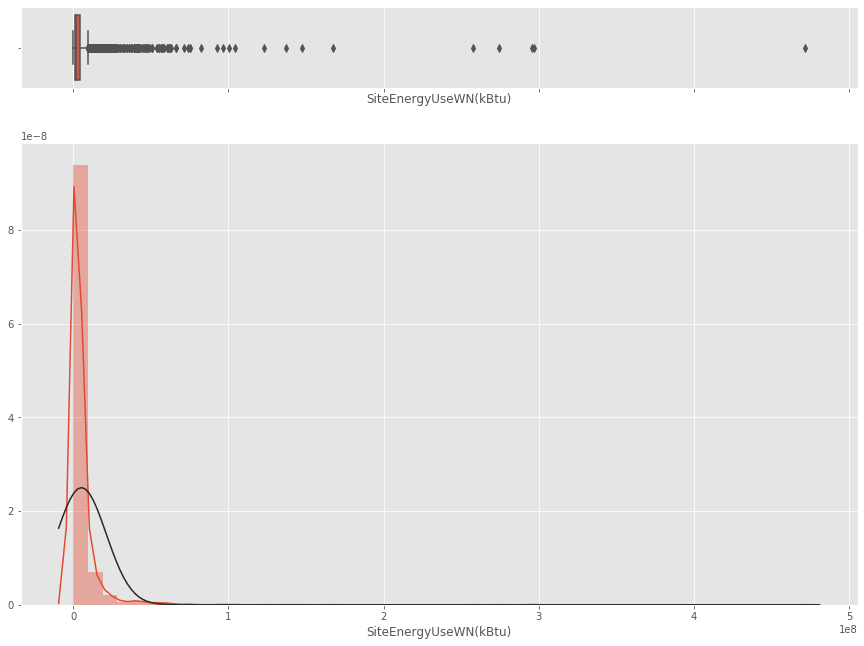

In [29]:
binNumb = int(np.ceil(1 + np.log2(len(data_2016[OutputColumns[0]]))))
a4_dims = (15, 11)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)
ax1 = sns.boxplot(data_2016[OutputColumns[0]], ax=ax_box)
ax2 = sns.distplot(data_2016[OutputColumns[0]], fit=st.norm)

#inner_data_2016[OutputColumns[0]].plot.hist(bins = binNumb)

In [30]:
log_energy_data_2016 = inner_data_2016[OutputColumns[0]].apply(lambda x: np.log(x)).replace([np.inf, -np.inf], 1)


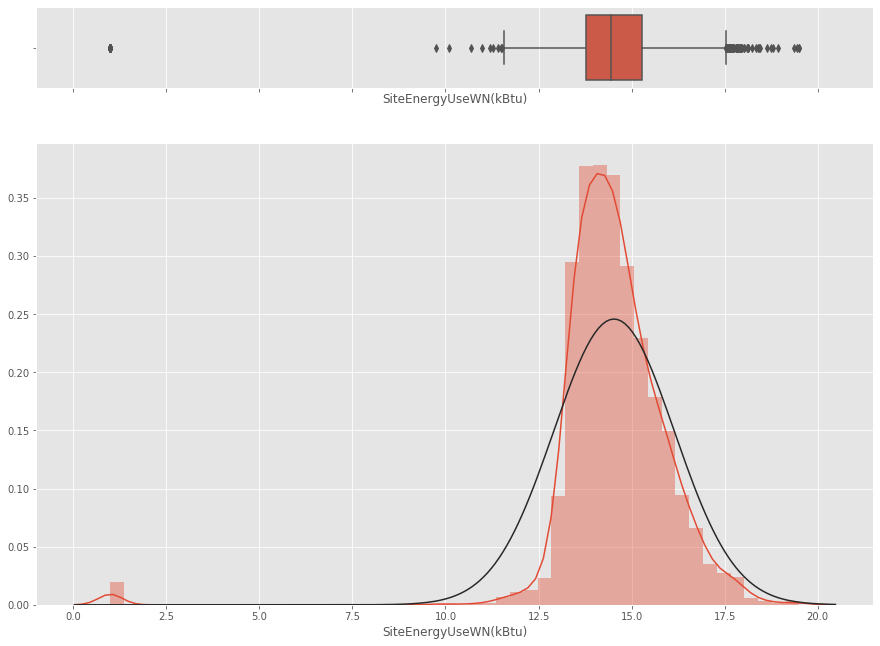

In [31]:
binNumb = int(np.ceil(1 + np.log2(len(data_2016[OutputColumns[0]]))))
a4_dims = (15, 11)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)
ax1 = sns.boxplot(log_energy_data_2016, ax=ax_box)
ax2 = sns.distplot(log_energy_data_2016, fit=st.norm)

#inner_data_2016[OutputColumns[0]].plot.hist(bins = binNumb)

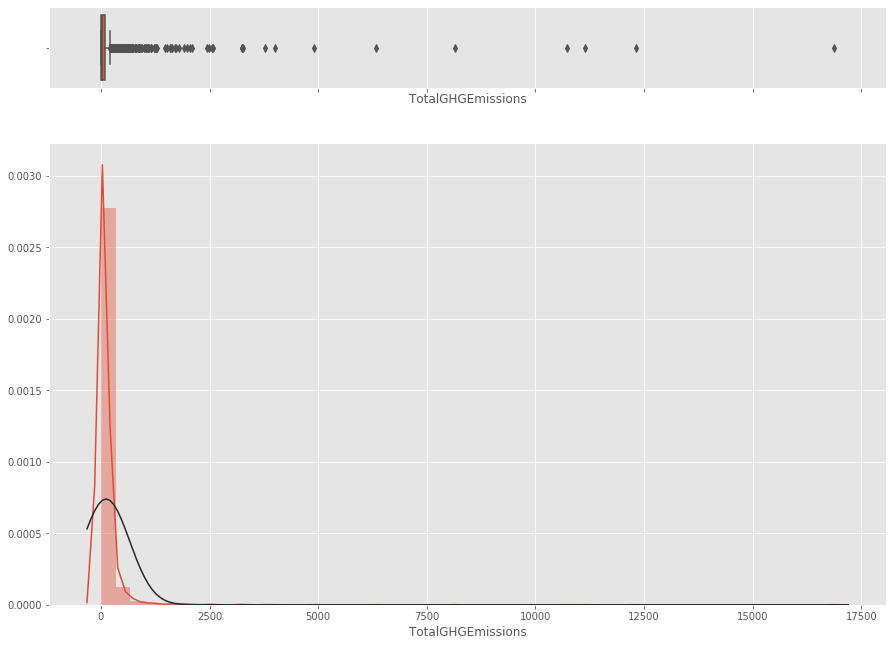

In [32]:
binNumb = int(np.ceil(1 + np.log2(len(data_2016[OutputColumns[1]]))))
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax1 = sns.boxplot(data_2016[OutputColumns[1]], ax=ax_box)
ax2 = sns.distplot(data_2016[OutputColumns[1]], fit=st.norm)
#inner_data_2016[OutputColumns[0]].plot.hist(bins = binNumb)

In [33]:
log_ghg_data_2016 = inner_data_2016[OutputColumns[1]].apply(lambda x: np.log(x)).replace([np.inf, -np.inf, np.nan], 1)
len(log_ghg_data_2016)

3276

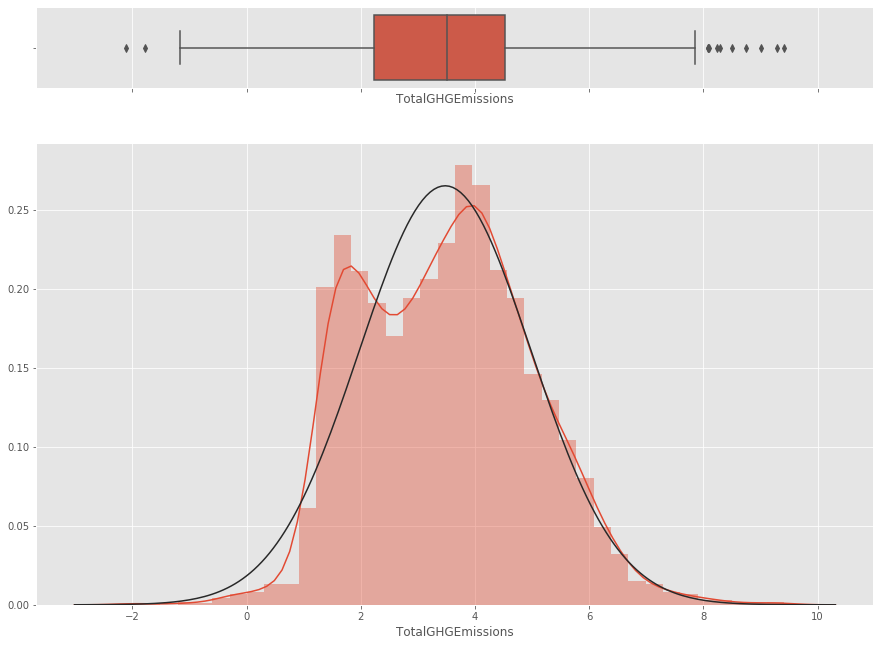

In [34]:
binNumb = int(np.ceil(1 + np.log2(len(inner_data_2016[OutputColumns[1]]))))
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax1 = sns.boxplot(log_ghg_data_2016, ax=ax_box)
ax2 = sns.distplot(log_ghg_data_2016, fit=st.norm)
#inner_data_2016[OutputColumns[0]].plot.hist(bins = binNumb)

In [35]:
inner_data_2016[OutputColumns[0]].replace()

0       7.456910e+06
1       8.664479e+06
2       7.393711e+07
3       6.946800e+06
4       1.465650e+07
            ...     
3271    1.305528e+06
3272    1.736628e+06
3273    1.540416e+07
3274    8.283887e+05
3275    1.024887e+06
Name: SiteEnergyUseWN(kBtu), Length: 3276, dtype: float64

In [36]:
inner_data_2016[OutputColumns[0]] = log_energy_data_2016
inner_data_2016[OutputColumns[1]] = log_ghg_data_2016

In [37]:
inner_data_2016[OutputColumns]

SiteEnergyUseWN(kBtu)  TotalGHGEmissions
0                 15.824652           5.521381
1                 15.974742           5.689886
2                 18.118725           7.644575
3                 15.753792           5.657494
4                 16.500395           6.224578
...                     ...                ...
3271              14.082118           2.163323
3272              14.367456           3.448717
3273              16.550148           5.979544
3274              13.627238           1.697449
3275              13.840093           1.908060

[3276 rows x 2 columns]

## One hot encoding

One hot encoding for qualitative values : **OneHotColumns** = *BuildingType*, *PrimaryPropertyType*, *CouncilDistrictCode*  

In [38]:
df_dummies = pd.get_dummies(
    inner_data_2015[OneHotColumns].astype(str),
    prefix=['Building', 'Property', 'DistrictCode'])

In [39]:
inner_data_2015 = inner_data_2015.drop(OneHotColumns, axis=1)

In [40]:
info = inner_data_2015[['OSEBuildingID', 'DataYear']]

## Normalization

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [42]:
features = inner_data_2015[NormalizeColumns].columns[:]

x = inner_data_2015[NormalizeColumns].loc[:, features].values

for arrays in x:
    i = 0
    for values in arrays:
        arrays[i] = np.nan_to_num(values)
        i += 1

In [43]:
min_max_scaler = MinMaxScaler()
x = StandardScaler().fit_transform(x)  # normalizing the features

normalized_data_2015 = pd.DataFrame(x, columns=features)

In [44]:
input_tf = info.join(normalized_data_2015.join(df_dummies))
output_tf = inner_data_2016[OutputColumns]

In [45]:
#output_tf
features = output_tf.columns[:]

x = output_tf.loc[:, features].values

for arrays in x:
    i = 0
    for values in arrays:
        arrays[i] = np.nan_to_num(values)
        i += 1
        
min_max_scaler = MinMaxScaler()
x = StandardScaler().fit_transform(x)  # normalizing the features

output_tf = pd.DataFrame(x, columns=features)

## Data For ML

Preparing different sets for further training, validation and evaluation.

In [46]:
X = input_tf.drop(info, axis=1)
y = output_tf

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [47]:
#Used for predicting each feature on its own
y_train_energy = y_train['SiteEnergyUseWN(kBtu)'].values
y_test_energy = y_test['SiteEnergyUseWN(kBtu)'].values

y_train_GHG = y_train['TotalGHGEmissions'].values
y_test_GHG = y_test['TotalGHGEmissions'].values

#Muted data without energy data
X_train_unleaked = X_train.drop(Leaked_Neuron_Columns, axis = 1).values
X_test_unleaked = X_test.drop(Leaked_Neuron_Columns, axis = 1).values

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

data_sets = [
    [X_train, y_train_energy , X_test, y_test_energy,len(X_train[0])],
    [X_train_unleaked, y_train_energy , X_test_unleaked, y_test_energy,len(X_train_unleaked[0])],
    [X_train, y_train_GHG , X_test, y_test_GHG, len(X_train[0])],
    [X_train_unleaked, y_train_GHG , X_test_unleaked, y_test_GHG,len(X_train_unleaked[0])]
]

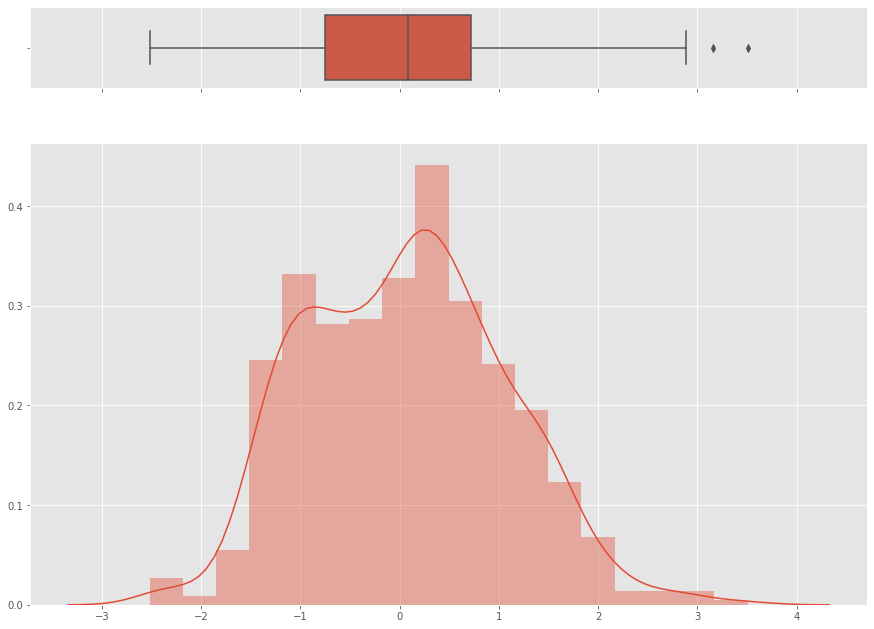

In [48]:
binNumb = int(np.ceil(1 + np.log2(len(y_test_GHG))))
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax1 = sns.boxplot(y_test_GHG, ax=ax_box)
ax2 = sns.distplot(y_test_GHG)
#inner_data_2016[OutputColumns[0]].plot.hist(bins = binNumb)

## Utility Functions For ML

In [49]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f(x):
    # return math.sqrt(x)
    if(x == 0) : return 0
    else : return (1/x)
def array_map(x):
    return np.array([f(xi) for xi in x])

def mean_percentage(y_true, y_pred):
    #record_score = []
    
    diff = K.abs(np.subtract(y_true, y_pred))
    perc = Multiply()([diff, array_map(y_true)])
    #perc = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([diff, 1/y_true])

    return K.mean(100*perc)

def mean_percentage_np(y_true, y_pred):
    #record_score = []
    
    diff = np.abs(np.subtract(y_true ,y_pred))
    perc = np.multiply(diff, array_map(y_true))
    #perc = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([diff, 1/y_true])

    return np.mean(100*perc)
   # for i in range(0, y_true):
      #  diff = np.abs(y_true[i] - y_pred[i])
      #  perc = diff/y_true[i]
      #  record_score.append(1 - perc)
        #return record_score[0]
   # return np.mean(record_score)

def evaluate_tf(model, test_features, test_labels):
    predictions_list = model.predict(test_features)
    predictions = []
    for sublist in predictions_list:
        for item in sublist:
            predictions.append(item)

    errors = abs(predictions - test_labels)

    mape = 100 * np.mean(np.divide(errors, test_labels))

    mse = np.sqrt(np.mean(np.square(np.subtract(predictions, test_labels))))
    return mse, mape

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)

    errors = abs(predictions - test_labels)

    mape = 100 * np.mean(np.divide(test_labels, errors))

    mse = np.sqrt(np.mean(np.square(np.subtract(predictions, test_labels))))

    print('Model Performance : \n')
    print('MSE = ', mse)
    print('Mape = ', mape)
    print()

    return mse, mape

def evaluate_random(random_y, true_y):
    errors = abs(random_y - true_y)
    mape = 100 * np.mean(np.divide(true_y, errors))
    mse = np.sqrt(np.mean(np.square(np.subtract(random_y, true_y))))

    print('Model Performance : \n')
    print('MSE = ', mse)
    print('Mape = ', mape)
    print()

    return mse, mape

# Models

## Logistic Regression

In [75]:
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn import preprocessing



In [76]:
lab_enc = preprocessing.LabelEncoder()
encoded_train_energy = lab_enc.fit_transform(y_train_energy)
encoded_train_GHG = lab_enc.fit_transform(y_train_GHG)

In [77]:
lin_energy = LinearRegression(n_jobs = -1)
lin_energy.fit(X_train, encoded_train_energy)

lin_GHG = LinearRegression(n_jobs = -1)
lin_GHG.fit(X_train, encoded_train_GHG)

lin_unleaked_energy = LinearRegression(n_jobs = -1)
lin_unleaked_energy.fit(X_train_unleaked, encoded_train_energy)

lin_unleaked_GHG = LinearRegression(n_jobs = -1)
lin_unleaked_GHG.fit(X_train_unleaked, encoded_train_GHG)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [84]:
evaluate(lin_unleaked_energy, X_test_unleaked, y_test_energy)
evaluate(lin_energy, X_test, y_test_energy)


evaluate(lin_GHG, X_test, y_test_GHG)
evaluate(lin_unleaked_GHG,X_test_unleaked, y_test_GHG)






Model Performance : 

MSE =  1447.6789415810604
Mape =  -0.010072149337407313

Model Performance : 

MSE =  1475.587621375794
Mape =  -0.01505544656798892

Model Performance : 

MSE =  1208.8549184953126
Mape =  -0.03830776706750894

Model Performance : 

MSE =  1158.6468361664615
Mape =  -0.019408007584458407



(1158.6468361664615, -0.019408007584458407)

[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'Linear Regression Energy Prediction Error Difference')]

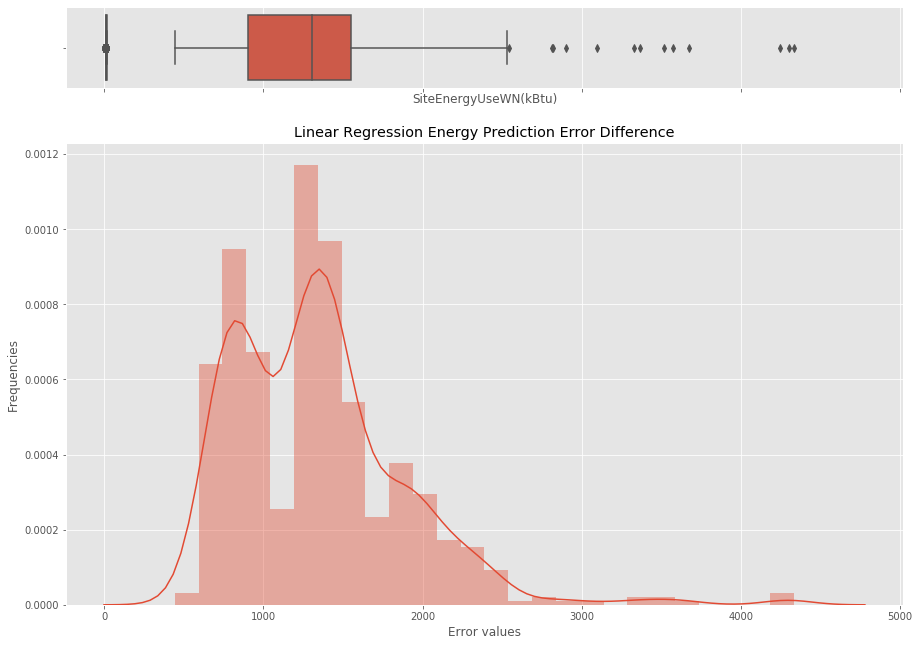

In [79]:
energy_predict = lin_unleaked_energy.predict(X_test_unleaked)
df_diff = pd.DataFrame(energy_predict - y_test_energy)
mean = df_diff.mean().values
median = df_diff.median().values

binNumb = int(np.ceil(1 + np.log2(len(energy_predict))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax0 = sns.boxplot(log_energy_data_2016, ax=ax_box)
ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="Linear Regression Energy Prediction Error Difference")


In [80]:
Ela_energy = ElasticNetCV(cv = 5, random_state = 42)
Ela_energy.fit(X_train, encoded_train_energy)

Ela_GHG = ElasticNetCV(cv = 5, random_state = 42)
Ela_GHG.fit(X_train, encoded_train_GHG)

Ela_unleaked_energy = ElasticNetCV(cv = 5, random_state = 42)
Ela_unleaked_energy.fit(X_train_unleaked, encoded_train_energy)

Ela_unleaked_GHG = ElasticNetCV(cv = 5, random_state = 42)
Ela_unleaked_GHG.fit(X_train_unleaked, encoded_train_GHG)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
       normalize=False, positive=False, precompute='auto', random_state=42,
       selection='cyclic', tol=0.0001, verbose=0)

In [85]:
evaluate(Ela_unleaked_energy, X_test_unleaked, y_test_energy)
evaluate(Ela_energy, X_test, y_test_energy)

evaluate(Ela_unleaked_GHG,X_test_unleaked, y_test_GHG)
evaluate(Ela_GHG, X_test, y_test_GHG)

Model Performance : 

MSE =  1366.8723445403928
Mape =  -0.0042295144125410414

Model Performance : 

MSE =  1403.5551778207698
Mape =  -0.008841752069848958

Model Performance : 

MSE =  1097.104946845237
Mape =  -0.009047498634931796

Model Performance : 

MSE =  1136.7695344329475
Mape =  -0.020939852332316516



(1136.7695344329475, -0.020939852332316516)

[1316.31123314] [1295.34900695]


[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'ElasticNet Regression Energy Prediction Error Difference')]

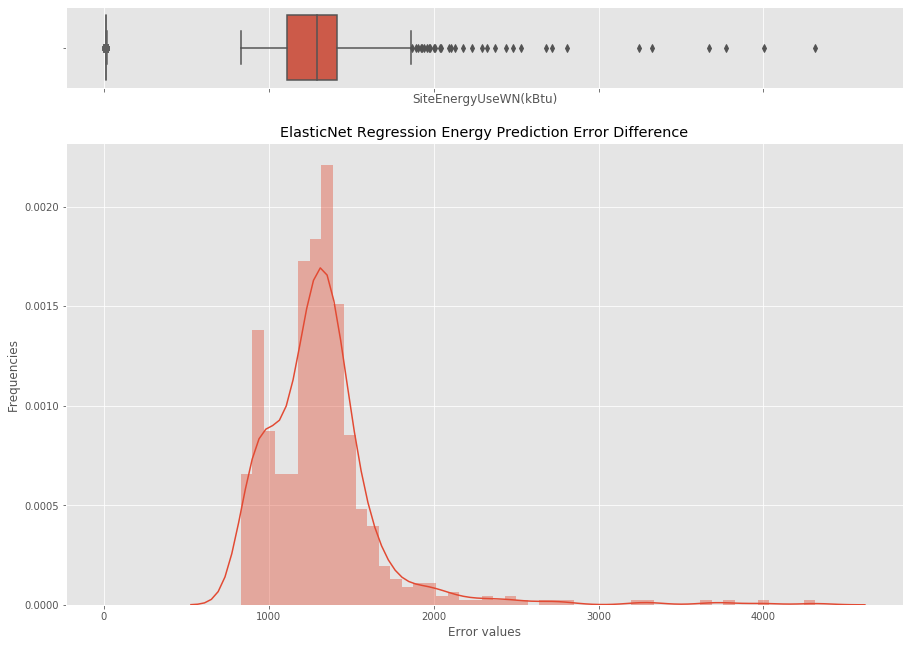

In [83]:
df_diff = pd.DataFrame(Ela_unleaked_energy.predict(X_test_unleaked) - y_test_energy)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(Ela_unleaked_energy.predict(X_test_unleaked)))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax0 = sns.boxplot(log_energy_data_2016, ax=ax_box, palette="Blues")
ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="ElasticNet Regression Energy Prediction Error Difference")



## KNN 

### Regular KNN Exploration

In [86]:
from sklearn import neighbors, dummy

In [87]:
for i in range(2, 100, 2):
    knn_energy = neighbors.KNeighborsRegressor(n_neighbors = i)
    knn_energy.fit(X_train, y_train_energy)
    mse, mape = evaluate(knn_energy, X_test, y_test_energy)
    if(i == 2): maxValue1 = [mse, i]
    if maxValue1[0] > mse:
        bestModel = knn_energy
        maxValue1 = [mse, i]
        print('new best value : ', maxValue1)
print(maxValue1)

for i in range(2, 100, 2):
    knn_GHG = neighbors.KNeighborsRegressor(n_neighbors = i)
    knn_GHG.fit(X_train, y_train_GHG)
    mse, mape = evaluate(knn_GHG, X_test, y_test_energy)
    if(i == 2): maxValue2 = [mse, i]
    if maxValue2[0] > mse:
        bestModel = knn_GHG
        maxValue2 = [mse, i]
        print('new best value : ', maxValue2)
print(maxValue2)

for i in range(2, 100, 2):
    knn_energy_unleaked = neighbors.KNeighborsRegressor(n_neighbors = i)
    knn_energy_unleaked.fit(X_train_unleaked, y_train_energy)
    mse, mape = evaluate(knn_energy_unleaked, X_test_unleaked, y_test_energy)
    if(i == 2): maxValue3 = [mse, i]
    if maxValue3[0] > mse:
        bestModel = knn_energy_unleaked
        maxValue3 = [mse, i]
        print('new best value : ', maxValue3)
print(maxValue3)

for i in range(2, 100, 2):
    knn_GHG_unleaked = neighbors.KNeighborsRegressor(n_neighbors = i)
    knn_GHG_unleaked.fit(X_train_unleaked, y_train_GHG)
    mse, mape = evaluate(knn_GHG_unleaked, X_test_unleaked, y_test_energy)
    if(i == 2): maxValue4 = [mse, i]
    if maxValue4[0] > mse:
        bestModel = knn_GHG_unleaked
        maxValue4 = [mse, i]
        print('new best value : ', maxValue4)
print(maxValue4)

Model Performance : 

MSE =  0.8201905568318076
Mape =  22691.368759204677

Model Performance : 

MSE =  0.8202789618256894
Mape =  329.2805342780627

Model Performance : 

MSE =  0.7919776846037853
Mape =  708.3244399471082

new best value :  [0.7919776846037853, 6]
Model Performance : 

MSE =  0.7412086342439834
Mape =  -406.5914882315763

new best value :  [0.7412086342439834, 8]
Model Performance : 

MSE =  0.7414676677311275
Mape =  57.56856500230614

Model Performance : 

MSE =  0.7386628701811833
Mape =  -427.24133091108473

new best value :  [0.7386628701811833, 12]
Model Performance : 

MSE =  0.7421813249607552
Mape =  -290.75016830942894

Model Performance : 

MSE =  0.7431396724232731
Mape =  -483.3008601097437

Model Performance : 

MSE =  0.743272575202761
Mape =  -129.4887419669215

Model Performance : 

MSE =  0.7358329029262157
Mape =  -710.6174050447798

new best value :  [0.7358329029262157, 20]
Model Performance : 

MSE =  0.7422732876582809
Mape =  -200.68591955211

Model Performance : 

MSE =  0.8424922255121682
Mape =  7521.128182406285

new best value :  [0.8424922255121682, 84]
Model Performance : 

MSE =  0.8416320181723476
Mape =  122.11213745287499

new best value :  [0.8416320181723476, 86]
Model Performance : 

MSE =  0.8410039828423134
Mape =  75.32978273696364

new best value :  [0.8410039828423134, 88]
Model Performance : 

MSE =  0.8401696586536322
Mape =  95.40238365167703

new best value :  [0.8401696586536322, 90]
Model Performance : 

MSE =  0.8385626329982006
Mape =  20.986791089919237

new best value :  [0.8385626329982006, 92]
Model Performance : 

MSE =  0.8383496399963157
Mape =  93.32429522825872

new best value :  [0.8383496399963157, 94]
Model Performance : 

MSE =  0.8375708261636114
Mape =  -91.15177962746851

new best value :  [0.8375708261636114, 96]
Model Performance : 

MSE =  0.8372888165186925
Mape =  65.83707214262452

new best value :  [0.8372888165186925, 98]
[0.8372888165186925, 98]
Model Performance : 

MSE = 

Model Performance : 

MSE =  0.8962764021902752
Mape =  31.7225459844318

Model Performance : 

MSE =  0.8957013513689175
Mape =  49.11406741067256

Model Performance : 

MSE =  0.8952704815408534
Mape =  82.14248890374446

Model Performance : 

MSE =  0.8948061773852484
Mape =  37.3895220146583

Model Performance : 

MSE =  0.8947456135148211
Mape =  145.39174121561425

Model Performance : 

MSE =  0.8947337227714767
Mape =  24.55468395002707

Model Performance : 

MSE =  0.8936321563768426
Mape =  -88.27530464446733

Model Performance : 

MSE =  0.8925587327928758
Mape =  -78.96046136652205

Model Performance : 

MSE =  0.8929553693333285
Mape =  -47.85303530139775

Model Performance : 

MSE =  0.8924491724983847
Mape =  -242.48231058304356

[0.882114264984216, 26]


0.31147058407465616  minutes.


In [89]:
knn_energy = neighbors.KNeighborsRegressor(n_neighbors = maxValue1[1])
knn_energy.fit(X_train, y_train_energy)

knn_GHG = neighbors.KNeighborsRegressor(n_neighbors = maxValue2[1])
knn_GHG.fit(X_train, y_train_GHG)

knn_energy_unleaked = neighbors.KNeighborsRegressor(n_neighbors = maxValue3[1])
knn_energy_unleaked.fit(X_train_unleaked, y_train_energy)

knn_GHG_unleaked = neighbors.KNeighborsRegressor(n_neighbors = maxValue4[1])
knn_GHG_unleaked.fit(X_train_unleaked, y_train_GHG)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=26, p=2,
          weights='uniform')

In [90]:
evaluate(knn_energy_unleaked, X_test_unleaked, y_test_energy)
evaluate(knn_energy, X_test, y_test_energy)

evaluate(knn_GHG_unleaked, X_test_unleaked, y_test_GHG)
evaluate(knn_GHG, X_test, y_test_GHG)

Model Performance : 

MSE =  0.790638083613448
Mape =  344.2411651206084

Model Performance : 

MSE =  0.7358329029262157
Mape =  -710.6174050447798

Model Performance : 

MSE =  0.7210944465310339
Mape =  -14.080370780842898

Model Performance : 

MSE =  0.5388668266537346
Mape =  -211.39769433325034



(0.5388668266537346, -211.39769433325034)

[-0.09082843] [-0.08429723]


[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'KNN GHG Prediction Error Difference')]

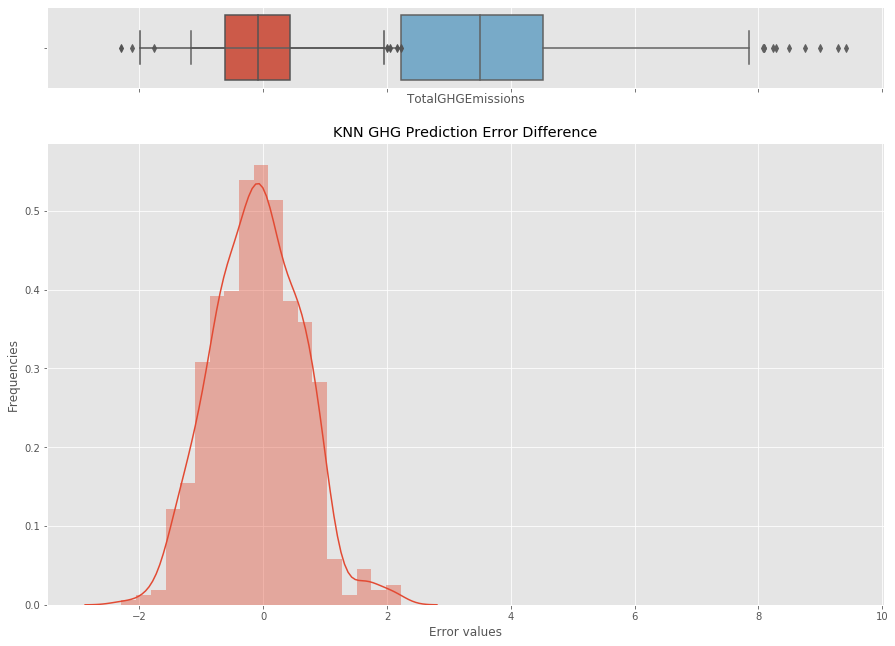

In [131]:
prediction = knn_GHG_unleaked.predict(X_test_unleaked)
df_diff = pd.DataFrame(prediction - y_test_GHG)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(prediction))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax0 = sns.boxplot(log_ghg_data_2016, ax=ax_box, palette="Blues")
ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="KNN GHG Prediction Error Difference")


### Random Output KNN

In [91]:
np.random.seed(42)
y_pred_random = np.random.randint(np.min(y_test_GHG), np.max(y_test_GHG), y_test_GHG.shape)
#mean_percentage_np(y_test_energy, y_pred_random)
evaluate_random(y_pred_random, y_test_GHG)

Model Performance : 

MSE =  1.7647666758532283
Mape =  148.7919118117237



(1.7647666758532283, 148.7919118117237)

[-0.03160671] [-0.18888712]


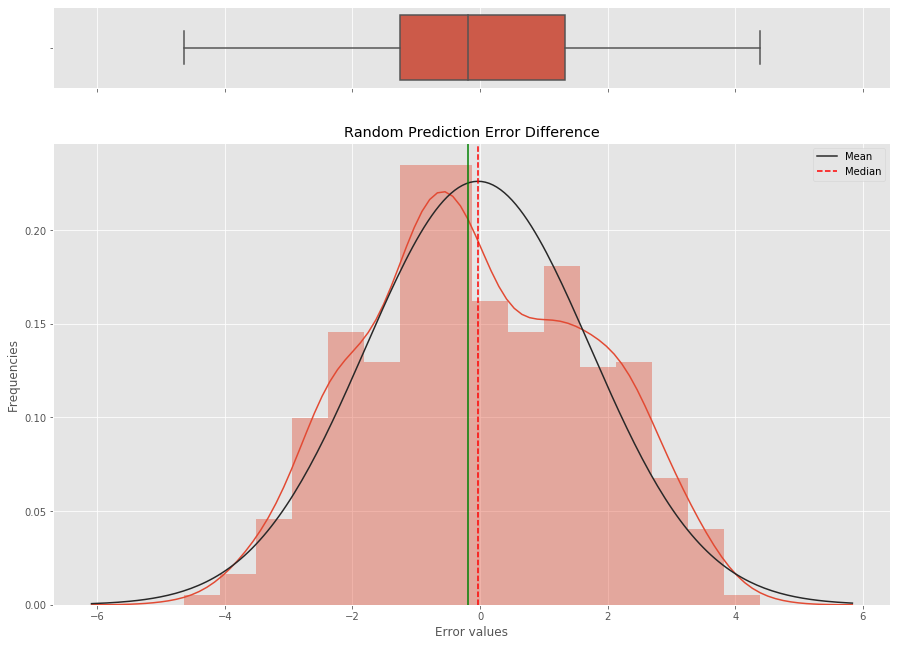

In [92]:
prediction = y_pred_random
df_diff = pd.DataFrame(prediction - y_test_GHG)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(prediction))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff, fit=st.norm)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="Random Prediction Error Difference")
ax2.axvline(mean, color='r', linestyle='--')
ax2.axvline(median, color='g', linestyle='-')

plt.legend({'Mean':mean,'Median':median})

### Mean-Dummy KNN

In [93]:
dum = dummy.DummyRegressor(strategy = 'mean')

In [94]:
dum_energy = dum.fit(X_train, y_train_energy)
dum_GHG = dum.fit(X_train, y_train_GHG)
dum_energy_unleaked = dum.fit(X_train_unleaked, y_train_energy)
dum_GHG_unleaked = dum.fit(X_train_unleaked, y_train_GHG)

In [96]:
evaluate(dum_energy_unleaked, X_test_unleaked, y_test_energy)
evaluate(dum_energy, X_test, y_test_energy)
evaluate(dum_GHG_unleaked, X_test_unleaked, y_test_GHG)
evaluate(dum_GHG, X_test, y_test_GHG)

Model Performance : 

MSE =  1.0195584103010908
Mape =  -27.668536239893143

Model Performance : 

MSE =  1.0195584103010908
Mape =  -27.668536239893143

Model Performance : 

MSE =  1.003804409858129
Mape =  -1.2426102284187461

Model Performance : 

MSE =  1.003804409858129
Mape =  -1.2426102284187461



(1.003804409858129, -1.2426102284187461)

[-0.02136183] [0.17336297]


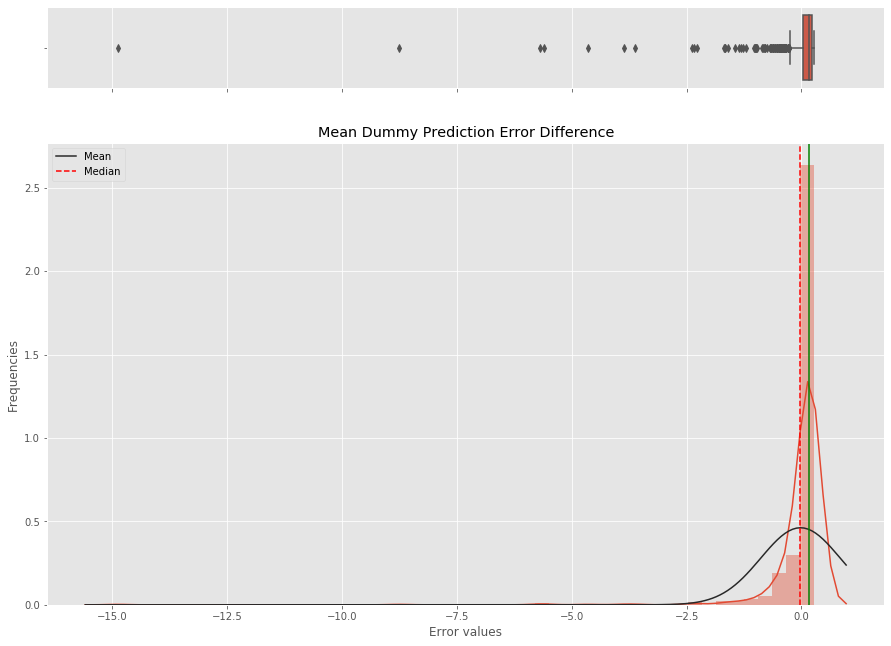

In [108]:
prediction = dum_GHG_unleaked.predict(X_test_unleaked)
df_diff = pd.DataFrame(prediction - y_test_GHG)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(prediction))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff, fit=st.norm)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="Mean Dummy Prediction Error Difference")
ax2.axvline(mean, color='r', linestyle='--')
ax2.axvline(median, color='g', linestyle='-')

plt.legend({'Mean':mean,'Median':median})

## DNN 

Keras interface

**KFOLD AND DL**

### Keras  & TensorFlow

In [97]:
import import_ipynb

In [98]:
import tensorflow as tf
import datetime, os

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Multiply
from keras.callbacks import TensorBoard

from tensorboard import notebook
from tensorboard.plugins.hparams import api as hp

from CLR import CyclicLR

%reload_ext tensorboard
%load_ext tensorboard

#HParam
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128, 256]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.05, 0.1))

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['nadam', 'adamax']))

METRIC_ACCURACY = 'Accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

importing Jupyter notebook from CLR.ipynb
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Using TensorFlow backend.


#59 variables
X = input_tf.drop(info, axis=1)
X_train = input_tf[:1460].drop(info, axis=1)
X_valid = input_tf[1460:1946].drop(info, axis=1)
X_test = input_tf[1946:].drop(info, axis=1)

#2 variables
y = output_tf
y_train = output_tf[:1460]
y_valid = output_tf[1460:1946]
y_test = output_tf[1946:]

#OutputColumns = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']
#Used for predicting each feature on its own
y_energy = y['SiteEnergyUseWN(kBtu)']
y_train_energy = y_train['SiteEnergyUseWN(kBtu)']
y_valid_energy = y_valid['SiteEnergyUseWN(kBtu)']
y_test_energy = y_test['SiteEnergyUseWN(kBtu)']

y_GHE = y['TotalGHGEmissions']
y_train_GHE = y_train['TotalGHGEmissions']
y_valid_GHE = y_valid['TotalGHGEmissions']
y_test_GHE = y_test['TotalGHGEmissions']

In [99]:
notebook.list() # View open TensorBoard instances

No known TensorBoard instances running.


In [100]:
!kill -9 769
!fuser 6006/tcp -k

/bin/sh: line 0: kill: (769) - No such process
Unknown option: k
fuser: [-cfu] file ...
	-c	file is treated as mount point
	-f	the report is only for the named files
	-u	print username of pid in parenthesis


In [101]:
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.2
  if epoch > (total_epochs*0.05):
    learning_rate = 0.1
  if epoch > (total_epochs*0.4):
    learning_rate = 0.02
  if epoch > (total_epochs*0.6):
    learning_rate = 0.01
  #if epoch > (tEpoch*0.8):
    #learning_rate = 0.005

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate


In [123]:
# Define model
def create_model(hparams, tot_epochs, tensorboard_callback, run_name, X, y, Xtest, ytest, inputDim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS],
                              input_dim=inputDim,
                              activation='relu',
                              kernel_initializer='random_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(128,
                              activation="relu",
                              kernel_initializer='random_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(128,
                              activation="relu",
                              kernel_initializer='random_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(128,
                              activation="relu",
                              kernel_initializer='random_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(64,
                              activation="relu",
                              kernel_initializer='random_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(1, activation='linear')
    ])

    model.compile(loss="mse",
                  optimizer=hparams[HP_OPTIMIZER],
                  metrics=['mae', 'mape', 'accuracy'])


    # Fit Model
    model.fit(
        X,
        y,
        epochs=tot_epochs,
        batch_size=32,
        validation_data=(Xtest, ytest),
        shuffle=False,
        callbacks=[tensorboard_callback,
                   hp.KerasCallback(run_name, hparams)])

    #accuracy = mean_percentage(y_test_energy, model.predict(X_test))
    mse, mape = evaluate_tf(model, Xtest, ytest)
    #pred = model.predict(X_test).tolist()
    #Pred = []
    #for sublist in pred:
    #    for item in sublist:
    #        Pred.append(item)
    
    #mape = mean_percentage_np(y_test_energy.tolist(), Pred)
    #mse = np.sqrt(K.get_value(K.mean(K.square(np.subtract(Pred, y_test_energy.tolist())))))
    #perc = K.mean(100*(Divide()([K.abs(np.subtract(y_test_energy.tolist(), Pred)), y_test_energy.tolist()])))
    
    print("accuracy here is : ", mse)
    m_dict = {
        'model': model,
        'test_mse': mse,
        'test_mape' : mape,
        'description': {h.name: hparams[h] for h in hparams}
    }
    all_models.append(m_dict)
    return mse

#Play one turn for each HyperParameters
def one_training_each(X, y, Xtest, ytest, inputDim):

    !rm -rf ./logs/
    !rm -rf ./fit/

    all_models = []

    session_num = 0
    total_epochs = 30
    run_name = "logs/fit/" + ("run-%d" % session_num)
   
    for num_units in HP_NUM_UNITS.domain.values:
      for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
          run_name = "logs/fit/" + ("run-%d" % session_num)
          hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "logs/fit/" + ("run-%d" % session_num)
          tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name,
                                                              histogram_freq=1)
       
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          descript = {h.name: hparams[h] for h in hparams}
          #run('logs/hparam_tuning/' + run_name, hparams)
          create_model(hparams, total_epochs, tensorboard_callback, run_name , X, y, Xtest, ytest, inputDim)
          session_num += 1
            
            

In [103]:
def on_epoch_end(self, epoch, logs=None):
    print(K.eval(self.model.optimizer.lr))


#class LRTensorBoard(TensorBoard):
  #  def __init__(self, log_dir,
    #             **kwargs):  # add other arguments to __init__ if you need
    #    super().__init__(log_dir=log_dir, **kwargs)

   # def on_epoch_end(self, epoch, logs=None):
    #    logs.update({'lr': K.eval(self.model.optimizer.lr)})
       # super().on_epoch_end(epoch, logs)#

In [104]:
hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    print("yooooo : ", run_dir )
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = create_model(hparams, total_epochs)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [105]:
len(X_train[0])

59

In [106]:
tf.keras.backend.clear_session()

!rm -rf ./logs/
!rm -rf ./fit/

all_models = []
session_num = 0
total_epochs = 50
run_name = "logs/fit/" + ("run-%d" % session_num)


for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "logs/fit/" + ("run-%d" % session_num)

      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name,
                                                      histogram_freq=1)
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      descript = {h.name: hparams[h] for h in hparams}
      #run('logs/hparam_tuning/' + run_name, hparams)
      create_model(hparams, total_epochs,tensorboard_callback, run_name, X_train, y_train_energy , X_test, y_test_energy, inputDim = len(X_train[0]))
      session_num += 1
all_models_energy = all_models

--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 396us/sample - loss: 0.8537 - mae: 0.5044 - mape: 108.1668 - accuracy: 0.0000e+00 - val_loss: 0.7815 - val_mae: 0.4620 - val_mape: 177.6185 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.7047 - mae: 0.3719 - mape: 182.8826 - accuracy: 0.0000e+00 - val_loss: 0.6177 - val_mae: 0.3156 - val_mape: 367.5954 - val_accuracy: 0.0000e+00
Epoch 3/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5916 - mae: 0.2685 - mape: 191.6250 - accuracy: 0.0000e+00 - val_loss: 0.5684 - val_mae: 0.2692 - val_mape: 370.0690 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 52us/sample - loss: 0.5713 - mae: 0.2534 - mape: 176.6429 - accuracy: 0.0000e+00 - val_loss: 0.5482 - val_mae: 0.2541 - val_m

Epoch 37/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.4171 - mae: 0.2276 - mape: 195.6494 - accuracy: 0.0000e+00 - val_loss: 0.5678 - val_mae: 0.2496 - val_mape: 260.7684 - val_accuracy: 0.0000e+00
Epoch 38/50
2620/2620 [==============================] - 0s 52us/sample - loss: 0.4167 - mae: 0.2335 - mape: 205.8320 - accuracy: 0.0000e+00 - val_loss: 0.5732 - val_mae: 0.2485 - val_mape: 276.1168 - val_accuracy: 0.0000e+00
Epoch 39/50
2620/2620 [==============================] - 0s 52us/sample - loss: 0.4028 - mae: 0.2291 - mape: 188.0927 - accuracy: 0.0000e+00 - val_loss: 0.5835 - val_mae: 0.2569 - val_mape: 280.3939 - val_accuracy: 0.0000e+00
Epoch 40/50
2620/2620 [==============================] - 0s 52us/sample - loss: 0.4023 - mae: 0.2272 - mape: 173.9176 - accuracy: 0.0000e+00 - val_loss: 0.5922 - val_mae: 0.2565 - val_mape: 290.9469 - val_accuracy: 0.0000e+00
Epoch 41/50
2620/2620 [==============================] - 0s 52us/sample - loss: 0.4085 - mae: 0.

2620/2620 [==============================] - 0s 49us/sample - loss: 0.5570 - mae: 0.2516 - mape: 198.6790 - accuracy: 0.0000e+00 - val_loss: 0.5260 - val_mae: 0.2404 - val_mape: 506.0579 - val_accuracy: 0.0000e+00
Epoch 8/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5600 - mae: 0.2540 - mape: 174.7907 - accuracy: 0.0000e+00 - val_loss: 0.5230 - val_mae: 0.2421 - val_mape: 535.0307 - val_accuracy: 0.0000e+00
Epoch 9/50
2620/2620 [==============================] - 0s 51us/sample - loss: 0.5535 - mae: 0.2488 - mape: 192.1834 - accuracy: 0.0000e+00 - val_loss: 0.5198 - val_mae: 0.2411 - val_mape: 551.0352 - val_accuracy: 0.0000e+00
Epoch 10/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5433 - mae: 0.2506 - mape: 193.8147 - accuracy: 0.0000e+00 - val_loss: 0.5137 - val_mae: 0.2358 - val_mape: 572.4673 - val_accuracy: 0.0000e+00
Epoch 11/50
2620/2620 [==============================] - 0s 52us/sample - loss: 0.5425 - mae: 0.2467 - mape: 1

2620/2620 [==============================] - 0s 62us/sample - loss: 0.3668 - mae: 0.2176 - mape: 184.6720 - accuracy: 0.0000e+00 - val_loss: 0.5652 - val_mae: 0.2404 - val_mape: 351.9335 - val_accuracy: 0.0000e+00
Epoch 29/50
2620/2620 [==============================] - 0s 62us/sample - loss: 0.3720 - mae: 0.2160 - mape: 161.8998 - accuracy: 0.0000e+00 - val_loss: 0.6287 - val_mae: 0.2564 - val_mape: 277.2559 - val_accuracy: 0.0000e+00
Epoch 30/50
2620/2620 [==============================] - 0s 62us/sample - loss: 0.3377 - mae: 0.2056 - mape: 151.6581 - accuracy: 0.0000e+00 - val_loss: 0.6451 - val_mae: 0.2501 - val_mape: 233.6284 - val_accuracy: 0.0000e+00
Epoch 31/50
2620/2620 [==============================] - 0s 64us/sample - loss: 0.3689 - mae: 0.2123 - mape: 162.7230 - accuracy: 0.0000e+00 - val_loss: 0.6537 - val_mae: 0.2698 - val_mape: 268.8289 - val_accuracy: 0.0000e+00
Epoch 32/50
2620/2620 [==============================] - 0s 62us/sample - loss: 0.3609 - mae: 0.2136 - mape:

2620/2620 [==============================] - 0s 57us/sample - loss: 0.3025 - mae: 0.2135 - mape: 169.2363 - accuracy: 0.0000e+00 - val_loss: 0.6098 - val_mae: 0.2574 - val_mape: 360.5771 - val_accuracy: 0.0000e+00
Epoch 50/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.3203 - mae: 0.2204 - mape: 176.3255 - accuracy: 0.0000e+00 - val_loss: 0.6250 - val_mae: 0.2512 - val_mape: 310.7467 - val_accuracy: 0.0000e+00
accuracy here is :  0.79058676997953
--- Starting trial: logs/fit/run-5
{'num_units': 128, 'dropout': 0.05, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 444us/sample - loss: 0.7048 - mae: 0.3728 - mape: 190.0937 - accuracy: 0.0000e+00 - val_loss: 0.5729 - val_mae: 0.2935 - val_mape: 464.1308 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 74us/sample - loss: 0.6005 - mae: 0.2798 - mape: 197.9558 - accuracy: 0.0000e+00 - val_loss: 0.548

2620/2620 [==============================] - 0s 55us/sample - loss: 0.5082 - mae: 0.2409 - mape: 222.1173 - accuracy: 0.0000e+00 - val_loss: 0.5174 - val_mae: 0.2425 - val_mape: 528.8610 - val_accuracy: 0.0000e+00
Epoch 20/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5104 - mae: 0.2394 - mape: 190.8741 - accuracy: 0.0000e+00 - val_loss: 0.5213 - val_mae: 0.2401 - val_mape: 493.8375 - val_accuracy: 0.0000e+00
Epoch 21/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4981 - mae: 0.2373 - mape: 195.7344 - accuracy: 0.0000e+00 - val_loss: 0.5247 - val_mae: 0.2418 - val_mape: 504.5308 - val_accuracy: 0.0000e+00
Epoch 22/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5027 - mae: 0.2419 - mape: 222.3557 - accuracy: 0.0000e+00 - val_loss: 0.5213 - val_mae: 0.2402 - val_mape: 511.3198 - val_accuracy: 0.0000e+00
Epoch 23/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4970 - mae: 0.2358 - mape:

2620/2620 [==============================] - 0s 67us/sample - loss: 0.3008 - mae: 0.1919 - mape: 157.7800 - accuracy: 0.0000e+00 - val_loss: 0.7512 - val_mae: 0.2505 - val_mape: 269.7323 - val_accuracy: 0.0000e+00
Epoch 41/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.2822 - mae: 0.1909 - mape: 149.4218 - accuracy: 0.0000e+00 - val_loss: 0.6371 - val_mae: 0.2428 - val_mape: 249.6241 - val_accuracy: 0.0000e+00
Epoch 42/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.2833 - mae: 0.1852 - mape: 150.1432 - accuracy: 0.0000e+00 - val_loss: 0.7244 - val_mae: 0.2502 - val_mape: 243.9970 - val_accuracy: 0.0000e+00
Epoch 43/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3077 - mae: 0.1908 - mape: 130.5284 - accuracy: 0.0000e+00 - val_loss: 0.6268 - val_mae: 0.2396 - val_mape: 313.2449 - val_accuracy: 0.0000e+00
Epoch 44/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.2609 - mae: 0.1874 - mape:

2620/2620 [==============================] - 0s 73us/sample - loss: 0.5165 - mae: 0.2472 - mape: 173.9948 - accuracy: 0.0000e+00 - val_loss: 0.5461 - val_mae: 0.2524 - val_mape: 517.8371 - val_accuracy: 0.0000e+00
Epoch 11/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5092 - mae: 0.2436 - mape: 162.8776 - accuracy: 0.0000e+00 - val_loss: 0.5349 - val_mae: 0.2517 - val_mape: 519.1383 - val_accuracy: 0.0000e+00
Epoch 12/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4877 - mae: 0.2417 - mape: 152.2509 - accuracy: 0.0000e+00 - val_loss: 0.5547 - val_mae: 0.2661 - val_mape: 480.6546 - val_accuracy: 0.0000e+00
Epoch 13/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4701 - mae: 0.2379 - mape: 197.2555 - accuracy: 0.0000e+00 - val_loss: 0.5406 - val_mae: 0.2578 - val_mape: 482.6786 - val_accuracy: 0.0000e+00
Epoch 14/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4708 - mae: 0.2419 - mape:

2620/2620 [==============================] - 0s 58us/sample - loss: 0.4235 - mae: 0.2380 - mape: 181.3519 - accuracy: 0.0000e+00 - val_loss: 0.5662 - val_mae: 0.2420 - val_mape: 327.6431 - val_accuracy: 0.0000e+00
Epoch 32/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4161 - mae: 0.2357 - mape: 172.7825 - accuracy: 0.0000e+00 - val_loss: 0.5750 - val_mae: 0.2475 - val_mape: 417.8495 - val_accuracy: 0.0000e+00
Epoch 33/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.3977 - mae: 0.2258 - mape: 161.5591 - accuracy: 0.0000e+00 - val_loss: 0.5769 - val_mae: 0.2431 - val_mape: 416.7142 - val_accuracy: 0.0000e+00
Epoch 34/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.3854 - mae: 0.2321 - mape: 166.8135 - accuracy: 0.0000e+00 - val_loss: 0.5872 - val_mae: 0.2563 - val_mape: 407.0348 - val_accuracy: 0.0000e+00
Epoch 35/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.3767 - mae: 0.2308 - mape:

1.860502537091573  minutes.


In [107]:
tf.keras.backend.clear_session()

!rm -rf ./logs/
!rm -rf ./fit/

all_models = []
session_num = 0
total_epochs = 50
run_name = "logs/fit/" + ("run-%d" % session_num)


for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "logs/fit/" + ("run-%d" % session_num)

      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name,
                                                      histogram_freq=1)
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      descript = {h.name: hparams[h] for h in hparams}
      #run('logs/hparam_tuning/' + run_name, hparams)
      create_model(hparams, total_epochs,tensorboard_callback, run_name, X_train_unleaked, y_train_energy , X_test_unleaked, y_test_energy, inputDim = len(X_train_unleaked[0]))
      session_num += 1
all_models_energy_unleaked = all_models


--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 307us/sample - loss: 0.9092 - mae: 0.5297 - mape: 112.0128 - accuracy: 0.0000e+00 - val_loss: 0.7876 - val_mae: 0.4635 - val_mape: 247.4202 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.7529 - mae: 0.4065 - mape: 208.5884 - accuracy: 0.0000e+00 - val_loss: 0.6672 - val_mae: 0.3796 - val_mape: 664.8229 - val_accuracy: 0.0000e+00
Epoch 3/50
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6931 - mae: 0.3584 - mape: 266.9906 - accuracy: 0.0000e+00 - val_loss: 0.6271 - val_mae: 0.3537 - val_mape: 787.0035 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.6751 - mae: 0.3490 - mape: 267.1656 - accuracy: 0.0000e+00 - val_loss: 0.6110 - val_mae: 0.3517 - val_m

2620/2620 [==============================] - 0s 67us/sample - loss: 0.5290 - mae: 0.3158 - mape: 261.5855 - accuracy: 0.0000e+00 - val_loss: 0.8009 - val_mae: 0.3691 - val_mape: 1077.7208 - val_accuracy: 0.0000e+00
Epoch 22/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5418 - mae: 0.3214 - mape: 264.8844 - accuracy: 0.0000e+00 - val_loss: 0.9127 - val_mae: 0.3741 - val_mape: 1498.8292 - val_accuracy: 0.0000e+00
Epoch 23/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5342 - mae: 0.3157 - mape: 268.0280 - accuracy: 0.0000e+00 - val_loss: 0.8462 - val_mae: 0.3713 - val_mape: 954.6607 - val_accuracy: 0.0000e+00
Epoch 24/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5212 - mae: 0.3139 - mape: 232.8396 - accuracy: 0.0000e+00 - val_loss: 0.7175 - val_mae: 0.3653 - val_mape: 686.4016 - val_accuracy: 0.0000e+00
Epoch 25/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5222 - mae: 0.3160 - map

2620/2620 [==============================] - 0s 56us/sample - loss: 0.5837 - mae: 0.3280 - mape: 285.4430 - accuracy: 0.0000e+00 - val_loss: 0.5752 - val_mae: 0.3406 - val_mape: 924.7017 - val_accuracy: 0.0000e+00
Epoch 43/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5761 - mae: 0.3258 - mape: 297.1848 - accuracy: 0.0000e+00 - val_loss: 0.5754 - val_mae: 0.3370 - val_mape: 917.5771 - val_accuracy: 0.0000e+00
Epoch 44/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5779 - mae: 0.3300 - mape: 295.7731 - accuracy: 0.0000e+00 - val_loss: 0.5795 - val_mae: 0.3371 - val_mape: 836.3652 - val_accuracy: 0.0000e+00
Epoch 45/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5760 - mae: 0.3268 - mape: 277.0073 - accuracy: 0.0000e+00 - val_loss: 0.5827 - val_mae: 0.3373 - val_mape: 826.3460 - val_accuracy: 0.0000e+00
Epoch 46/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5603 - mae: 0.3204 - mape:

2620/2620 [==============================] - 0s 56us/sample - loss: 0.6230 - mae: 0.3323 - mape: 318.5050 - accuracy: 0.0000e+00 - val_loss: 0.5748 - val_mae: 0.3431 - val_mape: 1160.6423 - val_accuracy: 0.0000e+00
Epoch 13/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6172 - mae: 0.3303 - mape: 306.3878 - accuracy: 0.0000e+00 - val_loss: 0.5739 - val_mae: 0.3434 - val_mape: 1120.3746 - val_accuracy: 0.0000e+00
Epoch 14/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6137 - mae: 0.3294 - mape: 283.5759 - accuracy: 0.0000e+00 - val_loss: 0.5720 - val_mae: 0.3451 - val_mape: 1140.0023 - val_accuracy: 0.0000e+00
Epoch 15/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6091 - mae: 0.3309 - mape: 306.4482 - accuracy: 0.0000e+00 - val_loss: 0.5726 - val_mae: 0.3443 - val_mape: 1116.6396 - val_accuracy: 0.0000e+00
Epoch 16/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6089 - mae: 0.3281 - m

2620/2620 [==============================] - 0s 68us/sample - loss: 0.5053 - mae: 0.3026 - mape: 259.1637 - accuracy: 0.0000e+00 - val_loss: 0.7074 - val_mae: 0.3613 - val_mape: 450.4245 - val_accuracy: 0.0000e+00
Epoch 34/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5112 - mae: 0.2999 - mape: 239.5688 - accuracy: 0.0000e+00 - val_loss: 0.6985 - val_mae: 0.3588 - val_mape: 583.3744 - val_accuracy: 0.0000e+00
Epoch 35/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4883 - mae: 0.3007 - mape: 250.0370 - accuracy: 0.0000e+00 - val_loss: 0.7572 - val_mae: 0.3625 - val_mape: 516.4421 - val_accuracy: 0.0000e+00
Epoch 36/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4782 - mae: 0.2975 - mape: 258.6013 - accuracy: 0.0000e+00 - val_loss: 0.7193 - val_mae: 0.3654 - val_mape: 451.7450 - val_accuracy: 0.0000e+00
Epoch 37/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4788 - mae: 0.2949 - mape:

2620/2620 [==============================] - 0s 63us/sample - loss: 0.6786 - mae: 0.3597 - mape: 259.2340 - accuracy: 0.0000e+00 - val_loss: 0.6317 - val_mae: 0.3754 - val_mape: 897.5756 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6615 - mae: 0.3521 - mape: 277.3991 - accuracy: 0.0000e+00 - val_loss: 0.6091 - val_mae: 0.3570 - val_mape: 883.9676 - val_accuracy: 0.0000e+00
Epoch 5/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6477 - mae: 0.3476 - mape: 271.9443 - accuracy: 0.0000e+00 - val_loss: 0.5989 - val_mae: 0.3504 - val_mape: 900.3796 - val_accuracy: 0.0000e+00
Epoch 6/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.6444 - mae: 0.3424 - mape: 266.8643 - accuracy: 0.0000e+00 - val_loss: 0.5958 - val_mae: 0.3506 - val_mape: 983.2922 - val_accuracy: 0.0000e+00
Epoch 7/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.6297 - mae: 0.3434 - mape: 272

2620/2620 [==============================] - 0s 59us/sample - loss: 0.5806 - mae: 0.3221 - mape: 262.4723 - accuracy: 0.0000e+00 - val_loss: 0.5845 - val_mae: 0.3439 - val_mape: 893.4716 - val_accuracy: 0.0000e+00
Epoch 25/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5701 - mae: 0.3209 - mape: 268.2983 - accuracy: 0.0000e+00 - val_loss: 0.5897 - val_mae: 0.3441 - val_mape: 876.1777 - val_accuracy: 0.0000e+00
Epoch 26/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5736 - mae: 0.3221 - mape: 286.3203 - accuracy: 0.0000e+00 - val_loss: 0.5875 - val_mae: 0.3411 - val_mape: 844.5333 - val_accuracy: 0.0000e+00
Epoch 27/50
2620/2620 [==============================] - 0s 64us/sample - loss: 0.5680 - mae: 0.3196 - mape: 294.5220 - accuracy: 0.0000e+00 - val_loss: 0.5935 - val_mae: 0.3445 - val_mape: 803.6445 - val_accuracy: 0.0000e+00
Epoch 28/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5687 - mae: 0.3229 - mape:

2620/2620 [==============================] - 0s 71us/sample - loss: 0.4527 - mae: 0.2873 - mape: 239.7677 - accuracy: 0.0000e+00 - val_loss: 0.8327 - val_mae: 0.3750 - val_mape: 340.2890 - val_accuracy: 0.0000e+00
Epoch 46/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4610 - mae: 0.2877 - mape: 240.6495 - accuracy: 0.0000e+00 - val_loss: 0.8492 - val_mae: 0.3768 - val_mape: 265.6695 - val_accuracy: 0.0000e+00
Epoch 47/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4516 - mae: 0.2842 - mape: 261.4367 - accuracy: 0.0000e+00 - val_loss: 0.9743 - val_mae: 0.3778 - val_mape: 373.3513 - val_accuracy: 0.0000e+00
Epoch 48/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4513 - mae: 0.2838 - mape: 263.6660 - accuracy: 0.0000e+00 - val_loss: 0.8534 - val_mae: 0.3765 - val_mape: 391.5960 - val_accuracy: 0.0000e+00
Epoch 49/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4433 - mae: 0.2880 - mape:

2620/2620 [==============================] - 0s 70us/sample - loss: 0.5728 - mae: 0.3246 - mape: 247.0707 - accuracy: 0.0000e+00 - val_loss: 0.6529 - val_mae: 0.3603 - val_mape: 780.3526 - val_accuracy: 0.0000e+00
Epoch 16/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5777 - mae: 0.3275 - mape: 254.3310 - accuracy: 0.0000e+00 - val_loss: 0.6648 - val_mae: 0.3581 - val_mape: 782.9309 - val_accuracy: 0.0000e+00
Epoch 17/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5696 - mae: 0.3281 - mape: 249.5444 - accuracy: 0.0000e+00 - val_loss: 0.6717 - val_mae: 0.3542 - val_mape: 718.4833 - val_accuracy: 0.0000e+00
Epoch 18/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5418 - mae: 0.3160 - mape: 239.3336 - accuracy: 0.0000e+00 - val_loss: 0.7338 - val_mae: 0.3585 - val_mape: 681.8813 - val_accuracy: 0.0000e+00
Epoch 19/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5556 - mae: 0.3205 - mape:

1.8790693680445354  minutes.


In [108]:
tf.keras.backend.clear_session()

!rm -rf ./logs/
!rm -rf ./fit/

all_models = []
session_num = 0
total_epochs = 50
run_name = "logs/fit/" + ("run-%d" % session_num)


for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "logs/fit/" + ("run-%d" % session_num)

      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name,
                                                      histogram_freq=1)
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      descript = {h.name: hparams[h] for h in hparams}
      #run('logs/hparam_tuning/' + run_name, hparams)
      create_model(hparams, total_epochs,tensorboard_callback, run_name, X_train, y_train_GHG , X_test, y_test_GHG, inputDim = len(X_train[0]))
      session_num += 1
all_models_GHG = all_models

--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 539us/sample - loss: 0.7270 - mae: 0.6805 - mape: 118.2063 - accuracy: 0.0000e+00 - val_loss: 0.3977 - val_mae: 0.4986 - val_mape: 156.6110 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 60us/sample - loss: 0.1876 - mae: 0.3114 - mape: 151.5622 - accuracy: 0.0000e+00 - val_loss: 0.1696 - val_mae: 0.2986 - val_mape: 228.1099 - val_accuracy: 0.0000e+00
Epoch 3/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.1429 - mae: 0.2627 - mape: 178.3945 - accuracy: 0.0000e+00 - val_loss: 0.1486 - val_mae: 0.2641 - val_mape: 198.7591 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.1247 - mae: 0.2426 - mape: 166.9988 - accuracy: 0.0000e+00 - val_loss: 0.1366 - val_mae: 0.2472 - val_m

Epoch 37/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.0560 - mae: 0.1480 - mape: 88.8379 - accuracy: 0.0000e+00 - val_loss: 0.0777 - val_mae: 0.1464 - val_mape: 84.8171 - val_accuracy: 0.0000e+00
Epoch 38/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0554 - mae: 0.1455 - mape: 79.1870 - accuracy: 0.0000e+00 - val_loss: 0.0774 - val_mae: 0.1473 - val_mape: 86.8866 - val_accuracy: 0.0000e+00
Epoch 39/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0547 - mae: 0.1422 - mape: 79.4131 - accuracy: 0.0000e+00 - val_loss: 0.0785 - val_mae: 0.1511 - val_mape: 82.8271 - val_accuracy: 0.0000e+00
Epoch 40/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0546 - mae: 0.1458 - mape: 80.5779 - accuracy: 0.0000e+00 - val_loss: 0.0768 - val_mae: 0.1428 - val_mape: 88.7824 - val_accuracy: 0.0000e+00
Epoch 41/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0539 - mae: 0.1440 - m

Epoch 23/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0619 - mae: 0.1543 - mape: 81.3455 - accuracy: 0.0000e+00 - val_loss: 0.1066 - val_mae: 0.2040 - val_mape: 138.2800 - val_accuracy: 0.0000e+00
Epoch 24/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0567 - mae: 0.1480 - mape: 85.7442 - accuracy: 0.0000e+00 - val_loss: 0.1267 - val_mae: 0.2117 - val_mape: 109.4511 - val_accuracy: 0.0000e+00
Epoch 25/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0572 - mae: 0.1489 - mape: 72.5224 - accuracy: 0.0000e+00 - val_loss: 0.1056 - val_mae: 0.1965 - val_mape: 128.2019 - val_accuracy: 0.0000e+00
Epoch 26/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0535 - mae: 0.1440 - mape: 68.0091 - accuracy: 0.0000e+00 - val_loss: 0.1308 - val_mae: 0.2240 - val_mape: 144.8902 - val_accuracy: 0.0000e+00
Epoch 27/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0525 - mae: 0.1413

Epoch 9/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.1069 - mae: 0.2191 - mape: 126.9268 - accuracy: 0.0000e+00 - val_loss: 0.1145 - val_mae: 0.2134 - val_mape: 132.0755 - val_accuracy: 0.0000e+00
Epoch 10/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.1036 - mae: 0.2109 - mape: 107.5487 - accuracy: 0.0000e+00 - val_loss: 0.1121 - val_mae: 0.2086 - val_mape: 124.0482 - val_accuracy: 0.0000e+00
Epoch 11/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0993 - mae: 0.2061 - mape: 127.8696 - accuracy: 0.0000e+00 - val_loss: 0.1087 - val_mae: 0.2066 - val_mape: 115.3834 - val_accuracy: 0.0000e+00
Epoch 12/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.1007 - mae: 0.2082 - mape: 107.2006 - accuracy: 0.0000e+00 - val_loss: 0.1033 - val_mae: 0.1949 - val_mape: 111.3784 - val_accuracy: 0.0000e+00
Epoch 13/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0945 - mae: 0.1

Epoch 31/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0584 - mae: 0.1543 - mape: 76.3228 - accuracy: 0.0000e+00 - val_loss: 0.1130 - val_mae: 0.2062 - val_mape: 119.9550 - val_accuracy: 0.0000e+00
Epoch 32/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0525 - mae: 0.1458 - mape: 88.4295 - accuracy: 0.0000e+00 - val_loss: 0.1048 - val_mae: 0.1920 - val_mape: 110.6312 - val_accuracy: 0.0000e+00
Epoch 33/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0541 - mae: 0.1509 - mape: 76.9878 - accuracy: 0.0000e+00 - val_loss: 0.0905 - val_mae: 0.1707 - val_mape: 96.5225 - val_accuracy: 0.0000e+00
Epoch 34/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0540 - mae: 0.1487 - mape: 78.1096 - accuracy: 0.0000e+00 - val_loss: 0.0932 - val_mae: 0.1791 - val_mape: 101.1890 - val_accuracy: 0.0000e+00
Epoch 35/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0553 - mae: 0.1499 

Epoch 17/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0783 - mae: 0.1765 - mape: 107.6425 - accuracy: 0.0000e+00 - val_loss: 0.0930 - val_mae: 0.1773 - val_mape: 106.3472 - val_accuracy: 0.0000e+00
Epoch 18/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0793 - mae: 0.1759 - mape: 105.6781 - accuracy: 0.0000e+00 - val_loss: 0.0943 - val_mae: 0.1836 - val_mape: 108.1906 - val_accuracy: 0.0000e+00
Epoch 19/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0761 - mae: 0.1718 - mape: 108.6696 - accuracy: 0.0000e+00 - val_loss: 0.0897 - val_mae: 0.1725 - val_mape: 98.1132 - val_accuracy: 0.0000e+00
Epoch 20/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0729 - mae: 0.1680 - mape: 97.8136 - accuracy: 0.0000e+00 - val_loss: 0.0933 - val_mae: 0.1836 - val_mape: 104.0659 - val_accuracy: 0.0000e+00
Epoch 21/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0715 - mae: 0.16

Epoch 3/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.1259 - mae: 0.2419 - mape: 148.8804 - accuracy: 0.0000e+00 - val_loss: 0.1305 - val_mae: 0.2423 - val_mape: 166.8458 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.1059 - mae: 0.2146 - mape: 139.3083 - accuracy: 0.0000e+00 - val_loss: 0.1236 - val_mae: 0.2325 - val_mape: 158.7791 - val_accuracy: 0.0000e+00
Epoch 5/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0909 - mae: 0.1972 - mape: 120.9678 - accuracy: 0.0000e+00 - val_loss: 0.0999 - val_mae: 0.1927 - val_mape: 113.8664 - val_accuracy: 0.0000e+00
Epoch 6/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0846 - mae: 0.1892 - mape: 113.8482 - accuracy: 0.0000e+00 - val_loss: 0.0981 - val_mae: 0.1883 - val_mape: 110.9991 - val_accuracy: 0.0000e+00
Epoch 7/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0804 - mae: 0.1811 

Epoch 25/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0674 - mae: 0.1632 - mape: 93.4908 - accuracy: 0.0000e+00 - val_loss: 0.0809 - val_mae: 0.1551 - val_mape: 79.0848 - val_accuracy: 0.0000e+00
Epoch 26/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0650 - mae: 0.1584 - mape: 89.2042 - accuracy: 0.0000e+00 - val_loss: 0.0798 - val_mae: 0.1520 - val_mape: 86.2630 - val_accuracy: 0.0000e+00
Epoch 27/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0673 - mae: 0.1620 - mape: 83.4401 - accuracy: 0.0000e+00 - val_loss: 0.0842 - val_mae: 0.1614 - val_mape: 84.4147 - val_accuracy: 0.0000e+00
Epoch 28/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0669 - mae: 0.1618 - mape: 88.1453 - accuracy: 0.0000e+00 - val_loss: 0.0896 - val_mae: 0.1750 - val_mape: 90.2855 - val_accuracy: 0.0000e+00
Epoch 29/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0657 - mae: 0.1623 - m

Epoch 11/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0700 - mae: 0.1674 - mape: 92.2187 - accuracy: 0.0000e+00 - val_loss: 0.0956 - val_mae: 0.1840 - val_mape: 115.4605 - val_accuracy: 0.0000e+00
Epoch 12/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0676 - mae: 0.1644 - mape: 94.9798 - accuracy: 0.0000e+00 - val_loss: 0.1027 - val_mae: 0.1903 - val_mape: 113.0240 - val_accuracy: 0.0000e+00
Epoch 13/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0739 - mae: 0.1692 - mape: 81.6609 - accuracy: 0.0000e+00 - val_loss: 0.1063 - val_mae: 0.2067 - val_mape: 121.6866 - val_accuracy: 0.0000e+00
Epoch 14/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0636 - mae: 0.1594 - mape: 88.4970 - accuracy: 0.0000e+00 - val_loss: 0.0955 - val_mae: 0.1826 - val_mape: 114.6482 - val_accuracy: 0.0000e+00
Epoch 15/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0638 - mae: 0.1570

Epoch 33/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0497 - mae: 0.1353 - mape: 74.0414 - accuracy: 0.0000e+00 - val_loss: 0.0768 - val_mae: 0.1477 - val_mape: 81.2025 - val_accuracy: 0.0000e+00
Epoch 34/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0490 - mae: 0.1342 - mape: 71.9544 - accuracy: 0.0000e+00 - val_loss: 0.0761 - val_mae: 0.1442 - val_mape: 83.5224 - val_accuracy: 0.0000e+00
Epoch 35/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0495 - mae: 0.1357 - mape: 75.4707 - accuracy: 0.0000e+00 - val_loss: 0.0773 - val_mae: 0.1542 - val_mape: 83.0813 - val_accuracy: 0.0000e+00
Epoch 36/50
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0487 - mae: 0.1326 - mape: 78.2530 - accuracy: 0.0000e+00 - val_loss: 0.0843 - val_mae: 0.1622 - val_mape: 79.5641 - val_accuracy: 0.0000e+00
Epoch 37/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0481 - mae: 0.1330 - m

Epoch 19/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0521 - mae: 0.1414 - mape: 86.7905 - accuracy: 0.0000e+00 - val_loss: 0.1188 - val_mae: 0.2141 - val_mape: 116.9943 - val_accuracy: 0.0000e+00
Epoch 20/50
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0548 - mae: 0.1468 - mape: 78.0150 - accuracy: 0.0000e+00 - val_loss: 0.1105 - val_mae: 0.2070 - val_mape: 115.1610 - val_accuracy: 0.0000e+00
Epoch 21/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0511 - mae: 0.1407 - mape: 74.5739 - accuracy: 0.0000e+00 - val_loss: 0.1329 - val_mae: 0.2308 - val_mape: 116.5591 - val_accuracy: 0.0000e+00
Epoch 22/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0560 - mae: 0.1495 - mape: 76.0031 - accuracy: 0.0000e+00 - val_loss: 0.1662 - val_mae: 0.2689 - val_mape: 144.3639 - val_accuracy: 0.0000e+00
Epoch 23/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0494 - mae: 0.1393

Epoch 5/50
2620/2620 [==============================] - 0s 63us/sample - loss: 0.1261 - mae: 0.2393 - mape: 146.8340 - accuracy: 0.0000e+00 - val_loss: 0.1403 - val_mae: 0.2542 - val_mape: 166.7233 - val_accuracy: 0.0000e+00
Epoch 6/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.1188 - mae: 0.2326 - mape: 149.5132 - accuracy: 0.0000e+00 - val_loss: 0.1293 - val_mae: 0.2310 - val_mape: 138.5193 - val_accuracy: 0.0000e+00
Epoch 7/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.1129 - mae: 0.2208 - mape: 128.9344 - accuracy: 0.0000e+00 - val_loss: 0.1268 - val_mae: 0.2266 - val_mape: 132.2840 - val_accuracy: 0.0000e+00
Epoch 8/50
2620/2620 [==============================] - 0s 61us/sample - loss: 0.1101 - mae: 0.2188 - mape: 130.1273 - accuracy: 0.0000e+00 - val_loss: 0.1185 - val_mae: 0.2232 - val_mape: 143.7392 - val_accuracy: 0.0000e+00
Epoch 9/50
2620/2620 [==============================] - 0s 61us/sample - loss: 0.1012 - mae: 0.2092 

Epoch 27/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0497 - mae: 0.1407 - mape: 83.1057 - accuracy: 0.0000e+00 - val_loss: 0.0998 - val_mae: 0.1865 - val_mape: 90.9907 - val_accuracy: 0.0000e+00
Epoch 28/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0534 - mae: 0.1450 - mape: 96.0311 - accuracy: 0.0000e+00 - val_loss: 0.1096 - val_mae: 0.1951 - val_mape: 94.5503 - val_accuracy: 0.0000e+00
Epoch 29/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0481 - mae: 0.1360 - mape: 68.6714 - accuracy: 0.0000e+00 - val_loss: 0.1024 - val_mae: 0.1921 - val_mape: 102.0484 - val_accuracy: 0.0000e+00
Epoch 30/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0481 - mae: 0.1391 - mape: 63.7670 - accuracy: 0.0000e+00 - val_loss: 0.1199 - val_mae: 0.2206 - val_mape: 121.9931 - val_accuracy: 0.0000e+00
Epoch 31/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0487 - mae: 0.1378 -

1.8873939315478008  minutes.


In [109]:
tf.keras.backend.clear_session()

!rm -rf ./logs/
!rm -rf ./fit/

all_models = []
session_num = 0
total_epochs = 50
run_name = "logs/fit/" + ("run-%d" % session_num)


for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "logs/fit/" + ("run-%d" % session_num)

      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name,
                                                      histogram_freq=1)
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      descript = {h.name: hparams[h] for h in hparams}
      #run('logs/hparam_tuning/' + run_name, hparams)
      create_model(hparams, total_epochs,tensorboard_callback, run_name, X_train_unleaked, y_train_GHG , X_test_unleaked, y_test_GHG, inputDim = len(X_train_unleaked[0]))
      session_num += 1
all_models_GHG_unleaked = all_models

--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 305us/sample - loss: 0.8881 - mae: 0.7717 - mape: 128.6129 - accuracy: 0.0000e+00 - val_loss: 0.7351 - val_mae: 0.7077 - val_mape: 111.6005 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6788 - mae: 0.6706 - mape: 151.8777 - accuracy: 0.0000e+00 - val_loss: 0.5647 - val_mae: 0.6267 - val_mape: 264.6143 - val_accuracy: 0.0000e+00
Epoch 3/50
2620/2620 [==============================] - 0s 52us/sample - loss: 0.5389 - mae: 0.5906 - mape: 248.2722 - accuracy: 0.0000e+00 - val_loss: 0.5185 - val_mae: 0.5946 - val_mape: 314.6188 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5032 - mae: 0.5686 - mape: 261.9258 - accuracy: 0.0000e+00 - val_loss: 0.4895 - val_mae: 0.5817 - val_m

Epoch 37/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4038 - mae: 0.5017 - mape: 243.9072 - accuracy: 0.0000e+00 - val_loss: 0.4357 - val_mae: 0.5322 - val_mape: 249.3100 - val_accuracy: 0.0000e+00
Epoch 38/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.3987 - mae: 0.4980 - mape: 236.7527 - accuracy: 0.0000e+00 - val_loss: 0.4348 - val_mae: 0.5320 - val_mape: 252.1845 - val_accuracy: 0.0000e+00
Epoch 39/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4031 - mae: 0.4981 - mape: 245.1039 - accuracy: 0.0000e+00 - val_loss: 0.4356 - val_mae: 0.5331 - val_mape: 246.3993 - val_accuracy: 0.0000e+00
Epoch 40/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4002 - mae: 0.4980 - mape: 220.8074 - accuracy: 0.0000e+00 - val_loss: 0.4352 - val_mae: 0.5327 - val_mape: 252.8031 - val_accuracy: 0.0000e+00
Epoch 41/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.3966 - mae: 0.

2620/2620 [==============================] - 0s 57us/sample - loss: 0.4731 - mae: 0.5439 - mape: 235.1649 - accuracy: 0.0000e+00 - val_loss: 0.4580 - val_mae: 0.5582 - val_mape: 265.0061 - val_accuracy: 0.0000e+00
Epoch 8/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4634 - mae: 0.5388 - mape: 244.4723 - accuracy: 0.0000e+00 - val_loss: 0.4548 - val_mae: 0.5555 - val_mape: 270.3516 - val_accuracy: 0.0000e+00
Epoch 9/50
2620/2620 [==============================] - 0s 51us/sample - loss: 0.4626 - mae: 0.5390 - mape: 239.2170 - accuracy: 0.0000e+00 - val_loss: 0.4494 - val_mae: 0.5524 - val_mape: 262.8594 - val_accuracy: 0.0000e+00
Epoch 10/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4490 - mae: 0.5276 - mape: 219.3766 - accuracy: 0.0000e+00 - val_loss: 0.4454 - val_mae: 0.5473 - val_mape: 257.5236 - val_accuracy: 0.0000e+00
Epoch 11/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4481 - mae: 0.5275 - mape: 2

2620/2620 [==============================] - 0s 66us/sample - loss: 0.3927 - mae: 0.4935 - mape: 204.6801 - accuracy: 0.0000e+00 - val_loss: 0.4504 - val_mae: 0.5402 - val_mape: 275.4684 - val_accuracy: 0.0000e+00
Epoch 29/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.3900 - mae: 0.4926 - mape: 223.0580 - accuracy: 0.0000e+00 - val_loss: 0.4484 - val_mae: 0.5402 - val_mape: 277.4180 - val_accuracy: 0.0000e+00
Epoch 30/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3882 - mae: 0.4890 - mape: 216.6560 - accuracy: 0.0000e+00 - val_loss: 0.4454 - val_mae: 0.5383 - val_mape: 274.2889 - val_accuracy: 0.0000e+00
Epoch 31/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3932 - mae: 0.4937 - mape: 222.8064 - accuracy: 0.0000e+00 - val_loss: 0.4455 - val_mae: 0.5400 - val_mape: 269.8028 - val_accuracy: 0.0000e+00
Epoch 32/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3919 - mae: 0.4898 - mape:

2620/2620 [==============================] - 0s 55us/sample - loss: 0.3741 - mae: 0.4811 - mape: 258.0116 - accuracy: 0.0000e+00 - val_loss: 0.4383 - val_mae: 0.5326 - val_mape: 226.0454 - val_accuracy: 0.0000e+00
Epoch 50/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.3777 - mae: 0.4813 - mape: 228.3574 - accuracy: 0.0000e+00 - val_loss: 0.4423 - val_mae: 0.5350 - val_mape: 220.6707 - val_accuracy: 0.0000e+00
accuracy here is :  0.6650912762961546
--- Starting trial: logs/fit/run-5
{'num_units': 128, 'dropout': 0.05, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 435us/sample - loss: 0.6848 - mae: 0.6685 - mape: 186.4321 - accuracy: 0.0000e+00 - val_loss: 0.5047 - val_mae: 0.5806 - val_mape: 356.5648 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 73us/sample - loss: 0.5112 - mae: 0.5680 - mape: 236.8792 - accuracy: 0.0000e+00 - val_loss: 0.4

2620/2620 [==============================] - 0s 56us/sample - loss: 0.4284 - mae: 0.5155 - mape: 231.4995 - accuracy: 0.0000e+00 - val_loss: 0.4313 - val_mae: 0.5328 - val_mape: 253.8282 - val_accuracy: 0.0000e+00
Epoch 20/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4157 - mae: 0.5091 - mape: 248.2165 - accuracy: 0.0000e+00 - val_loss: 0.4319 - val_mae: 0.5335 - val_mape: 246.7055 - val_accuracy: 0.0000e+00
Epoch 21/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4173 - mae: 0.5090 - mape: 232.9650 - accuracy: 0.0000e+00 - val_loss: 0.4332 - val_mae: 0.5325 - val_mape: 249.7244 - val_accuracy: 0.0000e+00
Epoch 22/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4196 - mae: 0.5109 - mape: 230.0326 - accuracy: 0.0000e+00 - val_loss: 0.4333 - val_mae: 0.5331 - val_mape: 252.4137 - val_accuracy: 0.0000e+00
Epoch 23/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4095 - mae: 0.5048 - mape:

2620/2620 [==============================] - 0s 69us/sample - loss: 0.3615 - mae: 0.4669 - mape: 231.3844 - accuracy: 0.0000e+00 - val_loss: 0.4590 - val_mae: 0.5405 - val_mape: 291.0857 - val_accuracy: 0.0000e+00
Epoch 41/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3563 - mae: 0.4639 - mape: 214.1786 - accuracy: 0.0000e+00 - val_loss: 0.4586 - val_mae: 0.5413 - val_mape: 298.9588 - val_accuracy: 0.0000e+00
Epoch 42/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3597 - mae: 0.4662 - mape: 214.7130 - accuracy: 0.0000e+00 - val_loss: 0.4631 - val_mae: 0.5416 - val_mape: 285.8028 - val_accuracy: 0.0000e+00
Epoch 43/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3586 - mae: 0.4661 - mape: 224.4524 - accuracy: 0.0000e+00 - val_loss: 0.4576 - val_mae: 0.5406 - val_mape: 255.0657 - val_accuracy: 0.0000e+00
Epoch 44/50
2620/2620 [==============================] - 0s 63us/sample - loss: 0.3586 - mae: 0.4614 - mape:

2620/2620 [==============================] - 0s 70us/sample - loss: 0.4165 - mae: 0.5082 - mape: 220.4273 - accuracy: 0.0000e+00 - val_loss: 0.4345 - val_mae: 0.5292 - val_mape: 284.7113 - val_accuracy: 0.0000e+00
Epoch 11/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4145 - mae: 0.5061 - mape: 219.9751 - accuracy: 0.0000e+00 - val_loss: 0.4328 - val_mae: 0.5289 - val_mape: 284.5620 - val_accuracy: 0.0000e+00
Epoch 12/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4047 - mae: 0.5014 - mape: 215.5969 - accuracy: 0.0000e+00 - val_loss: 0.4349 - val_mae: 0.5310 - val_mape: 278.6077 - val_accuracy: 0.0000e+00
Epoch 13/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4054 - mae: 0.5026 - mape: 210.7526 - accuracy: 0.0000e+00 - val_loss: 0.4320 - val_mae: 0.5273 - val_mape: 281.6868 - val_accuracy: 0.0000e+00
Epoch 14/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4031 - mae: 0.4992 - mape:

2620/2620 [==============================] - 0s 63us/sample - loss: 0.3929 - mae: 0.4926 - mape: 248.5818 - accuracy: 0.0000e+00 - val_loss: 0.4363 - val_mae: 0.5311 - val_mape: 255.8522 - val_accuracy: 0.0000e+00
Epoch 32/50
2620/2620 [==============================] - 0s 61us/sample - loss: 0.3899 - mae: 0.4912 - mape: 242.1152 - accuracy: 0.0000e+00 - val_loss: 0.4365 - val_mae: 0.5316 - val_mape: 253.6196 - val_accuracy: 0.0000e+00
Epoch 33/50
2620/2620 [==============================] - 0s 61us/sample - loss: 0.3891 - mae: 0.4924 - mape: 253.2615 - accuracy: 0.0000e+00 - val_loss: 0.4363 - val_mae: 0.5316 - val_mape: 259.5852 - val_accuracy: 0.0000e+00
Epoch 34/50
2620/2620 [==============================] - 0s 64us/sample - loss: 0.3903 - mae: 0.4896 - mape: 228.8551 - accuracy: 0.0000e+00 - val_loss: 0.4354 - val_mae: 0.5296 - val_mape: 253.0629 - val_accuracy: 0.0000e+00
Epoch 35/50
2620/2620 [==============================] - 0s 60us/sample - loss: 0.3882 - mae: 0.4909 - mape:

1.8826870640118918  minutes.


### HyperParameter tools

In [122]:
!kill 769

/bin/sh: line 0: kill: (769) - No such process


In [123]:
%tensorboard --logdir logs

In [110]:
DfModelList = all_models_energy
for i in range(len(DfModelList)):
    DfModelList[i]['description'] = "Model %d" % i

model_df = pd.DataFrame.from_dict(DfModelList)
all_models_energy = model_df.set_index(['description']).sort_values('test_mse').head(5)

In [111]:
all_models_energy[['test_mse', 'test_mape']] = np.abs(all_models_energy[['test_mse', 'test_mape']])

Text(0.5, 1.0, 'Performance des 5 models retenu *energy*')

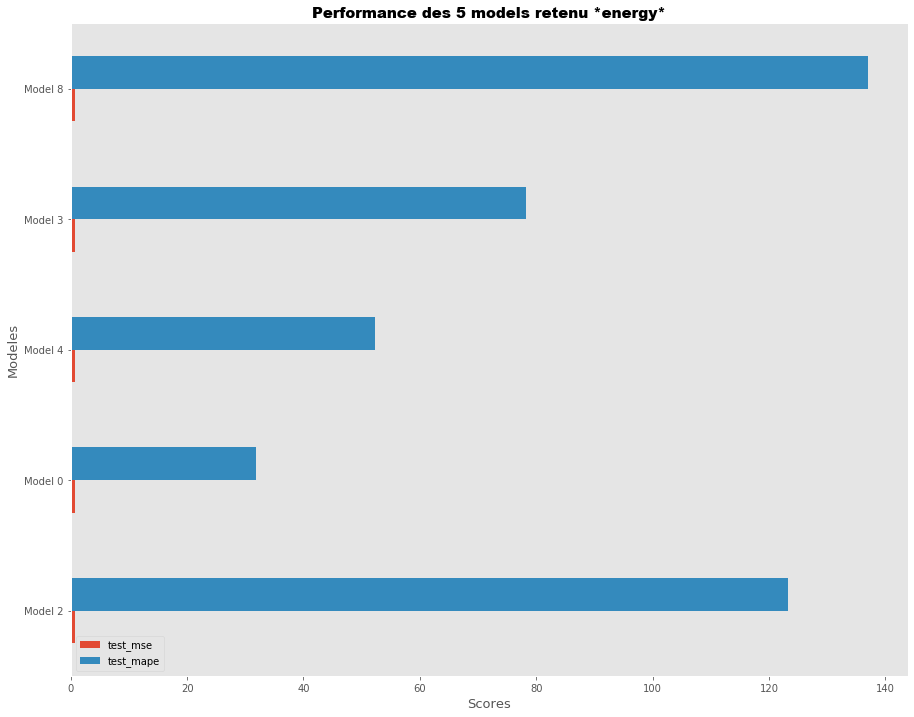

In [112]:
all_models_energy.plot(kind='barh', figsize=(15, 12)).grid()
plt.xlabel('Scores', fontsize=13)
plt.ylabel('Modeles', fontsize=13)
plt.title('Performance des 5 models retenu *energy*', fontname="Arial Black", size=15)

In [113]:
DfModelList = all_models_GHG
for i in range(len(DfModelList)):
    DfModelList[i]['description'] = "Model %d" % i

model_df = pd.DataFrame.from_dict(DfModelList)
all_models_GHG = model_df.set_index(['description']).sort_values('test_mse').head(5)
all_models_GHG[['test_mse', 'test_mape']] = np.abs(all_models_GHG[['test_mse', 'test_mape']])

Text(0.5, 1.0, 'Performance des 5 models retenu *GHG*')

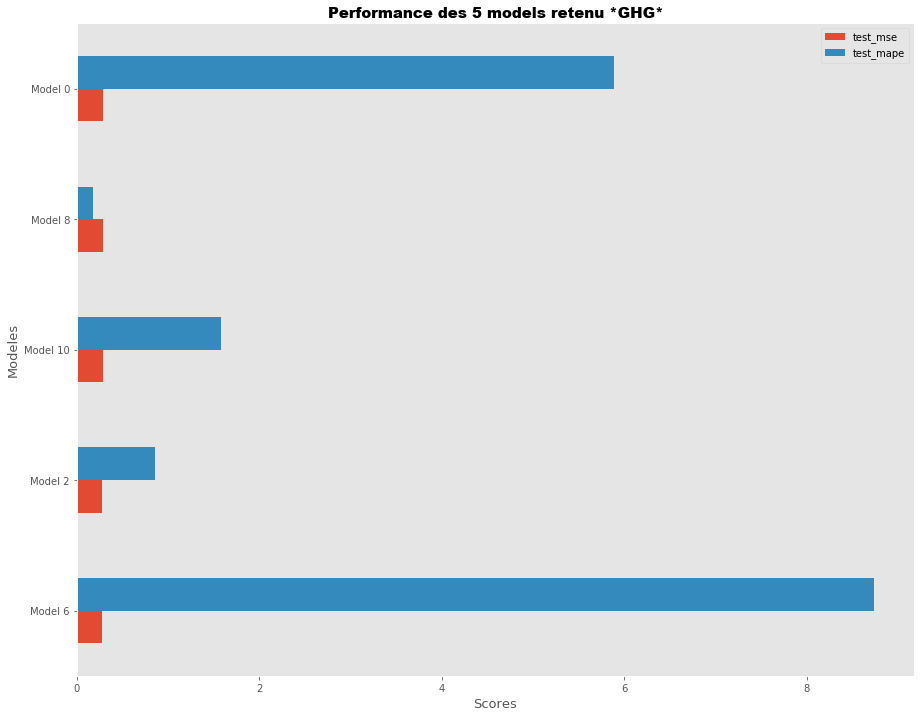

In [114]:
all_models_GHG.plot(kind='barh', figsize=(15, 12)).grid()
plt.xlabel('Scores', fontsize=13)
plt.ylabel('Modeles', fontsize=13)
plt.title('Performance des 5 models retenu *GHG*', fontname="Arial Black", size=15)

In [115]:
DfModelList = all_models_energy_unleaked
for i in range(len(DfModelList)):
    DfModelList[i]['description'] = "Model %d" % i

model_df = pd.DataFrame.from_dict(DfModelList)
all_models_energy_unleaked = model_df.set_index(['description']).sort_values('test_mse').head(5)
all_models_energy_unleaked[['test_mse', 'test_mape']] = np.abs(all_models_energy_unleaked[['test_mse', 'test_mape']])

Text(0.5, 1.0, 'Performance des 5 models retenu *Energy unleaked*')

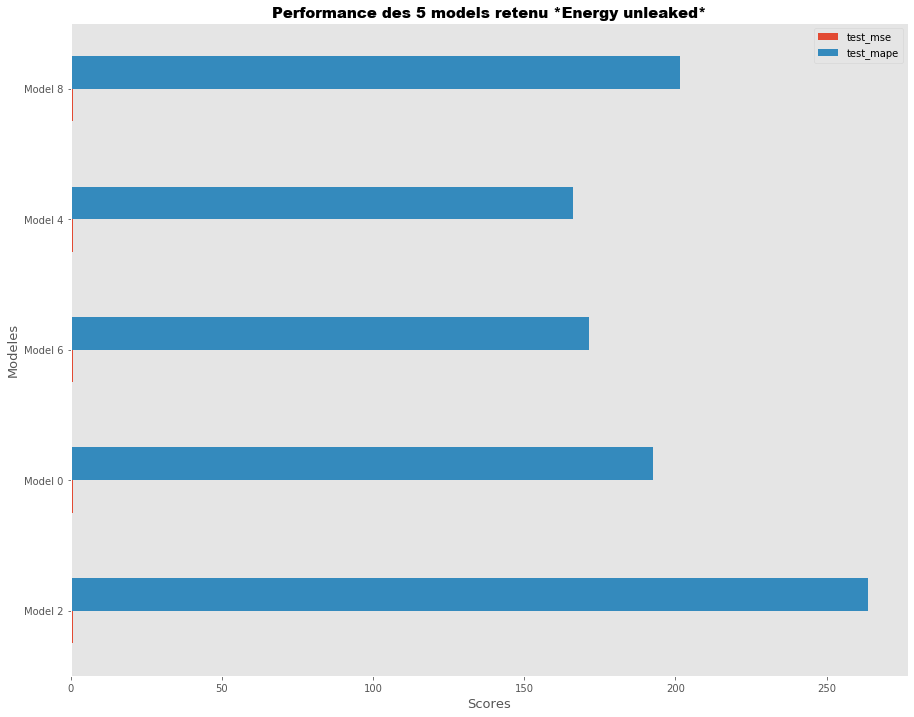

In [116]:
all_models_energy_unleaked.plot(kind='barh', figsize=(15, 12)).grid()
plt.xlabel('Scores', fontsize=13)
plt.ylabel('Modeles', fontsize=13)
plt.title('Performance des 5 models retenu *Energy unleaked*', fontname="Arial Black", size=15)

In [117]:
DfModelList = all_models_GHG_unleaked
for i in range(len(DfModelList)):
    DfModelList[i]['description'] = "Model %d" % i

model_df = pd.DataFrame.from_dict(DfModelList)
all_models_GHG_unleaked = model_df.set_index(['description']).sort_values('test_mse').head(5)
all_models_GHG_unleaked[['test_mse', 'test_mape']] = np.abs(all_models_GHG_unleaked[['test_mse', 'test_mape']])

Text(0.5, 1.0, 'Performance des 5 models retenu *GHG unleaked*')

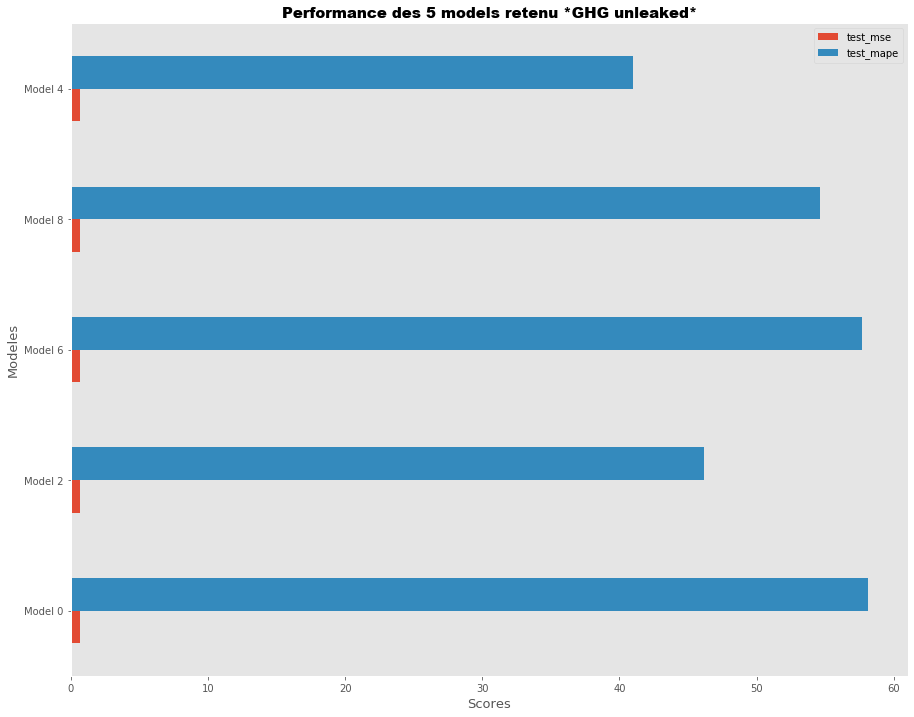

In [118]:
all_models_GHG_unleaked.plot(kind='barh', figsize=(15, 12)).grid()
plt.xlabel('Scores', fontsize=13)
plt.ylabel('Modeles', fontsize=13)
plt.title('Performance des 5 models retenu *GHG unleaked*', fontname="Arial Black", size=15)

In [135]:
all_models_GHG

model  test_mse  \
description                                                                
Model 6      <tensorflow.python.keras.engine.sequential.Seq...  0.273921   
Model 2      <tensorflow.python.keras.engine.sequential.Seq...  0.275406   
Model 10     <tensorflow.python.keras.engine.sequential.Seq...  0.281184   
Model 8      <tensorflow.python.keras.engine.sequential.Seq...  0.283713   
Model 0      <tensorflow.python.keras.engine.sequential.Seq...  0.283719   

             test_mape  
description             
Model 6       8.738252  
Model 2       0.851850  
Model 10      1.583054  
Model 8       0.172416  
Model 0       5.882085

### Avering models

Averaging the best 5 models on 10 iterations for each 4 groups of data input to have stronger data

In [127]:
Memory_DF = []
Memory_DF = pd.DataFrame(columns = ['description','test_mse','test_mape'], index = [0,1,2,3,4,5,6,7,8,9,10,11])
for i in range(len(Memory_DF['description'])):
    Memory_DF['description'][i] = "Model %d" % i
#Memory_DF = Memory_DF.set_index('description')
Memory_DF = Memory_DF.fillna(0)
Memory_models = {}
dataset_memory_models = []

In [128]:
for dataset in data_sets: 
    Memory_DF = Memory_DF.fillna(0)
    for i in range(5):
        all_models = []
        Df_models = all_models
        print("version %d of all_models :" % i, all_models)
        one_training_each(*dataset)

        for i in range(len(Df_models)):
            Memory_DF.loc[i, 'test_mse'] = np.divide(Memory_DF['test_mse'][i]+np.abs(Df_models[i]['test_mse']), 2)
            Memory_DF.loc[i,'test_mape'] = np.divide(Memory_DF['test_mape'][i]+ np.abs(Df_models[i]['test_mape']), 2)
            Memory_models['model %d' % i] = Df_models[i]['model']
            #Memory_DF_values.append([Df_models[i]['test_mse'], Df_models[i]['test_mape']])
    print("here is memory df : ", Memory_DF)
    dataset_memory_models.append([Memory_DF.copy(), Memory_models])

version 0 of all_models : []
--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 273us/sample - loss: 0.8357 - mae: 0.4858 - mape: 106.7873 - accuracy: 0.0000e+00 - val_loss: 0.7539 - val_mae: 0.4361 - val_mape: 206.7078 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6707 - mae: 0.3353 - mape: 176.1727 - accuracy: 0.0000e+00 - val_loss: 0.5988 - val_mae: 0.2907 - val_mape: 370.5769 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5853 - mae: 0.2571 - mape: 178.1881 - accuracy: 0.0000e+00 - val_loss: 0.5596 - val_mae: 0.2530 - val_mape: 387.5517 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5690 - mae: 0.2464 - mape: 164.6925 - accuracy: 0.0000e+00 - val_loss: 0.5

Epoch 6/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5452 - mae: 0.2457 - mape: 193.0765 - accuracy: 0.0000e+00 - val_loss: 0.5258 - val_mae: 0.2471 - val_mape: 477.1467 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.5451 - mae: 0.2477 - mape: 200.3831 - accuracy: 0.0000e+00 - val_loss: 0.5252 - val_mae: 0.2403 - val_mape: 467.9691 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5351 - mae: 0.2445 - mape: 207.7330 - accuracy: 0.0000e+00 - val_loss: 0.5293 - val_mae: 0.2417 - val_mape: 487.9789 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.5240 - mae: 0.2440 - mape: 185.1128 - accuracy: 0.0000e+00 - val_loss: 0.5279 - val_mae: 0.2344 - val_mape: 479.7854 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.5232 - mae: 0.2419

2620/2620 [==============================] - 0s 67us/sample - loss: 0.4758 - mae: 0.2483 - mape: 183.5257 - accuracy: 0.0000e+00 - val_loss: 0.5199 - val_mae: 0.2528 - val_mape: 544.0585 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4675 - mae: 0.2488 - mape: 186.3295 - accuracy: 0.0000e+00 - val_loss: 0.5796 - val_mae: 0.2635 - val_mape: 399.2340 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4318 - mae: 0.2511 - mape: 180.1078 - accuracy: 0.0000e+00 - val_loss: 0.7254 - val_mae: 0.2987 - val_mape: 505.0124 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4711 - mae: 0.2551 - mape: 164.6175 - accuracy: 0.0000e+00 - val_loss: 0.5735 - val_mae: 0.2566 - val_mape: 549.5729 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4231 - mae: 0.2422 - mape:

2620/2620 [==============================] - 0s 68us/sample - loss: 0.3718 - mae: 0.2169 - mape: 180.6256 - accuracy: 0.0000e+00 - val_loss: 0.6032 - val_mae: 0.2361 - val_mape: 392.0950 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3381 - mae: 0.2016 - mape: 167.3007 - accuracy: 0.0000e+00 - val_loss: 0.6954 - val_mae: 0.2613 - val_mape: 390.2499 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.2769 - mae: 0.1945 - mape: 136.0695 - accuracy: 0.0000e+00 - val_loss: 0.8134 - val_mae: 0.2861 - val_mape: 452.6069 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.3122 - mae: 0.2049 - mape: 149.9561 - accuracy: 0.0000e+00 - val_loss: 0.6987 - val_mae: 0.2600 - val_mape: 504.1137 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.3323 - mae: 0.1959 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 440us/sample - loss: 0.7044 - mae: 0.3712 - mape: 192.8554 - accuracy: 0.0000e+00 - val_loss: 0.5781 - val_mae: 0.3061 - val_mape: 481.5789 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6047 - mae: 0.2822 - mape: 189.4971 - accuracy: 0.0000e+00 - val_loss: 0.5497 - val_mae: 0.2685 - val_mape: 530.1960 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5839 - mae: 0.2721 - mape: 192.1042 - accuracy: 0.0000e+00 - val_loss: 0.5364 - val_mae: 0.2536 - val_mape: 533.2896 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.5749 - mae: 0.2624 - mape: 188.3246 - accuracy: 0.0000e+00 - val_loss: 0.5300 - val_mae: 0.2450 - val_mape: 507.2197 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 71us/sample - loss: 0.4956 - mae: 0.2362 - mape: 149.0829 - accuracy: 0.0000e+00 - val_loss: 0.5100 - val_mae: 0.2455 - val_mape: 416.2537 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.4928 - mae: 0.2408 - mape: 167.3727 - accuracy: 0.0000e+00 - val_loss: 0.5295 - val_mae: 0.2334 - val_mape: 351.6759 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4881 - mae: 0.2353 - mape: 162.8485 - accuracy: 0.0000e+00 - val_loss: 0.5171 - val_mae: 0.2415 - val_mape: 331.6978 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4659 - mae: 0.2257 - mape: 141.5045 - accuracy: 0.0000e+00 - val_loss: 0.5190 - val_mae: 0.2545 - val_mape: 441.4353 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4516 - mae: 0.2312 - mape:

2620/2620 [==============================] - 0s 68us/sample - loss: 0.4488 - mae: 0.2343 - mape: 182.2441 - accuracy: 0.0000e+00 - val_loss: 0.7384 - val_mae: 0.2598 - val_mape: 390.0042 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4550 - mae: 0.2314 - mape: 166.6297 - accuracy: 0.0000e+00 - val_loss: 0.5880 - val_mae: 0.2417 - val_mape: 245.9655 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4105 - mae: 0.2194 - mape: 196.9082 - accuracy: 0.0000e+00 - val_loss: 0.5951 - val_mae: 0.2366 - val_mape: 230.3675 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.3985 - mae: 0.2168 - mape: 155.0933 - accuracy: 0.0000e+00 - val_loss: 0.7065 - val_mae: 0.2631 - val_mape: 349.4382 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.4121 - mae: 0.2219 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 276us/sample - loss: 0.8633 - mae: 0.5115 - mape: 111.0909 - accuracy: 0.0000e+00 - val_loss: 0.7479 - val_mae: 0.4382 - val_mape: 199.2904 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6546 - mae: 0.3290 - mape: 206.3745 - accuracy: 0.0000e+00 - val_loss: 0.5933 - val_mae: 0.3013 - val_mape: 364.1753 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5925 - mae: 0.2768 - mape: 215.7251 - accuracy: 0.0000e+00 - val_loss: 0.5635 - val_mae: 0.2721 - val_mape: 412.8416 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 52us/sample - loss: 0.5783 - mae: 0.2682 - mape: 195.9423 - accuracy: 0.0000e+00 - val_loss: 0.5468 - val_mae: 0.2589 - val_mape: 422.6997 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 59us/sample - loss: 0.5281 - mae: 0.2376 - mape: 196.6786 - accuracy: 0.0000e+00 - val_loss: 0.5040 - val_mae: 0.2400 - val_mape: 630.1885 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5246 - mae: 0.2330 - mape: 208.0258 - accuracy: 0.0000e+00 - val_loss: 0.5055 - val_mae: 0.2352 - val_mape: 569.7925 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5193 - mae: 0.2351 - mape: 192.7171 - accuracy: 0.0000e+00 - val_loss: 0.5061 - val_mae: 0.2425 - val_mape: 586.9379 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5148 - mae: 0.2381 - mape: 177.2997 - accuracy: 0.0000e+00 - val_loss: 0.5044 - val_mae: 0.2445 - val_mape: 571.8726 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5099 - mae: 0.2340 - mape:

2620/2620 [==============================] - 0s 57us/sample - loss: 0.5019 - mae: 0.2403 - mape: 180.6853 - accuracy: 0.0000e+00 - val_loss: 0.5056 - val_mae: 0.2449 - val_mape: 577.2769 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5035 - mae: 0.2410 - mape: 184.0081 - accuracy: 0.0000e+00 - val_loss: 0.5096 - val_mae: 0.2511 - val_mape: 573.3209 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4947 - mae: 0.2403 - mape: 187.6917 - accuracy: 0.0000e+00 - val_loss: 0.5119 - val_mae: 0.2530 - val_mape: 550.1307 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4935 - mae: 0.2424 - mape: 189.3467 - accuracy: 0.0000e+00 - val_loss: 0.5109 - val_mae: 0.2431 - val_mape: 507.5244 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4835 - mae: 0.2391 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 476us/sample - loss: 0.7209 - mae: 0.3790 - mape: 173.9078 - accuracy: 0.0000e+00 - val_loss: 0.6189 - val_mae: 0.3470 - val_mape: 426.0308 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6003 - mae: 0.2815 - mape: 195.8293 - accuracy: 0.0000e+00 - val_loss: 0.5354 - val_mae: 0.2572 - val_mape: 567.1365 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5840 - mae: 0.2624 - mape: 172.8403 - accuracy: 0.0000e+00 - val_loss: 0.5298 - val_mae: 0.2471 - val_mape: 565.3011 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5640 - mae: 0.2532 - mape: 179.4885 - accuracy: 0.0000e+00 - val_loss: 0.5292 - val_mae: 0.2465 - val_mape: 562.3751 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 70us/sample - loss: 0.5492 - mae: 0.2568 - mape: 167.3451 - accuracy: 0.0000e+00 - val_loss: 0.5810 - val_mae: 0.2909 - val_mape: 362.4002 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5470 - mae: 0.2698 - mape: 174.8212 - accuracy: 0.0000e+00 - val_loss: 0.5622 - val_mae: 0.2815 - val_mape: 482.1493 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4899 - mae: 0.2469 - mape: 182.4428 - accuracy: 0.0000e+00 - val_loss: 0.5353 - val_mae: 0.2403 - val_mape: 264.6585 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4728 - mae: 0.2362 - mape: 161.2789 - accuracy: 0.0000e+00 - val_loss: 0.5433 - val_mae: 0.2375 - val_mape: 297.1264 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4711 - mae: 0.2338 - mape:

2620/2620 [==============================] - 0s 63us/sample - loss: 0.4375 - mae: 0.2283 - mape: 187.0004 - accuracy: 0.0000e+00 - val_loss: 0.5682 - val_mae: 0.2542 - val_mape: 356.3888 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4053 - mae: 0.2340 - mape: 170.5873 - accuracy: 0.0000e+00 - val_loss: 0.5747 - val_mae: 0.2549 - val_mape: 431.9314 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.3966 - mae: 0.2256 - mape: 159.9142 - accuracy: 0.0000e+00 - val_loss: 0.5619 - val_mae: 0.2578 - val_mape: 367.5316 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4061 - mae: 0.2305 - mape: 185.0301 - accuracy: 0.0000e+00 - val_loss: 0.5874 - val_mae: 0.2489 - val_mape: 246.3048 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4081 - mae: 0.2334 - mape:

2620/2620 [==============================] - 0s 71us/sample - loss: 0.3728 - mae: 0.2208 - mape: 164.7203 - accuracy: 0.0000e+00 - val_loss: 0.5487 - val_mae: 0.2428 - val_mape: 308.1641 - val_accuracy: 0.0000e+00
accuracy here is :  0.7407706247746767
--- Starting trial: logs/fit/run-4
{'num_units': 128, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 277us/sample - loss: 0.8117 - mae: 0.4647 - mape: 134.2473 - accuracy: 0.0000e+00 - val_loss: 0.6656 - val_mae: 0.3655 - val_mape: 245.2606 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.6014 - mae: 0.2756 - mape: 176.1316 - accuracy: 0.0000e+00 - val_loss: 0.5886 - val_mae: 0.2869 - val_mape: 289.4745 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5766 - mae: 0.2586 - mape: 185.1987 - accuracy: 0.0000e+00 - val_loss: 0.5

Epoch 5/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5504 - mae: 0.2509 - mape: 188.7872 - accuracy: 0.0000e+00 - val_loss: 0.5320 - val_mae: 0.2474 - val_mape: 551.5516 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5406 - mae: 0.2459 - mape: 183.1360 - accuracy: 0.0000e+00 - val_loss: 0.5269 - val_mae: 0.2366 - val_mape: 583.1696 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5333 - mae: 0.2428 - mape: 189.8627 - accuracy: 0.0000e+00 - val_loss: 0.5305 - val_mae: 0.2422 - val_mape: 537.2298 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5219 - mae: 0.2433 - mape: 189.8210 - accuracy: 0.0000e+00 - val_loss: 0.5286 - val_mae: 0.2383 - val_mape: 527.4922 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5085 - mae: 0.2401 

2620/2620 [==============================] - 0s 63us/sample - loss: 0.4699 - mae: 0.2383 - mape: 149.0161 - accuracy: 0.0000e+00 - val_loss: 0.5488 - val_mae: 0.2558 - val_mape: 400.2093 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4648 - mae: 0.2359 - mape: 160.5782 - accuracy: 0.0000e+00 - val_loss: 0.5423 - val_mae: 0.2500 - val_mape: 352.7163 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4637 - mae: 0.2383 - mape: 156.8921 - accuracy: 0.0000e+00 - val_loss: 0.5609 - val_mae: 0.2721 - val_mape: 410.5280 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4642 - mae: 0.2455 - mape: 180.0198 - accuracy: 0.0000e+00 - val_loss: 0.6308 - val_mae: 0.2698 - val_mape: 352.2184 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4901 - mae: 0.2379 - mape:

2620/2620 [==============================] - 0s 69us/sample - loss: 0.3338 - mae: 0.1939 - mape: 134.3520 - accuracy: 0.0000e+00 - val_loss: 0.7134 - val_mae: 0.2499 - val_mape: 285.0392 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3426 - mae: 0.2019 - mape: 133.6852 - accuracy: 0.0000e+00 - val_loss: 0.6964 - val_mae: 0.2677 - val_mape: 206.4785 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3550 - mae: 0.1988 - mape: 148.2200 - accuracy: 0.0000e+00 - val_loss: 0.7049 - val_mae: 0.2507 - val_mape: 272.8973 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.3137 - mae: 0.1975 - mape: 143.6186 - accuracy: 0.0000e+00 - val_loss: 0.8223 - val_mae: 0.2609 - val_mape: 377.6507 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.2956 - mae: 0.1915 - mape:

Epoch 4/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5736 - mae: 0.2548 - mape: 184.0583 - accuracy: 0.0000e+00 - val_loss: 0.5474 - val_mae: 0.2557 - val_mape: 475.3113 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5631 - mae: 0.2492 - mape: 185.6575 - accuracy: 0.0000e+00 - val_loss: 0.5323 - val_mae: 0.2411 - val_mape: 511.0076 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5537 - mae: 0.2449 - mape: 183.6408 - accuracy: 0.0000e+00 - val_loss: 0.5273 - val_mae: 0.2400 - val_mape: 550.4799 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5488 - mae: 0.2408 - mape: 187.2388 - accuracy: 0.0000e+00 - val_loss: 0.5254 - val_mae: 0.2382 - val_mape: 565.8434 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5454 - mae: 0.2448 

2620/2620 [==============================] - 0s 56us/sample - loss: 0.5322 - mae: 0.2467 - mape: 184.8034 - accuracy: 0.0000e+00 - val_loss: 0.5143 - val_mae: 0.2453 - val_mape: 544.2011 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5301 - mae: 0.2511 - mape: 194.0102 - accuracy: 0.0000e+00 - val_loss: 0.5144 - val_mae: 0.2453 - val_mape: 567.0621 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5241 - mae: 0.2466 - mape: 193.8305 - accuracy: 0.0000e+00 - val_loss: 0.5174 - val_mae: 0.2486 - val_mape: 533.3035 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5264 - mae: 0.2488 - mape: 214.8363 - accuracy: 0.0000e+00 - val_loss: 0.5149 - val_mae: 0.2448 - val_mape: 550.1055 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5303 - mae: 0.2468 - mape:

2620/2620 [==============================] - 0s 54us/sample - loss: 0.4785 - mae: 0.2301 - mape: 189.3654 - accuracy: 0.0000e+00 - val_loss: 0.5358 - val_mae: 0.2393 - val_mape: 447.6137 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4680 - mae: 0.2283 - mape: 175.7156 - accuracy: 0.0000e+00 - val_loss: 0.5354 - val_mae: 0.2361 - val_mape: 447.9272 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4630 - mae: 0.2281 - mape: 191.0389 - accuracy: 0.0000e+00 - val_loss: 0.5391 - val_mae: 0.2397 - val_mape: 450.0347 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4592 - mae: 0.2294 - mape: 192.8304 - accuracy: 0.0000e+00 - val_loss: 0.5406 - val_mae: 0.2433 - val_mape: 449.0555 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4510 - mae: 0.2274 - mape:

Epoch 4/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5695 - mae: 0.2591 - mape: 195.7338 - accuracy: 0.0000e+00 - val_loss: 0.5367 - val_mae: 0.2557 - val_mape: 516.3693 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5626 - mae: 0.2594 - mape: 184.0368 - accuracy: 0.0000e+00 - val_loss: 0.5328 - val_mae: 0.2494 - val_mape: 523.6019 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5474 - mae: 0.2583 - mape: 199.5343 - accuracy: 0.0000e+00 - val_loss: 0.5332 - val_mae: 0.2471 - val_mape: 519.5839 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5409 - mae: 0.2554 - mape: 181.1606 - accuracy: 0.0000e+00 - val_loss: 0.5316 - val_mae: 0.2448 - val_mape: 573.2786 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5486 - mae: 0.2589 

2620/2620 [==============================] - 0s 75us/sample - loss: 0.4529 - mae: 0.2327 - mape: 173.7858 - accuracy: 0.0000e+00 - val_loss: 0.5590 - val_mae: 0.2704 - val_mape: 340.4238 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4210 - mae: 0.2308 - mape: 159.8261 - accuracy: 0.0000e+00 - val_loss: 0.5383 - val_mae: 0.2338 - val_mape: 354.2331 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4274 - mae: 0.2293 - mape: 162.6649 - accuracy: 0.0000e+00 - val_loss: 0.8010 - val_mae: 0.2822 - val_mape: 447.8866 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4067 - mae: 0.2332 - mape: 146.3997 - accuracy: 0.0000e+00 - val_loss: 0.5563 - val_mae: 0.2507 - val_mape: 466.8726 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4251 - mae: 0.2478 - mape:

2620/2620 [==============================] - 0s 70us/sample - loss: 0.3734 - mae: 0.2122 - mape: 177.3843 - accuracy: 0.0000e+00 - val_loss: 0.7526 - val_mae: 0.2562 - val_mape: 349.5870 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3892 - mae: 0.2191 - mape: 177.7007 - accuracy: 0.0000e+00 - val_loss: 0.7859 - val_mae: 0.2956 - val_mape: 301.4125 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.3480 - mae: 0.2099 - mape: 164.8505 - accuracy: 0.0000e+00 - val_loss: 0.7264 - val_mae: 0.2608 - val_mape: 235.4362 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.3375 - mae: 0.2095 - mape: 161.1813 - accuracy: 0.0000e+00 - val_loss: 0.8557 - val_mae: 0.3173 - val_mape: 262.5308 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.3164 - mae: 0.1975 - mape:

Epoch 3/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6171 - mae: 0.2892 - mape: 207.2009 - accuracy: 0.0000e+00 - val_loss: 0.5811 - val_mae: 0.2791 - val_mape: 414.4205 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5747 - mae: 0.2616 - mape: 200.1978 - accuracy: 0.0000e+00 - val_loss: 0.5486 - val_mae: 0.2488 - val_mape: 461.5972 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5653 - mae: 0.2564 - mape: 190.5801 - accuracy: 0.0000e+00 - val_loss: 0.5441 - val_mae: 0.2520 - val_mape: 479.9731 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5675 - mae: 0.2568 - mape: 202.3812 - accuracy: 0.0000e+00 - val_loss: 0.5310 - val_mae: 0.2444 - val_mape: 552.6182 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5561 - mae: 0.2506 

2620/2620 [==============================] - 0s 59us/sample - loss: 0.5206 - mae: 0.2378 - mape: 181.4100 - accuracy: 0.0000e+00 - val_loss: 0.5040 - val_mae: 0.2354 - val_mape: 591.8700 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5148 - mae: 0.2335 - mape: 203.9495 - accuracy: 0.0000e+00 - val_loss: 0.5059 - val_mae: 0.2385 - val_mape: 564.5885 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5104 - mae: 0.2338 - mape: 179.3598 - accuracy: 0.0000e+00 - val_loss: 0.5061 - val_mae: 0.2421 - val_mape: 563.4645 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5090 - mae: 0.2339 - mape: 183.8026 - accuracy: 0.0000e+00 - val_loss: 0.5062 - val_mae: 0.2371 - val_mape: 546.2935 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5025 - mae: 0.2300 - mape:

2620/2620 [==============================] - 0s 59us/sample - loss: 0.4997 - mae: 0.2430 - mape: 195.8065 - accuracy: 0.0000e+00 - val_loss: 0.5273 - val_mae: 0.2372 - val_mape: 413.0337 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4957 - mae: 0.2410 - mape: 185.3926 - accuracy: 0.0000e+00 - val_loss: 0.5292 - val_mae: 0.2450 - val_mape: 420.5162 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4979 - mae: 0.2380 - mape: 185.9688 - accuracy: 0.0000e+00 - val_loss: 0.5347 - val_mae: 0.2432 - val_mape: 392.6780 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4794 - mae: 0.2411 - mape: 172.9808 - accuracy: 0.0000e+00 - val_loss: 0.5330 - val_mae: 0.2382 - val_mape: 386.7130 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4736 - mae: 0.2360 - mape:

Epoch 3/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.5725 - mae: 0.2545 - mape: 174.4894 - accuracy: 0.0000e+00 - val_loss: 0.5298 - val_mae: 0.2486 - val_mape: 560.6063 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.5594 - mae: 0.2477 - mape: 188.3404 - accuracy: 0.0000e+00 - val_loss: 0.5327 - val_mae: 0.2473 - val_mape: 524.8444 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5424 - mae: 0.2413 - mape: 179.4154 - accuracy: 0.0000e+00 - val_loss: 0.5294 - val_mae: 0.2370 - val_mape: 547.1218 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5341 - mae: 0.2393 - mape: 178.5728 - accuracy: 0.0000e+00 - val_loss: 0.5297 - val_mae: 0.2372 - val_mape: 560.5140 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5206 - mae: 0.2375 

2620/2620 [==============================] - 0s 68us/sample - loss: 0.5338 - mae: 0.2448 - mape: 158.0731 - accuracy: 0.0000e+00 - val_loss: 0.5491 - val_mae: 0.2465 - val_mape: 239.8230 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.5268 - mae: 0.2590 - mape: 163.7488 - accuracy: 0.0000e+00 - val_loss: 0.5473 - val_mae: 0.2604 - val_mape: 484.4310 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4917 - mae: 0.2447 - mape: 169.1922 - accuracy: 0.0000e+00 - val_loss: 0.5500 - val_mae: 0.2514 - val_mape: 293.2536 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4667 - mae: 0.2342 - mape: 165.6344 - accuracy: 0.0000e+00 - val_loss: 0.5482 - val_mae: 0.2497 - val_mape: 301.1548 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4602 - mae: 0.2332 - mape:

2620/2620 [==============================] - 0s 70us/sample - loss: 0.5599 - mae: 0.3209 - mape: 243.3479 - accuracy: 0.0000e+00 - val_loss: 0.6438 - val_mae: 0.3545 - val_mape: 880.9076 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5468 - mae: 0.3204 - mape: 250.2628 - accuracy: 0.0000e+00 - val_loss: 0.6779 - val_mae: 0.3539 - val_mape: 940.2538 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5461 - mae: 0.3218 - mape: 258.4133 - accuracy: 0.0000e+00 - val_loss: 0.6756 - val_mae: 0.3555 - val_mape: 946.8266 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.5334 - mae: 0.3180 - mape: 243.1063 - accuracy: 0.0000e+00 - val_loss: 0.7589 - val_mae: 0.3619 - val_mape: 924.8011 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5442 - mae: 0.3153 - mape:

2620/2620 [==============================] - 0s 65us/sample - loss: 0.5519 - mae: 0.3214 - mape: 255.2822 - accuracy: 0.0000e+00 - val_loss: 0.7451 - val_mae: 0.3585 - val_mape: 988.8899 - val_accuracy: 0.0000e+00
accuracy here is :  0.863174013866142
--- Starting trial: logs/fit/run-4
{'num_units': 128, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 272us/sample - loss: 0.9085 - mae: 0.5285 - mape: 126.4665 - accuracy: 0.0000e+00 - val_loss: 0.7557 - val_mae: 0.4382 - val_mape: 343.3805 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.7248 - mae: 0.3805 - mape: 252.4526 - accuracy: 0.0000e+00 - val_loss: 0.6588 - val_mae: 0.3655 - val_mape: 667.3384 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.6848 - mae: 0.3491 - mape: 293.8784 - accuracy: 0.0000e+00 - val_loss: 0.63

Epoch 5/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6492 - mae: 0.3439 - mape: 265.0883 - accuracy: 0.0000e+00 - val_loss: 0.6004 - val_mae: 0.3526 - val_mape: 972.9032 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.6382 - mae: 0.3413 - mape: 253.4370 - accuracy: 0.0000e+00 - val_loss: 0.5959 - val_mae: 0.3545 - val_mape: 1001.3672 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6322 - mae: 0.3406 - mape: 254.7055 - accuracy: 0.0000e+00 - val_loss: 0.5867 - val_mae: 0.3467 - val_mape: 995.9348 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6263 - mae: 0.3390 - mape: 266.6444 - accuracy: 0.0000e+00 - val_loss: 0.5933 - val_mae: 0.3517 - val_mape: 932.8719 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6134 - mae: 0.3337

2620/2620 [==============================] - 0s 65us/sample - loss: 0.5903 - mae: 0.3292 - mape: 254.0683 - accuracy: 0.0000e+00 - val_loss: 0.6267 - val_mae: 0.3560 - val_mape: 868.2259 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5838 - mae: 0.3255 - mape: 226.1240 - accuracy: 0.0000e+00 - val_loss: 0.6277 - val_mae: 0.3456 - val_mape: 741.2384 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.5857 - mae: 0.3333 - mape: 239.8519 - accuracy: 0.0000e+00 - val_loss: 0.6374 - val_mae: 0.3544 - val_mape: 778.7650 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5740 - mae: 0.3286 - mape: 248.7671 - accuracy: 0.0000e+00 - val_loss: 0.6555 - val_mae: 0.3542 - val_mape: 801.0815 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5664 - mae: 0.3244 - mape:

2620/2620 [==============================] - 0s 69us/sample - loss: 0.4981 - mae: 0.3039 - mape: 250.4859 - accuracy: 0.0000e+00 - val_loss: 0.6679 - val_mae: 0.3557 - val_mape: 374.2258 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5015 - mae: 0.3000 - mape: 230.6777 - accuracy: 0.0000e+00 - val_loss: 1.0154 - val_mae: 0.3740 - val_mape: 618.2197 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5317 - mae: 0.3082 - mape: 243.4871 - accuracy: 0.0000e+00 - val_loss: 0.6824 - val_mae: 0.3592 - val_mape: 346.6705 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5091 - mae: 0.3052 - mape: 254.8823 - accuracy: 0.0000e+00 - val_loss: 0.8357 - val_mae: 0.3786 - val_mape: 627.7872 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.4950 - mae: 0.3026 - mape:

Epoch 4/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6737 - mae: 0.3463 - mape: 311.5860 - accuracy: 0.0000e+00 - val_loss: 0.6186 - val_mae: 0.3479 - val_mape: 894.2566 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6613 - mae: 0.3434 - mape: 320.6935 - accuracy: 0.0000e+00 - val_loss: 0.6051 - val_mae: 0.3439 - val_mape: 976.0939 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6583 - mae: 0.3412 - mape: 312.1955 - accuracy: 0.0000e+00 - val_loss: 0.5997 - val_mae: 0.3451 - val_mape: 1033.1022 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.6442 - mae: 0.3362 - mape: 313.7877 - accuracy: 0.0000e+00 - val_loss: 0.5885 - val_mae: 0.3408 - val_mape: 1037.9120 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6425 - mae: 0.336

2620/2620 [==============================] - 0s 55us/sample - loss: 0.6312 - mae: 0.3362 - mape: 315.0876 - accuracy: 0.0000e+00 - val_loss: 0.5786 - val_mae: 0.3392 - val_mape: 1113.0427 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6314 - mae: 0.3363 - mape: 306.4763 - accuracy: 0.0000e+00 - val_loss: 0.5778 - val_mae: 0.3397 - val_mape: 1150.5076 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6243 - mae: 0.3350 - mape: 302.9817 - accuracy: 0.0000e+00 - val_loss: 0.5765 - val_mae: 0.3403 - val_mape: 1163.6521 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6281 - mae: 0.3326 - mape: 307.2100 - accuracy: 0.0000e+00 - val_loss: 0.5788 - val_mae: 0.3418 - val_mape: 1130.2710 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6199 - mae: 0.3330 - m

2620/2620 [==============================] - 0s 58us/sample - loss: 0.5905 - mae: 0.3220 - mape: 262.5423 - accuracy: 0.0000e+00 - val_loss: 0.5703 - val_mae: 0.3409 - val_mape: 904.7285 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5835 - mae: 0.3231 - mape: 284.7914 - accuracy: 0.0000e+00 - val_loss: 0.5699 - val_mae: 0.3404 - val_mape: 912.5625 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5863 - mae: 0.3226 - mape: 296.9274 - accuracy: 0.0000e+00 - val_loss: 0.5727 - val_mae: 0.3413 - val_mape: 899.9827 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5819 - mae: 0.3257 - mape: 283.8088 - accuracy: 0.0000e+00 - val_loss: 0.5730 - val_mae: 0.3426 - val_mape: 904.1746 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5782 - mae: 0.3207 - mape:

Epoch 4/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.6555 - mae: 0.3476 - mape: 254.9659 - accuracy: 0.0000e+00 - val_loss: 0.5952 - val_mae: 0.3433 - val_mape: 967.6887 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6509 - mae: 0.3492 - mape: 263.6209 - accuracy: 0.0000e+00 - val_loss: 0.6064 - val_mae: 0.3615 - val_mape: 913.9147 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.6396 - mae: 0.3431 - mape: 265.6385 - accuracy: 0.0000e+00 - val_loss: 0.6014 - val_mae: 0.3577 - val_mape: 937.3373 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6339 - mae: 0.3418 - mape: 254.5908 - accuracy: 0.0000e+00 - val_loss: 0.5958 - val_mae: 0.3525 - val_mape: 930.5175 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.6248 - mae: 0.3365 

2620/2620 [==============================] - 0s 70us/sample - loss: 0.5784 - mae: 0.3214 - mape: 235.4344 - accuracy: 0.0000e+00 - val_loss: 0.6376 - val_mae: 0.3522 - val_mape: 824.2816 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.5732 - mae: 0.3217 - mape: 248.1222 - accuracy: 0.0000e+00 - val_loss: 0.6470 - val_mae: 0.3538 - val_mape: 776.0219 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5609 - mae: 0.3186 - mape: 254.5932 - accuracy: 0.0000e+00 - val_loss: 0.6573 - val_mae: 0.3566 - val_mape: 869.1306 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5568 - mae: 0.3236 - mape: 246.5297 - accuracy: 0.0000e+00 - val_loss: 0.7003 - val_mae: 0.3576 - val_mape: 802.3913 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5542 - mae: 0.3193 - mape:

2620/2620 [==============================] - 0s 68us/sample - loss: 0.5463 - mae: 0.3249 - mape: 265.8375 - accuracy: 0.0000e+00 - val_loss: 0.8055 - val_mae: 0.3758 - val_mape: 781.1437 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5262 - mae: 0.3079 - mape: 249.4646 - accuracy: 0.0000e+00 - val_loss: 0.8185 - val_mae: 0.3706 - val_mape: 499.4870 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5117 - mae: 0.3110 - mape: 259.6194 - accuracy: 0.0000e+00 - val_loss: 0.8854 - val_mae: 0.3787 - val_mape: 681.9843 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4992 - mae: 0.3084 - mape: 265.3995 - accuracy: 0.0000e+00 - val_loss: 0.8133 - val_mae: 0.3675 - val_mape: 495.1058 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4923 - mae: 0.3037 - mape:

Epoch 3/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.6975 - mae: 0.3635 - mape: 273.1278 - accuracy: 0.0000e+00 - val_loss: 0.6334 - val_mae: 0.3578 - val_mape: 781.6040 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.6779 - mae: 0.3552 - mape: 285.5242 - accuracy: 0.0000e+00 - val_loss: 0.6143 - val_mae: 0.3500 - val_mape: 891.8442 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6751 - mae: 0.3501 - mape: 315.6053 - accuracy: 0.0000e+00 - val_loss: 0.6059 - val_mae: 0.3477 - val_mape: 953.0776 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6623 - mae: 0.3484 - mape: 321.4508 - accuracy: 0.0000e+00 - val_loss: 0.5997 - val_mae: 0.3477 - val_mape: 1012.7106 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6545 - mae: 0.3480

2620/2620 [==============================] - 0s 56us/sample - loss: 0.6113 - mae: 0.3271 - mape: 323.0969 - accuracy: 0.0000e+00 - val_loss: 0.5722 - val_mae: 0.3438 - val_mape: 1065.3687 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6081 - mae: 0.3279 - mape: 294.7892 - accuracy: 0.0000e+00 - val_loss: 0.5701 - val_mae: 0.3417 - val_mape: 1052.2019 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6088 - mae: 0.3252 - mape: 285.6139 - accuracy: 0.0000e+00 - val_loss: 0.5688 - val_mae: 0.3418 - val_mape: 1045.9255 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6085 - mae: 0.3240 - mape: 281.1641 - accuracy: 0.0000e+00 - val_loss: 0.5715 - val_mae: 0.3418 - val_mape: 995.9916 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6015 - mae: 0.3277 - ma

2620/2620 [==============================] - 0s 57us/sample - loss: 0.5885 - mae: 0.3275 - mape: 289.1813 - accuracy: 0.0000e+00 - val_loss: 0.5739 - val_mae: 0.3384 - val_mape: 911.9161 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5957 - mae: 0.3304 - mape: 290.4675 - accuracy: 0.0000e+00 - val_loss: 0.5747 - val_mae: 0.3412 - val_mape: 908.5263 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5962 - mae: 0.3298 - mape: 271.6786 - accuracy: 0.0000e+00 - val_loss: 0.5761 - val_mae: 0.3367 - val_mape: 894.9849 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5894 - mae: 0.3249 - mape: 261.1111 - accuracy: 0.0000e+00 - val_loss: 0.5774 - val_mae: 0.3386 - val_mape: 903.0134 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5919 - mae: 0.3278 - mape:

Epoch 3/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.6688 - mae: 0.3547 - mape: 275.9926 - accuracy: 0.0000e+00 - val_loss: 0.6222 - val_mae: 0.3700 - val_mape: 914.8755 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 76us/sample - loss: 0.6558 - mae: 0.3477 - mape: 260.2831 - accuracy: 0.0000e+00 - val_loss: 0.6163 - val_mae: 0.3679 - val_mape: 987.4096 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6384 - mae: 0.3430 - mape: 275.7652 - accuracy: 0.0000e+00 - val_loss: 0.5918 - val_mae: 0.3452 - val_mape: 957.0392 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.6348 - mae: 0.3407 - mape: 258.8495 - accuracy: 0.0000e+00 - val_loss: 0.6013 - val_mae: 0.3508 - val_mape: 860.7256 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.6204 - mae: 0.3346 

2620/2620 [==============================] - 0s 70us/sample - loss: 0.5850 - mae: 0.3291 - mape: 251.1873 - accuracy: 0.0000e+00 - val_loss: 0.6084 - val_mae: 0.3483 - val_mape: 792.1451 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5957 - mae: 0.3326 - mape: 250.1922 - accuracy: 0.0000e+00 - val_loss: 0.6208 - val_mae: 0.3505 - val_mape: 857.8853 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5818 - mae: 0.3279 - mape: 239.8739 - accuracy: 0.0000e+00 - val_loss: 0.6246 - val_mae: 0.3486 - val_mape: 728.4737 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5762 - mae: 0.3265 - mape: 255.8961 - accuracy: 0.0000e+00 - val_loss: 0.6486 - val_mae: 0.3614 - val_mape: 865.3337 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5564 - mae: 0.3256 - mape:

2620/2620 [==============================] - 0s 68us/sample - loss: 0.5583 - mae: 0.3237 - mape: 226.8230 - accuracy: 0.0000e+00 - val_loss: 0.6645 - val_mae: 0.3586 - val_mape: 937.4001 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5551 - mae: 0.3231 - mape: 250.2557 - accuracy: 0.0000e+00 - val_loss: 0.6709 - val_mae: 0.3591 - val_mape: 911.4852 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5495 - mae: 0.3273 - mape: 263.7297 - accuracy: 0.0000e+00 - val_loss: 0.6947 - val_mae: 0.3602 - val_mape: 1087.7112 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5326 - mae: 0.3220 - mape: 261.0988 - accuracy: 0.0000e+00 - val_loss: 0.7285 - val_mae: 0.3701 - val_mape: 989.3749 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5357 - mae: 0.3239 - mape

Epoch 2/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.7259 - mae: 0.3814 - mape: 253.2513 - accuracy: 0.0000e+00 - val_loss: 0.6511 - val_mae: 0.3626 - val_mape: 660.9875 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6786 - mae: 0.3498 - mape: 291.1406 - accuracy: 0.0000e+00 - val_loss: 0.6212 - val_mae: 0.3500 - val_mape: 807.7371 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6666 - mae: 0.3440 - mape: 302.7672 - accuracy: 0.0000e+00 - val_loss: 0.6085 - val_mae: 0.3477 - val_mape: 901.3527 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6529 - mae: 0.3437 - mape: 298.6388 - accuracy: 0.0000e+00 - val_loss: 0.5978 - val_mae: 0.3441 - val_mape: 962.3397 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6433 - mae: 0.3385 

2620/2620 [==============================] - 0s 57us/sample - loss: 0.6335 - mae: 0.3380 - mape: 309.0239 - accuracy: 0.0000e+00 - val_loss: 0.5799 - val_mae: 0.3447 - val_mape: 1043.3346 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6288 - mae: 0.3390 - mape: 312.9118 - accuracy: 0.0000e+00 - val_loss: 0.5749 - val_mae: 0.3394 - val_mape: 1012.7933 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6272 - mae: 0.3331 - mape: 313.2721 - accuracy: 0.0000e+00 - val_loss: 0.5783 - val_mae: 0.3425 - val_mape: 1018.9638 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6160 - mae: 0.3312 - mape: 295.4391 - accuracy: 0.0000e+00 - val_loss: 0.5766 - val_mae: 0.3406 - val_mape: 987.2819 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6243 - mae: 0.3365 - ma

2620/2620 [==============================] - 0s 65us/sample - loss: 0.5856 - mae: 0.3243 - mape: 277.4557 - accuracy: 0.0000e+00 - val_loss: 0.5811 - val_mae: 0.3472 - val_mape: 815.4103 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.5823 - mae: 0.3251 - mape: 293.1256 - accuracy: 0.0000e+00 - val_loss: 0.5826 - val_mae: 0.3454 - val_mape: 800.9925 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5804 - mae: 0.3218 - mape: 277.0491 - accuracy: 0.0000e+00 - val_loss: 0.5849 - val_mae: 0.3462 - val_mape: 803.1342 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5762 - mae: 0.3207 - mape: 261.8094 - accuracy: 0.0000e+00 - val_loss: 0.5867 - val_mae: 0.3477 - val_mape: 796.2202 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5728 - mae: 0.3272 - mape:

Epoch 2/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.7057 - mae: 0.3742 - mape: 279.7437 - accuracy: 0.0000e+00 - val_loss: 0.6586 - val_mae: 0.3948 - val_mape: 928.7962 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.6698 - mae: 0.3594 - mape: 270.1319 - accuracy: 0.0000e+00 - val_loss: 0.6179 - val_mae: 0.3693 - val_mape: 1055.1921 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.6538 - mae: 0.3504 - mape: 264.2958 - accuracy: 0.0000e+00 - val_loss: 0.6052 - val_mae: 0.3629 - val_mape: 1037.0636 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6460 - mae: 0.3468 - mape: 264.8593 - accuracy: 0.0000e+00 - val_loss: 0.5985 - val_mae: 0.3563 - val_mape: 989.1531 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.6279 - mae: 0.337

2620/2620 [==============================] - 0s 67us/sample - loss: 0.6155 - mae: 0.3354 - mape: 253.0438 - accuracy: 0.0000e+00 - val_loss: 0.5906 - val_mae: 0.3499 - val_mape: 990.5850 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.6191 - mae: 0.3426 - mape: 252.2860 - accuracy: 0.0000e+00 - val_loss: 0.6026 - val_mae: 0.3516 - val_mape: 927.5887 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.6070 - mae: 0.3359 - mape: 251.3905 - accuracy: 0.0000e+00 - val_loss: 0.6129 - val_mae: 0.3574 - val_mape: 880.6223 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5956 - mae: 0.3308 - mape: 229.4623 - accuracy: 0.0000e+00 - val_loss: 0.6089 - val_mae: 0.3558 - val_mape: 892.3478 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5817 - mae: 0.3312 - mape:

2620/2620 [==============================] - 0s 69us/sample - loss: 0.5620 - mae: 0.3291 - mape: 248.3572 - accuracy: 0.0000e+00 - val_loss: 0.6846 - val_mae: 0.3593 - val_mape: 808.3215 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5519 - mae: 0.3278 - mape: 258.4663 - accuracy: 0.0000e+00 - val_loss: 0.7243 - val_mae: 0.3612 - val_mape: 869.3234 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5780 - mae: 0.3232 - mape: 235.9971 - accuracy: 0.0000e+00 - val_loss: 0.7320 - val_mae: 0.3636 - val_mape: 1270.9185 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5373 - mae: 0.3207 - mape: 225.0302 - accuracy: 0.0000e+00 - val_loss: 0.7712 - val_mae: 0.3591 - val_mape: 1058.1448 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5727 - mae: 0.3254 - map

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 277us/sample - loss: 0.9075 - mae: 0.5301 - mape: 127.2511 - accuracy: 0.0000e+00 - val_loss: 0.7903 - val_mae: 0.4598 - val_mape: 192.1620 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.7672 - mae: 0.4116 - mape: 194.2640 - accuracy: 0.0000e+00 - val_loss: 0.6715 - val_mae: 0.3762 - val_mape: 723.8868 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6903 - mae: 0.3579 - mape: 299.7351 - accuracy: 0.0000e+00 - val_loss: 0.6326 - val_mae: 0.3515 - val_mape: 859.4148 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6774 - mae: 0.3482 - mape: 305.9242 - accuracy: 0.0000e+00 - val_loss: 0.6200 - val_mae: 0.3486 - val_mape: 958.7877 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 61us/sample - loss: 0.6185 - mae: 0.3294 - mape: 305.6149 - accuracy: 0.0000e+00 - val_loss: 0.5697 - val_mae: 0.3413 - val_mape: 1083.6648 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6141 - mae: 0.3283 - mape: 291.6872 - accuracy: 0.0000e+00 - val_loss: 0.5707 - val_mae: 0.3449 - val_mape: 1062.1838 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.6054 - mae: 0.3262 - mape: 299.7171 - accuracy: 0.0000e+00 - val_loss: 0.5682 - val_mae: 0.3420 - val_mape: 1065.3247 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.6043 - mae: 0.3269 - mape: 301.4602 - accuracy: 0.0000e+00 - val_loss: 0.5686 - val_mae: 0.3442 - val_mape: 1052.2379 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6038 - mae: 0.3287 - m

2620/2620 [==============================] - 0s 61us/sample - loss: 0.5938 - mae: 0.3309 - mape: 305.4924 - accuracy: 0.0000e+00 - val_loss: 0.5710 - val_mae: 0.3418 - val_mape: 946.1187 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5956 - mae: 0.3308 - mape: 302.7901 - accuracy: 0.0000e+00 - val_loss: 0.5694 - val_mae: 0.3414 - val_mape: 921.4897 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5916 - mae: 0.3266 - mape: 294.5595 - accuracy: 0.0000e+00 - val_loss: 0.5716 - val_mae: 0.3397 - val_mape: 840.0966 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5876 - mae: 0.3299 - mape: 283.1742 - accuracy: 0.0000e+00 - val_loss: 0.5723 - val_mae: 0.3408 - val_mape: 849.6439 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5852 - mae: 0.3259 - mape:

2620/2620 [==============================] - 0s 55us/sample - loss: 0.0658 - mae: 0.1574 - mape: 78.6324 - accuracy: 0.0000e+00 - val_loss: 0.0828 - val_mae: 0.1552 - val_mape: 77.5639 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0649 - mae: 0.1586 - mape: 86.1978 - accuracy: 0.0000e+00 - val_loss: 0.0812 - val_mae: 0.1554 - val_mape: 81.4263 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0642 - mae: 0.1589 - mape: 81.8392 - accuracy: 0.0000e+00 - val_loss: 0.0818 - val_mae: 0.1516 - val_mape: 82.0742 - val_accuracy: 0.0000e+00
accuracy here is :  0.28608889832605405
--- Starting trial: logs/fit/run-1
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 5s 2ms/sample - loss: 0.4065 - mae: 0.4533 - mape: 158.1544 - accuracy: 0.0000e+00 - val_loss: 0.1554 - v

Epoch 3/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.1457 - mae: 0.2716 - mape: 157.8408 - accuracy: 0.0000e+00 - val_loss: 0.1471 - val_mae: 0.2671 - val_mape: 193.5001 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.1370 - mae: 0.2610 - mape: 171.2255 - accuracy: 0.0000e+00 - val_loss: 0.1325 - val_mae: 0.2437 - val_mape: 176.6139 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.1365 - mae: 0.2524 - mape: 151.7954 - accuracy: 0.0000e+00 - val_loss: 0.1333 - val_mae: 0.2404 - val_mape: 159.2993 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.1229 - mae: 0.2405 - mape: 158.7953 - accuracy: 0.0000e+00 - val_loss: 0.1242 - val_mae: 0.2272 - val_mape: 151.5252 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.1216 - mae: 0.2366 

Epoch 9/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0847 - mae: 0.1891 - mape: 103.8396 - accuracy: 0.0000e+00 - val_loss: 0.1030 - val_mae: 0.1974 - val_mape: 119.7411 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0742 - mae: 0.1767 - mape: 84.3416 - accuracy: 0.0000e+00 - val_loss: 0.1121 - val_mae: 0.2091 - val_mape: 131.7560 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0749 - mae: 0.1783 - mape: 80.5923 - accuracy: 0.0000e+00 - val_loss: 0.1228 - val_mae: 0.2178 - val_mape: 121.9821 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.0759 - mae: 0.1758 - mape: 79.1867 - accuracy: 0.0000e+00 - val_loss: 0.1176 - val_mae: 0.2219 - val_mape: 126.8494 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0726 - mae: 0.1746

Epoch 15/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0772 - mae: 0.1711 - mape: 95.4942 - accuracy: 0.0000e+00 - val_loss: 0.0931 - val_mae: 0.1760 - val_mape: 102.7010 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0775 - mae: 0.1740 - mape: 103.1655 - accuracy: 0.0000e+00 - val_loss: 0.0981 - val_mae: 0.1878 - val_mape: 105.4025 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0770 - mae: 0.1751 - mape: 89.4975 - accuracy: 0.0000e+00 - val_loss: 0.0939 - val_mae: 0.1835 - val_mape: 102.9804 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0765 - mae: 0.1727 - mape: 88.9219 - accuracy: 0.0000e+00 - val_loss: 0.0885 - val_mae: 0.1680 - val_mape: 92.3605 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0730 - mae: 0.1711

Epoch 21/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0594 - mae: 0.1539 - mape: 80.2128 - accuracy: 0.0000e+00 - val_loss: 0.1155 - val_mae: 0.2010 - val_mape: 110.0576 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0529 - mae: 0.1434 - mape: 74.5580 - accuracy: 0.0000e+00 - val_loss: 0.1091 - val_mae: 0.1913 - val_mape: 99.7147 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0515 - mae: 0.1420 - mape: 69.2633 - accuracy: 0.0000e+00 - val_loss: 0.1360 - val_mae: 0.2240 - val_mape: 118.8714 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0535 - mae: 0.1458 - mape: 82.0474 - accuracy: 0.0000e+00 - val_loss: 0.1272 - val_mae: 0.2223 - val_mape: 135.3477 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0535 - mae: 0.1469 

Epoch 27/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0681 - mae: 0.1649 - mape: 102.5410 - accuracy: 0.0000e+00 - val_loss: 0.0779 - val_mae: 0.1496 - val_mape: 76.2943 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0661 - mae: 0.1609 - mape: 89.5816 - accuracy: 0.0000e+00 - val_loss: 0.0871 - val_mae: 0.1705 - val_mape: 78.7311 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0645 - mae: 0.1589 - mape: 89.7202 - accuracy: 0.0000e+00 - val_loss: 0.0795 - val_mae: 0.1592 - val_mape: 80.5203 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0611 - mae: 0.1541 - mape: 78.7124 - accuracy: 0.0000e+00 - val_loss: 0.0816 - val_mae: 0.1638 - val_mape: 87.6405 - val_accuracy: 0.0000e+00
accuracy here is :  0.28561945142205836
--- Starting trial: logs/fit/run-7
{'num_units': 128, 'dropout'

Epoch 2/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.1574 - mae: 0.2753 - mape: 170.7891 - accuracy: 0.0000e+00 - val_loss: 0.1604 - val_mae: 0.2788 - val_mape: 197.1399 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.1375 - mae: 0.2531 - mape: 168.1466 - accuracy: 0.0000e+00 - val_loss: 0.1511 - val_mae: 0.2676 - val_mape: 185.5436 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.1241 - mae: 0.2359 - mape: 154.4048 - accuracy: 0.0000e+00 - val_loss: 0.1487 - val_mae: 0.2658 - val_mape: 178.5272 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.1172 - mae: 0.2269 - mape: 134.2359 - accuracy: 0.0000e+00 - val_loss: 0.1371 - val_mae: 0.2474 - val_mape: 157.6049 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.1111 - mae: 0.2213 

Epoch 8/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0742 - mae: 0.1695 - mape: 88.9583 - accuracy: 0.0000e+00 - val_loss: 0.0974 - val_mae: 0.1847 - val_mape: 110.5557 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0693 - mae: 0.1645 - mape: 77.6387 - accuracy: 0.0000e+00 - val_loss: 0.1100 - val_mae: 0.2078 - val_mape: 123.6778 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0699 - mae: 0.1662 - mape: 88.2952 - accuracy: 0.0000e+00 - val_loss: 0.1125 - val_mae: 0.2085 - val_mape: 112.7732 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0686 - mae: 0.1642 - mape: 88.9830 - accuracy: 0.0000e+00 - val_loss: 0.1210 - val_mae: 0.2176 - val_mape: 132.6082 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0676 - mae: 0.1603 -

Epoch 14/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0830 - mae: 0.1803 - mape: 106.4480 - accuracy: 0.0000e+00 - val_loss: 0.0944 - val_mae: 0.1835 - val_mape: 95.0104 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0759 - mae: 0.1745 - mape: 97.3416 - accuracy: 0.0000e+00 - val_loss: 0.0939 - val_mae: 0.1808 - val_mape: 90.5666 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0774 - mae: 0.1761 - mape: 101.6996 - accuracy: 0.0000e+00 - val_loss: 0.0999 - val_mae: 0.1971 - val_mape: 98.2344 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0766 - mae: 0.1770 - mape: 100.0978 - accuracy: 0.0000e+00 - val_loss: 0.0899 - val_mae: 0.1767 - val_mape: 86.0689 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.0713 - mae: 0.1660 

Epoch 20/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0599 - mae: 0.1534 - mape: 90.8941 - accuracy: 0.0000e+00 - val_loss: 0.1226 - val_mae: 0.2104 - val_mape: 134.7511 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0633 - mae: 0.1562 - mape: 92.0409 - accuracy: 0.0000e+00 - val_loss: 0.1169 - val_mae: 0.2110 - val_mape: 135.2993 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0559 - mae: 0.1487 - mape: 88.6655 - accuracy: 0.0000e+00 - val_loss: 0.1011 - val_mae: 0.1884 - val_mape: 126.6751 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0544 - mae: 0.1435 - mape: 84.4854 - accuracy: 0.0000e+00 - val_loss: 0.1165 - val_mae: 0.2028 - val_mape: 124.8361 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0576 - mae: 0.1490

Epoch 30/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0543 - mae: 0.1426 - mape: 78.0384 - accuracy: 0.0000e+00 - val_loss: 0.1145 - val_mae: 0.1912 - val_mape: 89.8906 - val_accuracy: 0.0000e+00
accuracy here is :  0.3384376654196718
--- Starting trial: logs/fit/run-2
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 276us/sample - loss: 0.7196 - mae: 0.6807 - mape: 138.1523 - accuracy: 0.0000e+00 - val_loss: 0.3451 - val_mae: 0.4702 - val_mape: 194.2338 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.2009 - mae: 0.3277 - mape: 172.0542 - accuracy: 0.0000e+00 - val_loss: 0.1774 - val_mae: 0.2998 - val_mape: 212.5081 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.1515 - mae: 0.2715 - mape: 150.0050 - accuracy: 0.0000e+00 - val_l

Epoch 5/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0986 - mae: 0.2064 - mape: 127.9885 - accuracy: 0.0000e+00 - val_loss: 0.1100 - val_mae: 0.2145 - val_mape: 147.2354 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0957 - mae: 0.2037 - mape: 113.2102 - accuracy: 0.0000e+00 - val_loss: 0.1232 - val_mae: 0.2275 - val_mape: 141.1843 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0896 - mae: 0.1973 - mape: 83.5569 - accuracy: 0.0000e+00 - val_loss: 0.0948 - val_mae: 0.1875 - val_mape: 112.7892 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0838 - mae: 0.1896 - mape: 91.3386 - accuracy: 0.0000e+00 - val_loss: 0.0963 - val_mae: 0.1894 - val_mape: 109.9110 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0815 - mae: 0.1828 - 

Epoch 11/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0893 - mae: 0.1887 - mape: 101.2864 - accuracy: 0.0000e+00 - val_loss: 0.1001 - val_mae: 0.1922 - val_mape: 124.0644 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0831 - mae: 0.1823 - mape: 101.4494 - accuracy: 0.0000e+00 - val_loss: 0.0976 - val_mae: 0.1878 - val_mape: 118.8222 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0832 - mae: 0.1824 - mape: 105.3821 - accuracy: 0.0000e+00 - val_loss: 0.0983 - val_mae: 0.1877 - val_mape: 110.4126 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0824 - mae: 0.1817 - mape: 103.6608 - accuracy: 0.0000e+00 - val_loss: 0.0939 - val_mae: 0.1771 - val_mape: 95.2754 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0778 - mae: 0.1

Epoch 17/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0617 - mae: 0.1538 - mape: 74.4758 - accuracy: 0.0000e+00 - val_loss: 0.1113 - val_mae: 0.2134 - val_mape: 122.9468 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0605 - mae: 0.1513 - mape: 79.9781 - accuracy: 0.0000e+00 - val_loss: 0.1173 - val_mae: 0.2145 - val_mape: 116.3218 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0554 - mae: 0.1448 - mape: 75.8603 - accuracy: 0.0000e+00 - val_loss: 0.1041 - val_mae: 0.1880 - val_mape: 107.8729 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0528 - mae: 0.1436 - mape: 79.1347 - accuracy: 0.0000e+00 - val_loss: 0.1078 - val_mae: 0.2001 - val_mape: 105.8229 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0548 - mae: 0.1471

Epoch 23/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0676 - mae: 0.1635 - mape: 83.7912 - accuracy: 0.0000e+00 - val_loss: 0.0915 - val_mae: 0.1928 - val_mape: 106.0036 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0690 - mae: 0.1656 - mape: 99.9097 - accuracy: 0.0000e+00 - val_loss: 0.0824 - val_mae: 0.1597 - val_mape: 83.8816 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0686 - mae: 0.1643 - mape: 80.7328 - accuracy: 0.0000e+00 - val_loss: 0.0874 - val_mae: 0.1732 - val_mape: 88.3869 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0669 - mae: 0.1637 - mape: 91.5329 - accuracy: 0.0000e+00 - val_loss: 0.0822 - val_mae: 0.1637 - val_mape: 89.4992 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0664 - mae: 0.1628 - 

Epoch 29/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0536 - mae: 0.1471 - mape: 86.0240 - accuracy: 0.0000e+00 - val_loss: 0.1124 - val_mae: 0.2050 - val_mape: 132.1105 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0536 - mae: 0.1454 - mape: 78.0384 - accuracy: 0.0000e+00 - val_loss: 0.0993 - val_mae: 0.1802 - val_mape: 117.5662 - val_accuracy: 0.0000e+00
accuracy here is :  0.31512534810362147
--- Starting trial: logs/fit/run-8
{'num_units': 256, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 278us/sample - loss: 0.6595 - mae: 0.6417 - mape: 127.4549 - accuracy: 0.0000e+00 - val_loss: 0.2200 - val_mae: 0.3556 - val_mape: 241.8153 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.1652 - mae: 0.2826 - mape: 149.5775 - accuracy: 0.0000e+00 - v

Epoch 4/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.1042 - mae: 0.2122 - mape: 127.2398 - accuracy: 0.0000e+00 - val_loss: 0.0944 - val_mae: 0.1858 - val_mape: 126.3881 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0905 - mae: 0.1971 - mape: 107.9405 - accuracy: 0.0000e+00 - val_loss: 0.0963 - val_mae: 0.1873 - val_mape: 107.5140 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.0857 - mae: 0.1898 - mape: 100.3025 - accuracy: 0.0000e+00 - val_loss: 0.1143 - val_mae: 0.2083 - val_mape: 109.8954 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.0803 - mae: 0.1816 - mape: 97.8225 - accuracy: 0.0000e+00 - val_loss: 0.1135 - val_mae: 0.2163 - val_mape: 127.6048 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0734 - mae: 0.1729 -

Epoch 10/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0920 - mae: 0.2001 - mape: 109.1619 - accuracy: 0.0000e+00 - val_loss: 0.1063 - val_mae: 0.2009 - val_mape: 120.7316 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.0931 - mae: 0.1971 - mape: 104.1309 - accuracy: 0.0000e+00 - val_loss: 0.1070 - val_mae: 0.2036 - val_mape: 116.9284 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0874 - mae: 0.1918 - mape: 100.1824 - accuracy: 0.0000e+00 - val_loss: 0.1076 - val_mae: 0.2064 - val_mape: 114.3558 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0853 - mae: 0.1875 - mape: 101.8776 - accuracy: 0.0000e+00 - val_loss: 0.1033 - val_mae: 0.1942 - val_mape: 116.4846 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0855 - mae: 0.

Epoch 16/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0641 - mae: 0.1596 - mape: 92.5074 - accuracy: 0.0000e+00 - val_loss: 0.1189 - val_mae: 0.2112 - val_mape: 119.3607 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0565 - mae: 0.1481 - mape: 75.5996 - accuracy: 0.0000e+00 - val_loss: 0.1125 - val_mae: 0.2105 - val_mape: 126.9383 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0606 - mae: 0.1538 - mape: 82.2024 - accuracy: 0.0000e+00 - val_loss: 0.0831 - val_mae: 0.1594 - val_mape: 88.0859 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0572 - mae: 0.1501 - mape: 85.1878 - accuracy: 0.0000e+00 - val_loss: 0.1217 - val_mae: 0.2264 - val_mape: 122.3670 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0561 - mae: 0.1493 

Epoch 26/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0544 - mae: 0.1454 - mape: 77.1448 - accuracy: 0.0000e+00 - val_loss: 0.1108 - val_mae: 0.2044 - val_mape: 115.8780 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0531 - mae: 0.1429 - mape: 81.5638 - accuracy: 0.0000e+00 - val_loss: 0.1117 - val_mae: 0.2112 - val_mape: 125.4949 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0498 - mae: 0.1412 - mape: 67.3932 - accuracy: 0.0000e+00 - val_loss: 0.1436 - val_mae: 0.2418 - val_mape: 123.7452 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.0526 - mae: 0.1432 - mape: 74.0779 - accuracy: 0.0000e+00 - val_loss: 0.1066 - val_mae: 0.1989 - val_mape: 106.9250 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0533 - mae: 0.1466

Epoch 1/30
2620/2620 [==============================] - 5s 2ms/sample - loss: 0.4138 - mae: 0.4642 - mape: 177.5918 - accuracy: 0.0000e+00 - val_loss: 0.2764 - val_mae: 0.3767 - val_mape: 255.3357 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 83us/sample - loss: 0.1585 - mae: 0.2769 - mape: 170.0058 - accuracy: 0.0000e+00 - val_loss: 0.1427 - val_mae: 0.2571 - val_mape: 163.9034 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.1337 - mae: 0.2498 - mape: 145.9191 - accuracy: 0.0000e+00 - val_loss: 0.1394 - val_mae: 0.2503 - val_mape: 158.9431 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.1182 - mae: 0.2340 - mape: 127.0908 - accuracy: 0.0000e+00 - val_loss: 0.1308 - val_mae: 0.2391 - val_mape: 145.2529 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.1086 - mae: 0.2179 -

Epoch 7/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0984 - mae: 0.2016 - mape: 126.4726 - accuracy: 0.0000e+00 - val_loss: 0.1095 - val_mae: 0.2032 - val_mape: 124.8407 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0909 - mae: 0.1928 - mape: 109.8386 - accuracy: 0.0000e+00 - val_loss: 0.1087 - val_mae: 0.2020 - val_mape: 123.7184 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0869 - mae: 0.1879 - mape: 97.2747 - accuracy: 0.0000e+00 - val_loss: 0.0974 - val_mae: 0.1837 - val_mape: 111.7936 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0847 - mae: 0.1846 - mape: 111.2231 - accuracy: 0.0000e+00 - val_loss: 0.0965 - val_mae: 0.1817 - val_mape: 103.8477 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0822 - mae: 0.1821

Epoch 13/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0668 - mae: 0.1613 - mape: 80.3272 - accuracy: 0.0000e+00 - val_loss: 0.1173 - val_mae: 0.2043 - val_mape: 117.7268 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0649 - mae: 0.1582 - mape: 86.1065 - accuracy: 0.0000e+00 - val_loss: 0.0960 - val_mae: 0.1797 - val_mape: 124.0009 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0606 - mae: 0.1509 - mape: 79.4623 - accuracy: 0.0000e+00 - val_loss: 0.1165 - val_mae: 0.2111 - val_mape: 131.0421 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0593 - mae: 0.1518 - mape: 76.4897 - accuracy: 0.0000e+00 - val_loss: 0.1148 - val_mae: 0.2067 - val_mape: 120.4691 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0599 - mae: 0.1541

Epoch 24/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0613 - mae: 0.1571 - mape: 80.4875 - accuracy: 0.0000e+00 - val_loss: 0.1022 - val_mae: 0.1924 - val_mape: 120.1348 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0559 - mae: 0.1499 - mape: 93.8108 - accuracy: 0.0000e+00 - val_loss: 0.1042 - val_mae: 0.1945 - val_mape: 104.2965 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0602 - mae: 0.1560 - mape: 86.2656 - accuracy: 0.0000e+00 - val_loss: 0.1080 - val_mae: 0.2094 - val_mape: 127.8019 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0533 - mae: 0.1470 - mape: 75.7098 - accuracy: 0.0000e+00 - val_loss: 0.0908 - val_mae: 0.1780 - val_mape: 97.0570 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0574 - mae: 0.1503 

Epoch 30/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.0544 - mae: 0.1412 - mape: 79.6179 - accuracy: 0.0000e+00 - val_loss: 0.0835 - val_mae: 0.1615 - val_mape: 96.6261 - val_accuracy: 0.0000e+00
accuracy here is :  0.28890642103530806
--- Starting trial: logs/fit/run-9
{'num_units': 256, 'dropout': 0.05, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 440us/sample - loss: 0.3383 - mae: 0.4088 - mape: 167.1022 - accuracy: 0.0000e+00 - val_loss: 0.1427 - val_mae: 0.2690 - val_mape: 206.3015 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 80us/sample - loss: 0.1494 - mae: 0.2621 - mape: 163.0456 - accuracy: 0.0000e+00 - val_loss: 0.1436 - val_mae: 0.2665 - val_mape: 192.8080 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.1140 - mae: 0.2270 - mape: 134.0170 - accuracy: 0.0000e+00 - val

Epoch 5/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.1207 - mae: 0.2354 - mape: 143.1742 - accuracy: 0.0000e+00 - val_loss: 0.1262 - val_mae: 0.2339 - val_mape: 157.4585 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.1084 - mae: 0.2181 - mape: 138.1487 - accuracy: 0.0000e+00 - val_loss: 0.1252 - val_mae: 0.2340 - val_mape: 145.3604 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.1046 - mae: 0.2144 - mape: 133.0529 - accuracy: 0.0000e+00 - val_loss: 0.1145 - val_mae: 0.2085 - val_mape: 115.0669 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.1028 - mae: 0.2107 - mape: 117.4834 - accuracy: 0.0000e+00 - val_loss: 0.1144 - val_mae: 0.2126 - val_mape: 127.9987 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0965 - mae: 0.2022 

Epoch 11/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0704 - mae: 0.1684 - mape: 79.2754 - accuracy: 0.0000e+00 - val_loss: 0.1470 - val_mae: 0.2596 - val_mape: 134.4743 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0730 - mae: 0.1705 - mape: 84.5690 - accuracy: 0.0000e+00 - val_loss: 0.1050 - val_mae: 0.2012 - val_mape: 114.4517 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0673 - mae: 0.1620 - mape: 73.1652 - accuracy: 0.0000e+00 - val_loss: 0.1016 - val_mae: 0.1902 - val_mape: 106.7368 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0634 - mae: 0.1593 - mape: 72.0845 - accuracy: 0.0000e+00 - val_loss: 0.1051 - val_mae: 0.1896 - val_mape: 102.4990 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0650 - mae: 0.1608

Epoch 16/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0798 - mae: 0.1802 - mape: 116.2277 - accuracy: 0.0000e+00 - val_loss: 0.0915 - val_mae: 0.1767 - val_mape: 103.4160 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0778 - mae: 0.1754 - mape: 98.3206 - accuracy: 0.0000e+00 - val_loss: 0.0887 - val_mae: 0.1719 - val_mape: 102.9811 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0759 - mae: 0.1727 - mape: 105.6313 - accuracy: 0.0000e+00 - val_loss: 0.0863 - val_mae: 0.1621 - val_mape: 92.3347 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0761 - mae: 0.1716 - mape: 88.9354 - accuracy: 0.0000e+00 - val_loss: 0.0954 - val_mae: 0.1886 - val_mape: 112.9653 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0748 - mae: 0.170

Epoch 22/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0556 - mae: 0.1485 - mape: 89.1831 - accuracy: 0.0000e+00 - val_loss: 0.0920 - val_mae: 0.1737 - val_mape: 103.2170 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0598 - mae: 0.1530 - mape: 87.2802 - accuracy: 0.0000e+00 - val_loss: 0.1093 - val_mae: 0.2113 - val_mape: 120.3681 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0580 - mae: 0.1510 - mape: 91.5950 - accuracy: 0.0000e+00 - val_loss: 0.1229 - val_mae: 0.2225 - val_mape: 133.9085 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0572 - mae: 0.1496 - mape: 87.5993 - accuracy: 0.0000e+00 - val_loss: 0.1055 - val_mae: 0.1945 - val_mape: 119.5872 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0562 - mae: 0.1502

Epoch 28/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0718 - mae: 0.1690 - mape: 98.3632 - accuracy: 0.0000e+00 - val_loss: 0.0860 - val_mae: 0.1621 - val_mape: 79.2298 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0686 - mae: 0.1635 - mape: 76.3809 - accuracy: 0.0000e+00 - val_loss: 0.0827 - val_mae: 0.1559 - val_mape: 78.5463 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0686 - mae: 0.1661 - mape: 83.5326 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_mae: 0.1535 - val_mape: 74.0373 - val_accuracy: 0.0000e+00
accuracy here is :  0.2826957440330754
--- Starting trial: logs/fit/run-3
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 441us/sample - loss: 0.4262 - mae: 0.4723 - mape: 158.9836 - accuracy: 0.0000e+00 - val_loss

Epoch 3/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.1329 - mae: 0.2468 - mape: 155.4740 - accuracy: 0.0000e+00 - val_loss: 0.1400 - val_mae: 0.2534 - val_mape: 184.1762 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.1184 - mae: 0.2292 - mape: 143.8296 - accuracy: 0.0000e+00 - val_loss: 0.1278 - val_mae: 0.2355 - val_mape: 157.4232 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.1134 - mae: 0.2231 - mape: 133.0911 - accuracy: 0.0000e+00 - val_loss: 0.1205 - val_mae: 0.2217 - val_mape: 146.4035 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.1028 - mae: 0.2073 - mape: 124.1005 - accuracy: 0.0000e+00 - val_loss: 0.1196 - val_mae: 0.2283 - val_mape: 147.5296 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0965 - mae: 0.2004 

Epoch 9/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0742 - mae: 0.1713 - mape: 91.7012 - accuracy: 0.0000e+00 - val_loss: 0.1074 - val_mae: 0.2079 - val_mape: 135.9166 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0766 - mae: 0.1747 - mape: 79.1556 - accuracy: 0.0000e+00 - val_loss: 0.1002 - val_mae: 0.1896 - val_mape: 116.4475 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0678 - mae: 0.1632 - mape: 89.0599 - accuracy: 0.0000e+00 - val_loss: 0.1390 - val_mae: 0.2404 - val_mape: 149.5919 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0681 - mae: 0.1645 - mape: 85.9961 - accuracy: 0.0000e+00 - val_loss: 0.0968 - val_mae: 0.1811 - val_mape: 103.9137 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0654 - mae: 0.1621 

Epoch 15/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0818 - mae: 0.1820 - mape: 91.7482 - accuracy: 0.0000e+00 - val_loss: 0.0937 - val_mae: 0.1797 - val_mape: 100.6586 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0827 - mae: 0.1807 - mape: 94.1980 - accuracy: 0.0000e+00 - val_loss: 0.0935 - val_mae: 0.1789 - val_mape: 99.2785 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0794 - mae: 0.1794 - mape: 111.0224 - accuracy: 0.0000e+00 - val_loss: 0.0933 - val_mae: 0.1814 - val_mape: 96.1551 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0767 - mae: 0.1763 - mape: 111.6437 - accuracy: 0.0000e+00 - val_loss: 0.0912 - val_mae: 0.1760 - val_mape: 96.8786 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0772 - mae: 0.1740 

Epoch 21/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0629 - mae: 0.1562 - mape: 75.3201 - accuracy: 0.0000e+00 - val_loss: 0.1190 - val_mae: 0.2157 - val_mape: 135.6263 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0584 - mae: 0.1512 - mape: 81.0320 - accuracy: 0.0000e+00 - val_loss: 0.1032 - val_mae: 0.1872 - val_mape: 102.3029 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0583 - mae: 0.1502 - mape: 80.8802 - accuracy: 0.0000e+00 - val_loss: 0.0996 - val_mae: 0.1897 - val_mape: 129.4435 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0628 - mae: 0.1549 - mape: 70.9498 - accuracy: 0.0000e+00 - val_loss: 0.1420 - val_mae: 0.2173 - val_mape: 89.5197 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0627 - mae: 0.1586 

Epoch 27/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.0566 - mae: 0.1456 - mape: 75.3817 - accuracy: 0.0000e+00 - val_loss: 0.0795 - val_mae: 0.1506 - val_mape: 86.5831 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0568 - mae: 0.1444 - mape: 75.9277 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_mae: 0.1532 - val_mape: 89.4048 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.0578 - mae: 0.1483 - mape: 84.8449 - accuracy: 0.0000e+00 - val_loss: 0.0767 - val_mae: 0.1448 - val_mape: 88.1143 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0562 - mae: 0.1457 - mape: 85.5709 - accuracy: 0.0000e+00 - val_loss: 0.0790 - val_mae: 0.1545 - val_mape: 91.0836 - val_accuracy: 0.0000e+00
accuracy here is :  0.2810341244207098
--- Starting trial: logs/fit/run-9
{'num_units': 256, 'dropout': 

Epoch 2/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.1642 - mae: 0.2801 - mape: 177.1305 - accuracy: 0.0000e+00 - val_loss: 0.1637 - val_mae: 0.2848 - val_mape: 207.0926 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.1404 - mae: 0.2570 - mape: 155.8813 - accuracy: 0.0000e+00 - val_loss: 0.1443 - val_mae: 0.2584 - val_mape: 182.3326 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.1288 - mae: 0.2439 - mape: 153.4384 - accuracy: 0.0000e+00 - val_loss: 0.1339 - val_mae: 0.2440 - val_mape: 167.5657 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.1226 - mae: 0.2355 - mape: 134.6867 - accuracy: 0.0000e+00 - val_loss: 0.1347 - val_mae: 0.2412 - val_mape: 152.6594 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.1122 - mae: 0.2230 

Epoch 8/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0801 - mae: 0.1794 - mape: 93.0962 - accuracy: 0.0000e+00 - val_loss: 0.1074 - val_mae: 0.2022 - val_mape: 119.7658 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0763 - mae: 0.1782 - mape: 103.0294 - accuracy: 0.0000e+00 - val_loss: 0.1045 - val_mae: 0.1971 - val_mape: 114.6444 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0747 - mae: 0.1714 - mape: 90.7753 - accuracy: 0.0000e+00 - val_loss: 0.1476 - val_mae: 0.2666 - val_mape: 157.6877 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0720 - mae: 0.1696 - mape: 85.3469 - accuracy: 0.0000e+00 - val_loss: 0.1120 - val_mae: 0.2032 - val_mape: 118.7487 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0700 - mae: 0.1672 

Epoch 18/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.0654 - mae: 0.1596 - mape: 81.2416 - accuracy: 0.0000e+00 - val_loss: 0.1654 - val_mae: 0.2668 - val_mape: 136.5740 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0647 - mae: 0.1602 - mape: 78.6323 - accuracy: 0.0000e+00 - val_loss: 0.1046 - val_mae: 0.1939 - val_mape: 122.7027 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0607 - mae: 0.1566 - mape: 71.5775 - accuracy: 0.0000e+00 - val_loss: 0.1180 - val_mae: 0.2140 - val_mape: 130.9980 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0590 - mae: 0.1537 - mape: 93.4457 - accuracy: 0.0000e+00 - val_loss: 0.1552 - val_mae: 0.2633 - val_mape: 150.8904 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0584 - mae: 0.1540

Epoch 24/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0799 - mae: 0.1771 - mape: 92.4987 - accuracy: 0.0000e+00 - val_loss: 0.0870 - val_mae: 0.1628 - val_mape: 86.9612 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0757 - mae: 0.1751 - mape: 99.2765 - accuracy: 0.0000e+00 - val_loss: 0.0913 - val_mae: 0.1818 - val_mape: 112.8652 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0828 - mae: 0.1830 - mape: 117.3937 - accuracy: 0.0000e+00 - val_loss: 0.0939 - val_mae: 0.1832 - val_mape: 103.6402 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0751 - mae: 0.1721 - mape: 106.2898 - accuracy: 0.0000e+00 - val_loss: 0.0863 - val_mae: 0.1679 - val_mape: 91.2688 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.0725 - mae: 0.1698

Epoch 30/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0595 - mae: 0.1529 - mape: 75.2139 - accuracy: 0.0000e+00 - val_loss: 0.1434 - val_mae: 0.2213 - val_mape: 97.5106 - val_accuracy: 0.0000e+00
accuracy here is :  0.378684677906857
--- Starting trial: logs/fit/run-4
{'num_units': 128, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 270us/sample - loss: 0.5992 - mae: 0.6008 - mape: 133.6717 - accuracy: 0.0000e+00 - val_loss: 0.1951 - val_mae: 0.3296 - val_mape: 248.5478 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.1555 - mae: 0.2743 - mape: 171.2762 - accuracy: 0.0000e+00 - val_loss: 0.1589 - val_mae: 0.2764 - val_mape: 198.5621 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.1365 - mae: 0.2495 - mape: 168.5786 - accuracy: 0.0000e+00 - val_

Epoch 5/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0987 - mae: 0.2051 - mape: 114.7597 - accuracy: 0.0000e+00 - val_loss: 0.1322 - val_mae: 0.2336 - val_mape: 129.3148 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0888 - mae: 0.1967 - mape: 101.3933 - accuracy: 0.0000e+00 - val_loss: 0.1170 - val_mae: 0.2171 - val_mape: 127.4146 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0815 - mae: 0.1849 - mape: 91.7052 - accuracy: 0.0000e+00 - val_loss: 0.0940 - val_mae: 0.1855 - val_mape: 116.3022 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0777 - mae: 0.1758 - mape: 78.7565 - accuracy: 0.0000e+00 - val_loss: 0.1116 - val_mae: 0.2130 - val_mape: 128.3618 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0722 - mae: 0.1706 - 

Epoch 11/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0955 - mae: 0.1972 - mape: 102.9093 - accuracy: 0.0000e+00 - val_loss: 0.1071 - val_mae: 0.2040 - val_mape: 115.5144 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0935 - mae: 0.1975 - mape: 121.7342 - accuracy: 0.0000e+00 - val_loss: 0.1002 - val_mae: 0.1907 - val_mape: 111.4917 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0875 - mae: 0.1894 - mape: 119.7611 - accuracy: 0.0000e+00 - val_loss: 0.0978 - val_mae: 0.1880 - val_mape: 111.1999 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0850 - mae: 0.1875 - mape: 105.4704 - accuracy: 0.0000e+00 - val_loss: 0.0960 - val_mae: 0.1848 - val_mape: 103.6947 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0823 - mae: 0.

Epoch 17/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0635 - mae: 0.1568 - mape: 91.5914 - accuracy: 0.0000e+00 - val_loss: 0.1056 - val_mae: 0.1944 - val_mape: 123.0979 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0656 - mae: 0.1627 - mape: 72.3366 - accuracy: 0.0000e+00 - val_loss: 0.1120 - val_mae: 0.2021 - val_mape: 118.3767 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0629 - mae: 0.1577 - mape: 81.9084 - accuracy: 0.0000e+00 - val_loss: 0.1176 - val_mae: 0.2129 - val_mape: 141.3941 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0648 - mae: 0.1575 - mape: 100.6448 - accuracy: 0.0000e+00 - val_loss: 0.1440 - val_mae: 0.2414 - val_mape: 126.9421 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0635 - mae: 0.161

Epoch 23/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.0628 - mae: 0.1554 - mape: 83.2773 - accuracy: 0.0000e+00 - val_loss: 0.0856 - val_mae: 0.1661 - val_mape: 83.6462 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.0599 - mae: 0.1507 - mape: 84.5849 - accuracy: 0.0000e+00 - val_loss: 0.0814 - val_mae: 0.1579 - val_mape: 77.2609 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.0604 - mae: 0.1501 - mape: 76.8321 - accuracy: 0.0000e+00 - val_loss: 0.0880 - val_mae: 0.1759 - val_mape: 87.2004 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.0578 - mae: 0.1480 - mape: 68.2953 - accuracy: 0.0000e+00 - val_loss: 0.0790 - val_mae: 0.1542 - val_mape: 83.2108 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.0557 - mae: 0.1432 - m

Epoch 29/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0541 - mae: 0.1414 - mape: 78.2345 - accuracy: 0.0000e+00 - val_loss: 0.1081 - val_mae: 0.2100 - val_mape: 110.9188 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0464 - mae: 0.1347 - mape: 71.7859 - accuracy: 0.0000e+00 - val_loss: 0.1018 - val_mae: 0.1831 - val_mape: 96.1587 - val_accuracy: 0.0000e+00
accuracy here is :  0.31899768139090595
--- Starting trial: logs/fit/run-10
{'num_units': 256, 'dropout': 0.1, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 284us/sample - loss: 0.6023 - mae: 0.5980 - mape: 126.0553 - accuracy: 0.0000e+00 - val_loss: 0.2184 - val_mae: 0.3510 - val_mape: 248.7067 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.1729 - mae: 0.2936 - mape: 169.1942 - accuracy: 0.0000e+00 - va

Epoch 4/30
2620/2620 [==============================] - 0s 78us/sample - loss: 0.1344 - mae: 0.2413 - mape: 139.2726 - accuracy: 0.0000e+00 - val_loss: 0.1128 - val_mae: 0.2168 - val_mape: 136.1151 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0992 - mae: 0.2054 - mape: 120.3970 - accuracy: 0.0000e+00 - val_loss: 0.1210 - val_mae: 0.2346 - val_mape: 162.9692 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0856 - mae: 0.1881 - mape: 95.6197 - accuracy: 0.0000e+00 - val_loss: 0.1356 - val_mae: 0.2491 - val_mape: 146.5024 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0819 - mae: 0.1858 - mape: 94.2461 - accuracy: 0.0000e+00 - val_loss: 0.1174 - val_mae: 0.2209 - val_mape: 136.2453 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0842 - mae: 0.1873 - 

2620/2620 [==============================] - 0s 68us/sample - loss: 0.4248 - mae: 0.5132 - mape: 214.3073 - accuracy: 0.0000e+00 - val_loss: 0.4335 - val_mae: 0.5323 - val_mape: 262.7079 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4189 - mae: 0.5095 - mape: 215.8405 - accuracy: 0.0000e+00 - val_loss: 0.4315 - val_mae: 0.5305 - val_mape: 285.9959 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4175 - mae: 0.5112 - mape: 220.1802 - accuracy: 0.0000e+00 - val_loss: 0.4339 - val_mae: 0.5304 - val_mape: 289.5268 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4134 - mae: 0.5060 - mape: 216.9949 - accuracy: 0.0000e+00 - val_loss: 0.4391 - val_mae: 0.5342 - val_mape: 282.1955 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4101 - mae: 0.5053 - mape:

2620/2620 [==============================] - 0s 65us/sample - loss: 0.3967 - mae: 0.4967 - mape: 223.6135 - accuracy: 0.0000e+00 - val_loss: 0.4453 - val_mae: 0.5327 - val_mape: 277.8457 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3998 - mae: 0.5001 - mape: 218.7824 - accuracy: 0.0000e+00 - val_loss: 0.4469 - val_mae: 0.5341 - val_mape: 292.1040 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4068 - mae: 0.5010 - mape: 230.5164 - accuracy: 0.0000e+00 - val_loss: 0.4398 - val_mae: 0.5316 - val_mape: 281.2027 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.3986 - mae: 0.4979 - mape: 218.5782 - accuracy: 0.0000e+00 - val_loss: 0.4390 - val_mae: 0.5307 - val_mape: 272.1433 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3978 - mae: 0.4980 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 276us/sample - loss: 0.8728 - mae: 0.7627 - mape: 118.8051 - accuracy: 0.0000e+00 - val_loss: 0.7173 - val_mae: 0.6980 - val_mape: 122.9198 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6247 - mae: 0.6389 - mape: 195.0627 - accuracy: 0.0000e+00 - val_loss: 0.5453 - val_mae: 0.6053 - val_mape: 321.2799 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5284 - mae: 0.5826 - mape: 248.7566 - accuracy: 0.0000e+00 - val_loss: 0.5096 - val_mae: 0.5892 - val_mape: 307.8726 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5055 - mae: 0.5693 - mape: 258.4111 - accuracy: 0.0000e+00 - val_loss: 0.4937 - val_mae: 0.5754 - val_mape: 316.5178 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 61us/sample - loss: 0.4307 - mae: 0.5165 - mape: 215.8540 - accuracy: 0.0000e+00 - val_loss: 0.4376 - val_mae: 0.5410 - val_mape: 243.6939 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4243 - mae: 0.5143 - mape: 229.8132 - accuracy: 0.0000e+00 - val_loss: 0.4319 - val_mae: 0.5362 - val_mape: 243.8058 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4239 - mae: 0.5133 - mape: 226.3353 - accuracy: 0.0000e+00 - val_loss: 0.4318 - val_mae: 0.5351 - val_mape: 250.0911 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4261 - mae: 0.5142 - mape: 215.6122 - accuracy: 0.0000e+00 - val_loss: 0.4343 - val_mae: 0.5372 - val_mape: 239.6273 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4164 - mae: 0.5086 - mape:

2620/2620 [==============================] - 0s 60us/sample - loss: 0.4085 - mae: 0.5042 - mape: 234.6300 - accuracy: 0.0000e+00 - val_loss: 0.4290 - val_mae: 0.5324 - val_mape: 247.2147 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.4122 - mae: 0.5063 - mape: 231.6079 - accuracy: 0.0000e+00 - val_loss: 0.4282 - val_mae: 0.5307 - val_mape: 243.3588 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4080 - mae: 0.5023 - mape: 236.1897 - accuracy: 0.0000e+00 - val_loss: 0.4333 - val_mae: 0.5354 - val_mape: 237.3753 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4035 - mae: 0.5014 - mape: 233.0435 - accuracy: 0.0000e+00 - val_loss: 0.4290 - val_mae: 0.5297 - val_mape: 243.0980 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4051 - mae: 0.4993 - mape:

2620/2620 [==============================] - 0s 56us/sample - loss: 0.4081 - mae: 0.5029 - mape: 233.2834 - accuracy: 0.0000e+00 - val_loss: 0.4345 - val_mae: 0.5344 - val_mape: 229.7761 - val_accuracy: 0.0000e+00
accuracy here is :  0.6591816816556941
--- Starting trial: logs/fit/run-1
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 436us/sample - loss: 0.7078 - mae: 0.6829 - mape: 165.1768 - accuracy: 0.0000e+00 - val_loss: 0.5234 - val_mae: 0.5905 - val_mape: 357.2473 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 76us/sample - loss: 0.5220 - mae: 0.5729 - mape: 231.1868 - accuracy: 0.0000e+00 - val_loss: 0.4762 - val_mae: 0.5642 - val_mape: 305.6918 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4819 - mae: 0.5491 - mape: 217.7230 - accuracy: 0.0000e+00 - val_loss: 0.454

Epoch 5/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4967 - mae: 0.5601 - mape: 243.0600 - accuracy: 0.0000e+00 - val_loss: 0.4761 - val_mae: 0.5709 - val_mape: 281.1882 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4853 - mae: 0.5532 - mape: 236.5732 - accuracy: 0.0000e+00 - val_loss: 0.4689 - val_mae: 0.5619 - val_mape: 287.4144 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4685 - mae: 0.5427 - mape: 228.1064 - accuracy: 0.0000e+00 - val_loss: 0.4571 - val_mae: 0.5570 - val_mape: 258.4545 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.4678 - mae: 0.5421 - mape: 220.1662 - accuracy: 0.0000e+00 - val_loss: 0.4535 - val_mae: 0.5520 - val_mape: 261.7677 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4563 - mae: 0.5317 

2620/2620 [==============================] - 0s 56us/sample - loss: 0.4251 - mae: 0.5139 - mape: 226.6469 - accuracy: 0.0000e+00 - val_loss: 0.4326 - val_mae: 0.5382 - val_mape: 245.5894 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4203 - mae: 0.5104 - mape: 232.0917 - accuracy: 0.0000e+00 - val_loss: 0.4318 - val_mae: 0.5340 - val_mape: 246.1350 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4210 - mae: 0.5085 - mape: 229.0995 - accuracy: 0.0000e+00 - val_loss: 0.4302 - val_mae: 0.5348 - val_mape: 244.9246 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4173 - mae: 0.5093 - mape: 225.0682 - accuracy: 0.0000e+00 - val_loss: 0.4282 - val_mae: 0.5333 - val_mape: 251.9321 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4156 - mae: 0.5072 - mape:

2620/2620 [==============================] - 0s 58us/sample - loss: 0.4127 - mae: 0.5083 - mape: 228.6173 - accuracy: 0.0000e+00 - val_loss: 0.4286 - val_mae: 0.5344 - val_mape: 250.7954 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4074 - mae: 0.5015 - mape: 244.7284 - accuracy: 0.0000e+00 - val_loss: 0.4286 - val_mae: 0.5320 - val_mape: 248.2731 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4089 - mae: 0.5025 - mape: 252.1485 - accuracy: 0.0000e+00 - val_loss: 0.4290 - val_mae: 0.5329 - val_mape: 233.9837 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4131 - mae: 0.5087 - mape: 223.2038 - accuracy: 0.0000e+00 - val_loss: 0.4283 - val_mae: 0.5320 - val_mape: 251.1010 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4022 - mae: 0.4994 - mape:

Epoch 5/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4431 - mae: 0.5274 - mape: 219.2109 - accuracy: 0.0000e+00 - val_loss: 0.4449 - val_mae: 0.5401 - val_mape: 278.5550 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4428 - mae: 0.5251 - mape: 215.2456 - accuracy: 0.0000e+00 - val_loss: 0.4386 - val_mae: 0.5353 - val_mape: 280.3576 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.4350 - mae: 0.5203 - mape: 217.1874 - accuracy: 0.0000e+00 - val_loss: 0.4381 - val_mae: 0.5315 - val_mape: 297.7327 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.4283 - mae: 0.5155 - mape: 220.9245 - accuracy: 0.0000e+00 - val_loss: 0.4398 - val_mae: 0.5334 - val_mape: 284.5112 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4190 - mae: 0.5113 

2620/2620 [==============================] - 0s 70us/sample - loss: 0.4031 - mae: 0.5004 - mape: 203.9407 - accuracy: 0.0000e+00 - val_loss: 0.4350 - val_mae: 0.5280 - val_mape: 280.7213 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4024 - mae: 0.4998 - mape: 207.3307 - accuracy: 0.0000e+00 - val_loss: 0.4333 - val_mae: 0.5306 - val_mape: 269.7064 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.3967 - mae: 0.4959 - mape: 221.1501 - accuracy: 0.0000e+00 - val_loss: 0.4372 - val_mae: 0.5272 - val_mape: 287.0167 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3929 - mae: 0.4950 - mape: 220.6443 - accuracy: 0.0000e+00 - val_loss: 0.4438 - val_mae: 0.5301 - val_mape: 286.4030 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 78us/sample - loss: 0.3920 - mae: 0.4921 - mape:

2620/2620 [==============================] - 0s 65us/sample - loss: 0.3872 - mae: 0.4882 - mape: 225.1009 - accuracy: 0.0000e+00 - val_loss: 0.4409 - val_mae: 0.5316 - val_mape: 296.3220 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3878 - mae: 0.4899 - mape: 217.7306 - accuracy: 0.0000e+00 - val_loss: 0.4419 - val_mae: 0.5329 - val_mape: 293.1063 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3822 - mae: 0.4842 - mape: 215.5238 - accuracy: 0.0000e+00 - val_loss: 0.4415 - val_mae: 0.5350 - val_mape: 275.1979 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.3872 - mae: 0.4890 - mape: 221.3551 - accuracy: 0.0000e+00 - val_loss: 0.4415 - val_mae: 0.5332 - val_mape: 289.7830 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3798 - mae: 0.4848 - mape:

Epoch 4/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4843 - mae: 0.5535 - mape: 248.3840 - accuracy: 0.0000e+00 - val_loss: 0.4780 - val_mae: 0.5726 - val_mape: 263.4336 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4724 - mae: 0.5448 - mape: 231.0966 - accuracy: 0.0000e+00 - val_loss: 0.4703 - val_mae: 0.5671 - val_mape: 250.1739 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4596 - mae: 0.5357 - mape: 222.3189 - accuracy: 0.0000e+00 - val_loss: 0.4601 - val_mae: 0.5590 - val_mape: 254.6271 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4511 - mae: 0.5305 - mape: 226.8116 - accuracy: 0.0000e+00 - val_loss: 0.4529 - val_mae: 0.5534 - val_mape: 248.7455 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4454 - mae: 0.5282 

2620/2620 [==============================] - 0s 59us/sample - loss: 0.4312 - mae: 0.5179 - mape: 227.6257 - accuracy: 0.0000e+00 - val_loss: 0.4329 - val_mae: 0.5376 - val_mape: 248.4238 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4308 - mae: 0.5179 - mape: 229.6847 - accuracy: 0.0000e+00 - val_loss: 0.4319 - val_mae: 0.5353 - val_mape: 244.9054 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4341 - mae: 0.5200 - mape: 217.2921 - accuracy: 0.0000e+00 - val_loss: 0.4335 - val_mae: 0.5382 - val_mape: 235.1690 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4244 - mae: 0.5129 - mape: 226.8082 - accuracy: 0.0000e+00 - val_loss: 0.4321 - val_mae: 0.5358 - val_mape: 246.7748 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4238 - mae: 0.5153 - mape:

2620/2620 [==============================] - 0s 62us/sample - loss: 0.3997 - mae: 0.4973 - mape: 223.0751 - accuracy: 0.0000e+00 - val_loss: 0.4269 - val_mae: 0.5297 - val_mape: 242.8632 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.3982 - mae: 0.4945 - mape: 223.4501 - accuracy: 0.0000e+00 - val_loss: 0.4268 - val_mae: 0.5293 - val_mape: 240.9292 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.3949 - mae: 0.4947 - mape: 232.9250 - accuracy: 0.0000e+00 - val_loss: 0.4295 - val_mae: 0.5308 - val_mape: 246.9610 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.3942 - mae: 0.4939 - mape: 236.7247 - accuracy: 0.0000e+00 - val_loss: 0.4266 - val_mae: 0.5288 - val_mape: 254.6286 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.3947 - mae: 0.4949 - mape:

Epoch 4/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4642 - mae: 0.5380 - mape: 220.3388 - accuracy: 0.0000e+00 - val_loss: 0.4430 - val_mae: 0.5382 - val_mape: 277.5841 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4540 - mae: 0.5344 - mape: 217.8604 - accuracy: 0.0000e+00 - val_loss: 0.4356 - val_mae: 0.5336 - val_mape: 295.8030 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.4435 - mae: 0.5275 - mape: 208.4419 - accuracy: 0.0000e+00 - val_loss: 0.4377 - val_mae: 0.5331 - val_mape: 291.7651 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4356 - mae: 0.5220 - mape: 213.2637 - accuracy: 0.0000e+00 - val_loss: 0.4378 - val_mae: 0.5339 - val_mape: 286.2862 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4409 - mae: 0.5255 

2620/2620 [==============================] - 0s 66us/sample - loss: 0.4209 - mae: 0.5122 - mape: 210.3757 - accuracy: 0.0000e+00 - val_loss: 0.4369 - val_mae: 0.5304 - val_mape: 296.1165 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4158 - mae: 0.5065 - mape: 215.1520 - accuracy: 0.0000e+00 - val_loss: 0.4367 - val_mae: 0.5282 - val_mape: 284.6077 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4168 - mae: 0.5093 - mape: 228.9760 - accuracy: 0.0000e+00 - val_loss: 0.4356 - val_mae: 0.5269 - val_mape: 293.4521 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4069 - mae: 0.5034 - mape: 218.5667 - accuracy: 0.0000e+00 - val_loss: 0.4404 - val_mae: 0.5313 - val_mape: 283.0934 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4117 - mae: 0.5034 - mape:

2620/2620 [==============================] - 0s 68us/sample - loss: 0.4003 - mae: 0.4989 - mape: 212.5627 - accuracy: 0.0000e+00 - val_loss: 0.4366 - val_mae: 0.5334 - val_mape: 269.5635 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4039 - mae: 0.5031 - mape: 217.5040 - accuracy: 0.0000e+00 - val_loss: 0.4379 - val_mae: 0.5345 - val_mape: 264.2485 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4054 - mae: 0.5009 - mape: 236.6422 - accuracy: 0.0000e+00 - val_loss: 0.4424 - val_mae: 0.5354 - val_mape: 247.3755 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4057 - mae: 0.5001 - mape: 210.6794 - accuracy: 0.0000e+00 - val_loss: 0.4371 - val_mae: 0.5352 - val_mape: 270.0761 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.3943 - mae: 0.4967 - mape:

Epoch 3/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5264 - mae: 0.5801 - mape: 254.8774 - accuracy: 0.0000e+00 - val_loss: 0.5106 - val_mae: 0.5912 - val_mape: 283.6903 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5002 - mae: 0.5620 - mape: 247.4523 - accuracy: 0.0000e+00 - val_loss: 0.4949 - val_mae: 0.5815 - val_mape: 282.7701 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4887 - mae: 0.5576 - mape: 231.0197 - accuracy: 0.0000e+00 - val_loss: 0.4796 - val_mae: 0.5724 - val_mape: 282.3052 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4729 - mae: 0.5462 - mape: 231.6159 - accuracy: 0.0000e+00 - val_loss: 0.4707 - val_mae: 0.5674 - val_mape: 258.3589 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.4620 - mae: 0.5385 

2620/2620 [==============================] - 0s 61us/sample - loss: 0.4241 - mae: 0.5111 - mape: 221.3737 - accuracy: 0.0000e+00 - val_loss: 0.4329 - val_mae: 0.5350 - val_mape: 256.4708 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4169 - mae: 0.5058 - mape: 227.5999 - accuracy: 0.0000e+00 - val_loss: 0.4334 - val_mae: 0.5367 - val_mape: 244.8261 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4137 - mae: 0.5055 - mape: 225.7834 - accuracy: 0.0000e+00 - val_loss: 0.4325 - val_mae: 0.5350 - val_mape: 251.9009 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4137 - mae: 0.5060 - mape: 235.1801 - accuracy: 0.0000e+00 - val_loss: 0.4335 - val_mae: 0.5368 - val_mape: 246.8182 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4127 - mae: 0.5066 - mape:

2620/2620 [==============================] - 0s 61us/sample - loss: 0.4103 - mae: 0.5055 - mape: 235.6033 - accuracy: 0.0000e+00 - val_loss: 0.4332 - val_mae: 0.5331 - val_mape: 233.1280 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4031 - mae: 0.5006 - mape: 211.6936 - accuracy: 0.0000e+00 - val_loss: 0.4320 - val_mae: 0.5325 - val_mape: 237.4924 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.3996 - mae: 0.4962 - mape: 232.2956 - accuracy: 0.0000e+00 - val_loss: 0.4306 - val_mae: 0.5292 - val_mape: 237.9157 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.3956 - mae: 0.4955 - mape: 242.9234 - accuracy: 0.0000e+00 - val_loss: 0.4323 - val_mae: 0.5307 - val_mape: 242.6385 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.3960 - mae: 0.4959 - mape:

Epoch 2/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.5103 - mae: 0.5673 - mape: 225.7385 - accuracy: 0.0000e+00 - val_loss: 0.4702 - val_mae: 0.5597 - val_mape: 299.2292 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4815 - mae: 0.5484 - mape: 213.4543 - accuracy: 0.0000e+00 - val_loss: 0.4536 - val_mae: 0.5440 - val_mape: 304.7308 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4642 - mae: 0.5391 - mape: 215.4230 - accuracy: 0.0000e+00 - val_loss: 0.4478 - val_mae: 0.5424 - val_mape: 286.2293 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4583 - mae: 0.5356 - mape: 212.1109 - accuracy: 0.0000e+00 - val_loss: 0.4440 - val_mae: 0.5364 - val_mape: 298.2461 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4443 - mae: 0.5277 

2620/2620 [==============================] - 0s 69us/sample - loss: 0.4274 - mae: 0.5147 - mape: 209.0526 - accuracy: 0.0000e+00 - val_loss: 0.4377 - val_mae: 0.5313 - val_mape: 283.7476 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4181 - mae: 0.5113 - mape: 230.3194 - accuracy: 0.0000e+00 - val_loss: 0.4447 - val_mae: 0.5354 - val_mape: 280.2063 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4283 - mae: 0.5168 - mape: 218.4301 - accuracy: 0.0000e+00 - val_loss: 0.4412 - val_mae: 0.5329 - val_mape: 260.8189 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4175 - mae: 0.5105 - mape: 218.4897 - accuracy: 0.0000e+00 - val_loss: 0.4428 - val_mae: 0.5324 - val_mape: 293.1730 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4220 - mae: 0.5114 - mape:

2620/2620 [==============================] - 0s 68us/sample - loss: 0.3836 - mae: 0.4871 - mape: 201.1597 - accuracy: 0.0000e+00 - val_loss: 0.4422 - val_mae: 0.5323 - val_mape: 292.0612 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3805 - mae: 0.4835 - mape: 200.6480 - accuracy: 0.0000e+00 - val_loss: 0.4398 - val_mae: 0.5319 - val_mape: 295.0327 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3786 - mae: 0.4829 - mape: 200.8874 - accuracy: 0.0000e+00 - val_loss: 0.4405 - val_mae: 0.5329 - val_mape: 283.2261 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3773 - mae: 0.4826 - mape: 201.5929 - accuracy: 0.0000e+00 - val_loss: 0.4379 - val_mae: 0.5304 - val_mape: 284.8253 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.3754 - mae: 0.4794 - mape:

Epoch 2/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.5502 - mae: 0.5900 - mape: 230.1060 - accuracy: 0.0000e+00 - val_loss: 0.5165 - val_mae: 0.5931 - val_mape: 280.9395 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5083 - mae: 0.5660 - mape: 240.5927 - accuracy: 0.0000e+00 - val_loss: 0.4920 - val_mae: 0.5777 - val_mape: 283.8990 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4845 - mae: 0.5522 - mape: 232.0549 - accuracy: 0.0000e+00 - val_loss: 0.4769 - val_mae: 0.5693 - val_mape: 277.3246 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4683 - mae: 0.5422 - mape: 217.2128 - accuracy: 0.0000e+00 - val_loss: 0.4659 - val_mae: 0.5618 - val_mape: 270.2563 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4560 - mae: 0.5337 

2620/2620 [==============================] - 0s 63us/sample - loss: 0.4311 - mae: 0.5192 - mape: 226.4100 - accuracy: 0.0000e+00 - val_loss: 0.4380 - val_mae: 0.5407 - val_mape: 244.9563 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4321 - mae: 0.5173 - mape: 224.4280 - accuracy: 0.0000e+00 - val_loss: 0.4356 - val_mae: 0.5385 - val_mape: 244.9293 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.4263 - mae: 0.5143 - mape: 233.3827 - accuracy: 0.0000e+00 - val_loss: 0.4333 - val_mae: 0.5351 - val_mape: 248.6608 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4229 - mae: 0.5128 - mape: 231.8805 - accuracy: 0.0000e+00 - val_loss: 0.4329 - val_mae: 0.5351 - val_mape: 242.4097 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4212 - mae: 0.5113 - mape:

32.097555152575175  minutes.


In [129]:
Memory_DF

description  test_mse  test_mape
0      Model 0  0.645353  49.919881
1      Model 1  0.655477  62.275543
2      Model 2  0.648654  53.563315
3      Model 3  0.660228  59.773407
4      Model 4  0.645968  55.401812
5      Model 5  0.660308  88.893633
6      Model 6  0.645387  52.092539
7      Model 7  0.659176  78.672395
8      Model 8  0.648108  63.680016
9      Model 9  0.666435  86.302215
10    Model 10  0.647569  48.503745
11    Model 11  0.659334  90.731497

In [118]:
#for dataset in data_sets: 
dataset = data_sets[1]
Memory_DF = Memory_DF.fillna(0)
for i in range(5):
    all_models = []
    Df_models = all_models
    print("version %d of all_models :" % i, all_models)
    one_training_each(*dataset)

    for i in range(len(Df_models)):
        Memory_DF.loc[i, 'test_mse'] = np.divide(Memory_DF['test_mse'][i]+np.abs(Df_models[i]['test_mse']), 2)
        Memory_DF.loc[i,'test_mape'] = np.divide(Memory_DF['test_mape'][i]+ np.abs(Df_models[i]['test_mape']), 2)
        Memory_models['model %d' % i] = Df_models[i]['model']
        #Memory_DF_values.append([Df_models[i]['test_mse'], Df_models[i]['test_mape']])
print("here is memory df : ", Memory_DF)
dataset_memory_models.append([Memory_DF.copy(), Memory_models])

version 0 of all_models : []
--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/100
2620/2620 [==============================] - 1s 272us/sample - loss: 0.9084 - mae: 0.5331 - mape: 122.7264 - accuracy: 0.0000e+00 - val_loss: 0.7810 - val_mae: 0.4550 - val_mape: 233.1831 - val_accuracy: 0.0000e+00
Epoch 2/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.7465 - mae: 0.3997 - mape: 216.6059 - accuracy: 0.0000e+00 - val_loss: 0.6690 - val_mae: 0.3735 - val_mape: 633.9564 - val_accuracy: 0.0000e+00
Epoch 3/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6940 - mae: 0.3589 - mape: 294.9246 - accuracy: 0.0000e+00 - val_loss: 0.6368 - val_mae: 0.3523 - val_mape: 744.3972 - val_accuracy: 0.0000e+00
Epoch 4/100
2620/2620 [==============================] - 0s 52us/sample - loss: 0.6749 - mae: 0.3475 - mape: 282.3250 - accuracy: 0.0000e+00 - val_loss:

2620/2620 [==============================] - 0s 62us/sample - loss: 0.5239 - mae: 0.3145 - mape: 264.8337 - accuracy: 0.0000e+00 - val_loss: 0.6378 - val_mae: 0.3493 - val_mape: 585.6915 - val_accuracy: 0.0000e+00
Epoch 73/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5204 - mae: 0.3125 - mape: 260.9052 - accuracy: 0.0000e+00 - val_loss: 0.6405 - val_mae: 0.3497 - val_mape: 516.9890 - val_accuracy: 0.0000e+00
Epoch 74/100
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5251 - mae: 0.3148 - mape: 266.2415 - accuracy: 0.0000e+00 - val_loss: 0.6433 - val_mae: 0.3516 - val_mape: 486.5219 - val_accuracy: 0.0000e+00
Epoch 75/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5099 - mae: 0.3104 - mape: 266.1634 - accuracy: 0.0000e+00 - val_loss: 0.6515 - val_mae: 0.3505 - val_mape: 461.1296 - val_accuracy: 0.0000e+00
Epoch 76/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5127 - mae: 0.3148 - m

2620/2620 [==============================] - 0s 66us/sample - loss: 0.4839 - mae: 0.2978 - mape: 244.5036 - accuracy: 0.0000e+00 - val_loss: 0.8083 - val_mae: 0.3688 - val_mape: 344.9197 - val_accuracy: 0.0000e+00
Epoch 44/100
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4739 - mae: 0.3003 - mape: 236.1333 - accuracy: 0.0000e+00 - val_loss: 0.6993 - val_mae: 0.3559 - val_mape: 346.5779 - val_accuracy: 0.0000e+00
Epoch 45/100
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4700 - mae: 0.2926 - mape: 234.7901 - accuracy: 0.0000e+00 - val_loss: 0.7589 - val_mae: 0.3574 - val_mape: 322.9432 - val_accuracy: 0.0000e+00
Epoch 46/100
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4718 - mae: 0.2982 - mape: 245.3868 - accuracy: 0.0000e+00 - val_loss: 0.7278 - val_mae: 0.3618 - val_mape: 322.5023 - val_accuracy: 0.0000e+00
Epoch 47/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4831 - mae: 0.2983 - m

2620/2620 [==============================] - 0s 56us/sample - loss: 0.6345 - mae: 0.3367 - mape: 294.5352 - accuracy: 0.0000e+00 - val_loss: 0.5786 - val_mae: 0.3413 - val_mape: 1040.6587 - val_accuracy: 0.0000e+00
Epoch 15/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6286 - mae: 0.3375 - mape: 310.9985 - accuracy: 0.0000e+00 - val_loss: 0.5763 - val_mae: 0.3398 - val_mape: 1051.2498 - val_accuracy: 0.0000e+00
Epoch 16/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6379 - mae: 0.3406 - mape: 307.5793 - accuracy: 0.0000e+00 - val_loss: 0.5792 - val_mae: 0.3413 - val_mape: 1091.9843 - val_accuracy: 0.0000e+00
Epoch 17/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6263 - mae: 0.3328 - mape: 294.5731 - accuracy: 0.0000e+00 - val_loss: 0.5771 - val_mae: 0.3403 - val_mape: 1021.1508 - val_accuracy: 0.0000e+00
Epoch 18/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6233 - mae: 0.3338

2620/2620 [==============================] - 0s 55us/sample - loss: 0.5024 - mae: 0.3134 - mape: 249.8676 - accuracy: 0.0000e+00 - val_loss: 0.6922 - val_mae: 0.3531 - val_mape: 645.4531 - val_accuracy: 0.0000e+00
Epoch 87/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5086 - mae: 0.3131 - mape: 268.8389 - accuracy: 0.0000e+00 - val_loss: 0.6905 - val_mae: 0.3559 - val_mape: 639.2709 - val_accuracy: 0.0000e+00
Epoch 88/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.4947 - mae: 0.3127 - mape: 262.3558 - accuracy: 0.0000e+00 - val_loss: 0.6951 - val_mae: 0.3546 - val_mape: 695.3266 - val_accuracy: 0.0000e+00
Epoch 89/100
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5011 - mae: 0.3121 - mape: 249.4864 - accuracy: 0.0000e+00 - val_loss: 0.7025 - val_mae: 0.3573 - val_mape: 736.9141 - val_accuracy: 0.0000e+00
Epoch 90/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4961 - mae: 0.3117 - m

2620/2620 [==============================] - 0s 68us/sample - loss: 0.4477 - mae: 0.2962 - mape: 282.6012 - accuracy: 0.0000e+00 - val_loss: 0.7208 - val_mae: 0.3731 - val_mape: 568.0187 - val_accuracy: 0.0000e+00
Epoch 58/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4885 - mae: 0.3105 - mape: 278.7960 - accuracy: 0.0000e+00 - val_loss: 0.7980 - val_mae: 0.3664 - val_mape: 584.4747 - val_accuracy: 0.0000e+00
Epoch 59/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5097 - mae: 0.3047 - mape: 280.5844 - accuracy: 0.0000e+00 - val_loss: 0.7420 - val_mae: 0.3668 - val_mape: 368.6291 - val_accuracy: 0.0000e+00
Epoch 60/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4684 - mae: 0.3007 - mape: 244.1626 - accuracy: 0.0000e+00 - val_loss: 0.7386 - val_mae: 0.3782 - val_mape: 422.6613 - val_accuracy: 0.0000e+00
Epoch 61/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5038 - mae: 0.3096 - m

2620/2620 [==============================] - 0s 58us/sample - loss: 0.5818 - mae: 0.3258 - mape: 270.6170 - accuracy: 0.0000e+00 - val_loss: 0.5899 - val_mae: 0.3413 - val_mape: 875.0831 - val_accuracy: 0.0000e+00
Epoch 29/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5824 - mae: 0.3250 - mape: 260.0340 - accuracy: 0.0000e+00 - val_loss: 0.5907 - val_mae: 0.3414 - val_mape: 830.9191 - val_accuracy: 0.0000e+00
Epoch 30/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5788 - mae: 0.3236 - mape: 271.6857 - accuracy: 0.0000e+00 - val_loss: 0.5908 - val_mae: 0.3406 - val_mape: 817.4434 - val_accuracy: 0.0000e+00
Epoch 31/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5739 - mae: 0.3240 - mape: 267.8178 - accuracy: 0.0000e+00 - val_loss: 0.5906 - val_mae: 0.3416 - val_mape: 891.6309 - val_accuracy: 0.0000e+00
Epoch 32/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5770 - mae: 0.3257 - m

2620/2620 [==============================] - 0s 58us/sample - loss: 0.4376 - mae: 0.2936 - mape: 241.5213 - accuracy: 0.0000e+00 - val_loss: 0.7744 - val_mae: 0.3701 - val_mape: 329.1753 - val_accuracy: 0.0000e+00
accuracy here is :  0.8799724049352328
--- Starting trial: logs/fit/run-5
{'num_units': 128, 'dropout': 0.05, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/100
2620/2620 [==============================] - 1s 439us/sample - loss: 0.8119 - mae: 0.4450 - mape: 198.3898 - accuracy: 0.0000e+00 - val_loss: 0.7150 - val_mae: 0.4483 - val_mape: 1065.5155 - val_accuracy: 0.0000e+00
Epoch 2/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6989 - mae: 0.3694 - mape: 256.0015 - accuracy: 0.0000e+00 - val_loss: 0.6609 - val_mae: 0.3959 - val_mape: 896.8613 - val_accuracy: 0.0000e+00
Epoch 3/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6736 - mae: 0.3563 - mape: 266.5123 - accuracy: 0.0000e+00 - val_loss: 

2620/2620 [==============================] - 0s 68us/sample - loss: 0.4277 - mae: 0.2822 - mape: 266.4894 - accuracy: 0.0000e+00 - val_loss: 0.8445 - val_mae: 0.3905 - val_mape: 312.5114 - val_accuracy: 0.0000e+00
Epoch 72/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4856 - mae: 0.2884 - mape: 240.2767 - accuracy: 0.0000e+00 - val_loss: 0.7865 - val_mae: 0.3768 - val_mape: 274.6740 - val_accuracy: 0.0000e+00
Epoch 73/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4436 - mae: 0.2817 - mape: 250.8555 - accuracy: 0.0000e+00 - val_loss: 0.6825 - val_mae: 0.3565 - val_mape: 438.6425 - val_accuracy: 0.0000e+00
Epoch 74/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4214 - mae: 0.2771 - mape: 239.9152 - accuracy: 0.0000e+00 - val_loss: 0.7448 - val_mae: 0.3749 - val_mape: 310.5436 - val_accuracy: 0.0000e+00
Epoch 75/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4002 - mae: 0.2784 - m

2620/2620 [==============================] - 0s 57us/sample - loss: 0.5698 - mae: 0.3208 - mape: 267.1723 - accuracy: 0.0000e+00 - val_loss: 0.5926 - val_mae: 0.3451 - val_mape: 769.3312 - val_accuracy: 0.0000e+00
Epoch 43/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5668 - mae: 0.3213 - mape: 290.1471 - accuracy: 0.0000e+00 - val_loss: 0.5986 - val_mae: 0.3460 - val_mape: 736.5277 - val_accuracy: 0.0000e+00
Epoch 44/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5679 - mae: 0.3204 - mape: 256.6578 - accuracy: 0.0000e+00 - val_loss: 0.5940 - val_mae: 0.3499 - val_mape: 881.0869 - val_accuracy: 0.0000e+00
Epoch 45/100
2620/2620 [==============================] - 0s 62us/sample - loss: 0.5561 - mae: 0.3221 - mape: 274.7888 - accuracy: 0.0000e+00 - val_loss: 0.5994 - val_mae: 0.3465 - val_mape: 739.0975 - val_accuracy: 0.0000e+00
Epoch 46/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5612 - mae: 0.3223 - m

2620/2620 [==============================] - 0s 70us/sample - loss: 0.5994 - mae: 0.3321 - mape: 261.1671 - accuracy: 0.0000e+00 - val_loss: 0.6090 - val_mae: 0.3451 - val_mape: 809.0226 - val_accuracy: 0.0000e+00
Epoch 14/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5995 - mae: 0.3325 - mape: 249.1581 - accuracy: 0.0000e+00 - val_loss: 0.6162 - val_mae: 0.3521 - val_mape: 949.0566 - val_accuracy: 0.0000e+00
Epoch 15/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5951 - mae: 0.3336 - mape: 250.9653 - accuracy: 0.0000e+00 - val_loss: 0.6209 - val_mae: 0.3527 - val_mape: 1055.5648 - val_accuracy: 0.0000e+00
Epoch 16/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5823 - mae: 0.3292 - mape: 226.5811 - accuracy: 0.0000e+00 - val_loss: 0.6334 - val_mae: 0.3486 - val_mape: 921.0569 - val_accuracy: 0.0000e+00
Epoch 17/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5784 - mae: 0.3278 - 

2620/2620 [==============================] - 0s 66us/sample - loss: 0.3961 - mae: 0.2754 - mape: 230.9886 - accuracy: 0.0000e+00 - val_loss: 0.9213 - val_mae: 0.3857 - val_mape: 366.5226 - val_accuracy: 0.0000e+00
Epoch 86/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4232 - mae: 0.2840 - mape: 244.4384 - accuracy: 0.0000e+00 - val_loss: 0.8029 - val_mae: 0.3892 - val_mape: 391.5287 - val_accuracy: 0.0000e+00
Epoch 87/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4175 - mae: 0.2894 - mape: 252.4966 - accuracy: 0.0000e+00 - val_loss: 0.8116 - val_mae: 0.3766 - val_mape: 411.6227 - val_accuracy: 0.0000e+00
Epoch 88/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4094 - mae: 0.2805 - mape: 254.6794 - accuracy: 0.0000e+00 - val_loss: 0.9917 - val_mae: 0.3876 - val_mape: 385.8002 - val_accuracy: 0.0000e+00
Epoch 89/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4276 - mae: 0.2862 - m

2620/2620 [==============================] - 0s 61us/sample - loss: 0.5018 - mae: 0.3098 - mape: 274.4089 - accuracy: 0.0000e+00 - val_loss: 0.7181 - val_mae: 0.3615 - val_mape: 508.8999 - val_accuracy: 0.0000e+00
Epoch 57/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5048 - mae: 0.3114 - mape: 291.0665 - accuracy: 0.0000e+00 - val_loss: 0.7250 - val_mae: 0.3640 - val_mape: 507.5257 - val_accuracy: 0.0000e+00
Epoch 58/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4979 - mae: 0.3098 - mape: 256.1691 - accuracy: 0.0000e+00 - val_loss: 0.7307 - val_mae: 0.3604 - val_mape: 550.8278 - val_accuracy: 0.0000e+00
Epoch 59/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4908 - mae: 0.3105 - mape: 280.4492 - accuracy: 0.0000e+00 - val_loss: 0.7354 - val_mae: 0.3654 - val_mape: 534.3658 - val_accuracy: 0.0000e+00
Epoch 60/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5022 - mae: 0.3096 - m

2620/2620 [==============================] - 0s 66us/sample - loss: 0.4961 - mae: 0.3022 - mape: 259.8732 - accuracy: 0.0000e+00 - val_loss: 0.7828 - val_mae: 0.3670 - val_mape: 407.5603 - val_accuracy: 0.0000e+00
Epoch 28/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4852 - mae: 0.3017 - mape: 250.9294 - accuracy: 0.0000e+00 - val_loss: 0.7891 - val_mae: 0.3712 - val_mape: 374.9995 - val_accuracy: 0.0000e+00
Epoch 29/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4836 - mae: 0.2999 - mape: 280.9385 - accuracy: 0.0000e+00 - val_loss: 0.7980 - val_mae: 0.3644 - val_mape: 347.9357 - val_accuracy: 0.0000e+00
Epoch 30/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4718 - mae: 0.2951 - mape: 266.8168 - accuracy: 0.0000e+00 - val_loss: 0.7650 - val_mae: 0.3640 - val_mape: 384.8089 - val_accuracy: 0.0000e+00
Epoch 31/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4701 - mae: 0.2911 - m

2620/2620 [==============================] - 0s 69us/sample - loss: 0.3154 - mae: 0.2466 - mape: 214.9867 - accuracy: 0.0000e+00 - val_loss: 0.8442 - val_mae: 0.3914 - val_mape: 414.6257 - val_accuracy: 0.0000e+00
Epoch 100/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3809 - mae: 0.2627 - mape: 230.8463 - accuracy: 0.0000e+00 - val_loss: 0.9561 - val_mae: 0.4044 - val_mape: 332.4784 - val_accuracy: 0.0000e+00
accuracy here is :  0.9778127123221576
--- Starting trial: logs/fit/run-10
{'num_units': 256, 'dropout': 0.1, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/100
2620/2620 [==============================] - 1s 271us/sample - loss: 0.8943 - mae: 0.5174 - mape: 120.8787 - accuracy: 0.0000e+00 - val_loss: 0.7776 - val_mae: 0.4552 - val_mape: 250.2421 - val_accuracy: 0.0000e+00
Epoch 2/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.7328 - mae: 0.3857 - mape: 251.4572 - accuracy: 0.0000e+00 - val_loss

2620/2620 [==============================] - 0s 59us/sample - loss: 0.4642 - mae: 0.3036 - mape: 257.7654 - accuracy: 0.0000e+00 - val_loss: 0.7385 - val_mae: 0.3594 - val_mape: 469.2627 - val_accuracy: 0.0000e+00
Epoch 71/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4595 - mae: 0.2995 - mape: 259.7903 - accuracy: 0.0000e+00 - val_loss: 0.7595 - val_mae: 0.3645 - val_mape: 392.7981 - val_accuracy: 0.0000e+00
Epoch 72/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4691 - mae: 0.3047 - mape: 258.7054 - accuracy: 0.0000e+00 - val_loss: 0.7581 - val_mae: 0.3622 - val_mape: 384.6059 - val_accuracy: 0.0000e+00
Epoch 73/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4557 - mae: 0.2993 - mape: 265.5732 - accuracy: 0.0000e+00 - val_loss: 0.7696 - val_mae: 0.3629 - val_mape: 460.2154 - val_accuracy: 0.0000e+00
Epoch 74/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4547 - mae: 0.3024 - m

2620/2620 [==============================] - 0s 69us/sample - loss: 0.4879 - mae: 0.3027 - mape: 251.3770 - accuracy: 0.0000e+00 - val_loss: 0.8293 - val_mae: 0.3732 - val_mape: 303.7708 - val_accuracy: 0.0000e+00
Epoch 42/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4741 - mae: 0.2933 - mape: 282.2657 - accuracy: 0.0000e+00 - val_loss: 0.7661 - val_mae: 0.3643 - val_mape: 321.0888 - val_accuracy: 0.0000e+00
Epoch 43/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4708 - mae: 0.2962 - mape: 261.0208 - accuracy: 0.0000e+00 - val_loss: 0.8378 - val_mae: 0.3746 - val_mape: 312.9919 - val_accuracy: 0.0000e+00
Epoch 44/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4621 - mae: 0.2944 - mape: 238.2059 - accuracy: 0.0000e+00 - val_loss: 0.7566 - val_mae: 0.3629 - val_mape: 383.3655 - val_accuracy: 0.0000e+00
Epoch 45/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4757 - mae: 0.2981 - m

2620/2620 [==============================] - 0s 56us/sample - loss: 0.6271 - mae: 0.3308 - mape: 287.9438 - accuracy: 0.0000e+00 - val_loss: 0.5732 - val_mae: 0.3420 - val_mape: 1168.5315 - val_accuracy: 0.0000e+00
Epoch 13/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6214 - mae: 0.3306 - mape: 292.9903 - accuracy: 0.0000e+00 - val_loss: 0.5712 - val_mae: 0.3398 - val_mape: 1103.4792 - val_accuracy: 0.0000e+00
Epoch 14/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6256 - mae: 0.3321 - mape: 300.7678 - accuracy: 0.0000e+00 - val_loss: 0.5722 - val_mae: 0.3413 - val_mape: 1141.1719 - val_accuracy: 0.0000e+00
Epoch 15/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6195 - mae: 0.3307 - mape: 288.6483 - accuracy: 0.0000e+00 - val_loss: 0.5709 - val_mae: 0.3420 - val_mape: 1164.8651 - val_accuracy: 0.0000e+00
Epoch 16/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6191 - mae: 0.3328

2620/2620 [==============================] - 0s 54us/sample - loss: 0.5106 - mae: 0.3166 - mape: 263.1183 - accuracy: 0.0000e+00 - val_loss: 0.6749 - val_mae: 0.3609 - val_mape: 674.3920 - val_accuracy: 0.0000e+00
Epoch 85/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5080 - mae: 0.3163 - mape: 256.0892 - accuracy: 0.0000e+00 - val_loss: 0.6762 - val_mae: 0.3597 - val_mape: 685.7979 - val_accuracy: 0.0000e+00
Epoch 86/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5159 - mae: 0.3145 - mape: 251.4052 - accuracy: 0.0000e+00 - val_loss: 0.6818 - val_mae: 0.3600 - val_mape: 676.2126 - val_accuracy: 0.0000e+00
Epoch 87/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5203 - mae: 0.3144 - mape: 261.8683 - accuracy: 0.0000e+00 - val_loss: 0.6846 - val_mae: 0.3624 - val_mape: 611.9139 - val_accuracy: 0.0000e+00
Epoch 88/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5038 - mae: 0.3134 - m

2620/2620 [==============================] - 0s 67us/sample - loss: 0.4602 - mae: 0.2895 - mape: 256.1181 - accuracy: 0.0000e+00 - val_loss: 0.7613 - val_mae: 0.3668 - val_mape: 450.9377 - val_accuracy: 0.0000e+00
Epoch 56/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4665 - mae: 0.2931 - mape: 274.5899 - accuracy: 0.0000e+00 - val_loss: 0.7711 - val_mae: 0.3626 - val_mape: 318.0948 - val_accuracy: 0.0000e+00
Epoch 57/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4729 - mae: 0.2958 - mape: 265.0394 - accuracy: 0.0000e+00 - val_loss: 0.7530 - val_mae: 0.3618 - val_mape: 273.9526 - val_accuracy: 0.0000e+00
Epoch 58/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4576 - mae: 0.2919 - mape: 245.2392 - accuracy: 0.0000e+00 - val_loss: 0.7550 - val_mae: 0.3666 - val_mape: 468.8624 - val_accuracy: 0.0000e+00
Epoch 59/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4583 - mae: 0.2949 - m

2620/2620 [==============================] - 0s 74us/sample - loss: 0.6042 - mae: 0.3325 - mape: 287.5529 - accuracy: 0.0000e+00 - val_loss: 0.5705 - val_mae: 0.3393 - val_mape: 899.0335 - val_accuracy: 0.0000e+00
Epoch 27/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6071 - mae: 0.3364 - mape: 311.8308 - accuracy: 0.0000e+00 - val_loss: 0.5726 - val_mae: 0.3402 - val_mape: 854.0620 - val_accuracy: 0.0000e+00
Epoch 28/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5973 - mae: 0.3300 - mape: 281.6642 - accuracy: 0.0000e+00 - val_loss: 0.5723 - val_mae: 0.3381 - val_mape: 823.1713 - val_accuracy: 0.0000e+00
Epoch 29/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5913 - mae: 0.3295 - mape: 254.0516 - accuracy: 0.0000e+00 - val_loss: 0.5727 - val_mae: 0.3371 - val_mape: 824.2698 - val_accuracy: 0.0000e+00
Epoch 30/100
2620/2620 [==============================] - 0s 62us/sample - loss: 0.5977 - mae: 0.3302 - m

2620/2620 [==============================] - 0s 55us/sample - loss: 0.5008 - mae: 0.3137 - mape: 274.5868 - accuracy: 0.0000e+00 - val_loss: 0.7178 - val_mae: 0.3530 - val_mape: 544.9637 - val_accuracy: 0.0000e+00
Epoch 99/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.4893 - mae: 0.3114 - mape: 260.3038 - accuracy: 0.0000e+00 - val_loss: 0.7182 - val_mae: 0.3597 - val_mape: 599.1787 - val_accuracy: 0.0000e+00
Epoch 100/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4953 - mae: 0.3135 - mape: 233.9453 - accuracy: 0.0000e+00 - val_loss: 0.7246 - val_mae: 0.3584 - val_mape: 615.1937 - val_accuracy: 0.0000e+00
accuracy here is :  0.8512294694036935
--- Starting trial: logs/fit/run-3
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/100
2620/2620 [==============================] - 1s 437us/sample - loss: 0.8210 - mae: 0.4538 - mape: 217.8561 - accuracy: 0.0000e+00 - val_loss: 

2620/2620 [==============================] - 0s 68us/sample - loss: 0.4842 - mae: 0.2966 - mape: 233.8640 - accuracy: 0.0000e+00 - val_loss: 0.8560 - val_mae: 0.3650 - val_mape: 316.7645 - val_accuracy: 0.0000e+00
Epoch 70/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4625 - mae: 0.2936 - mape: 245.8840 - accuracy: 0.0000e+00 - val_loss: 0.8886 - val_mae: 0.3817 - val_mape: 354.4046 - val_accuracy: 0.0000e+00
Epoch 71/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4432 - mae: 0.2927 - mape: 232.9003 - accuracy: 0.0000e+00 - val_loss: 0.9153 - val_mae: 0.3762 - val_mape: 341.0939 - val_accuracy: 0.0000e+00
Epoch 72/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4437 - mae: 0.2935 - mape: 237.7827 - accuracy: 0.0000e+00 - val_loss: 0.9450 - val_mae: 0.3793 - val_mape: 323.8342 - val_accuracy: 0.0000e+00
Epoch 73/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4350 - mae: 0.2919 - m

2620/2620 [==============================] - 0s 57us/sample - loss: 0.5589 - mae: 0.3188 - mape: 284.6695 - accuracy: 0.0000e+00 - val_loss: 0.6095 - val_mae: 0.3455 - val_mape: 660.3822 - val_accuracy: 0.0000e+00
Epoch 41/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5585 - mae: 0.3195 - mape: 281.3183 - accuracy: 0.0000e+00 - val_loss: 0.6107 - val_mae: 0.3479 - val_mape: 759.6982 - val_accuracy: 0.0000e+00
Epoch 42/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5603 - mae: 0.3175 - mape: 304.1834 - accuracy: 0.0000e+00 - val_loss: 0.6122 - val_mae: 0.3448 - val_mape: 633.8332 - val_accuracy: 0.0000e+00
Epoch 43/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5527 - mae: 0.3210 - mape: 260.7223 - accuracy: 0.0000e+00 - val_loss: 0.6155 - val_mae: 0.3428 - val_mape: 654.9924 - val_accuracy: 0.0000e+00
Epoch 44/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5530 - mae: 0.3188 - m

2620/2620 [==============================] - 0s 77us/sample - loss: 0.5958 - mae: 0.3313 - mape: 244.9014 - accuracy: 0.0000e+00 - val_loss: 0.5967 - val_mae: 0.3423 - val_mape: 808.3514 - val_accuracy: 0.0000e+00
Epoch 12/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5928 - mae: 0.3291 - mape: 231.8517 - accuracy: 0.0000e+00 - val_loss: 0.6022 - val_mae: 0.3473 - val_mape: 869.9261 - val_accuracy: 0.0000e+00
Epoch 13/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5895 - mae: 0.3277 - mape: 235.9984 - accuracy: 0.0000e+00 - val_loss: 0.6213 - val_mae: 0.3599 - val_mape: 801.5525 - val_accuracy: 0.0000e+00
Epoch 14/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5839 - mae: 0.3278 - mape: 230.9636 - accuracy: 0.0000e+00 - val_loss: 0.6170 - val_mae: 0.3460 - val_mape: 867.8262 - val_accuracy: 0.0000e+00
Epoch 15/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5731 - mae: 0.3246 - m

2620/2620 [==============================] - 0s 69us/sample - loss: 0.4027 - mae: 0.2741 - mape: 266.3072 - accuracy: 0.0000e+00 - val_loss: 0.8347 - val_mae: 0.3843 - val_mape: 427.4374 - val_accuracy: 0.0000e+00
Epoch 84/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4071 - mae: 0.2690 - mape: 248.2239 - accuracy: 0.0000e+00 - val_loss: 0.8841 - val_mae: 0.3934 - val_mape: 390.4734 - val_accuracy: 0.0000e+00
Epoch 85/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.3905 - mae: 0.2724 - mape: 220.9129 - accuracy: 0.0000e+00 - val_loss: 0.7982 - val_mae: 0.3766 - val_mape: 404.9271 - val_accuracy: 0.0000e+00
Epoch 86/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.3959 - mae: 0.2678 - mape: 244.6800 - accuracy: 0.0000e+00 - val_loss: 0.9204 - val_mae: 0.4002 - val_mape: 399.9153 - val_accuracy: 0.0000e+00
Epoch 87/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.3857 - mae: 0.2679 - m

2620/2620 [==============================] - 0s 57us/sample - loss: 0.5489 - mae: 0.3197 - mape: 293.8325 - accuracy: 0.0000e+00 - val_loss: 0.6405 - val_mae: 0.3488 - val_mape: 625.4493 - val_accuracy: 0.0000e+00
Epoch 55/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5442 - mae: 0.3197 - mape: 281.2382 - accuracy: 0.0000e+00 - val_loss: 0.6427 - val_mae: 0.3460 - val_mape: 577.6442 - val_accuracy: 0.0000e+00
Epoch 56/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5475 - mae: 0.3211 - mape: 271.9423 - accuracy: 0.0000e+00 - val_loss: 0.6407 - val_mae: 0.3472 - val_mape: 571.5355 - val_accuracy: 0.0000e+00
Epoch 57/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5374 - mae: 0.3198 - mape: 269.9423 - accuracy: 0.0000e+00 - val_loss: 0.6496 - val_mae: 0.3450 - val_mape: 568.6197 - val_accuracy: 0.0000e+00
Epoch 58/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5311 - mae: 0.3164 - m

2620/2620 [==============================] - 0s 68us/sample - loss: 0.5363 - mae: 0.3188 - mape: 300.1713 - accuracy: 0.0000e+00 - val_loss: 0.8078 - val_mae: 0.3709 - val_mape: 851.4932 - val_accuracy: 0.0000e+00
Epoch 26/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5352 - mae: 0.3161 - mape: 230.6237 - accuracy: 0.0000e+00 - val_loss: 0.7189 - val_mae: 0.3641 - val_mape: 502.2183 - val_accuracy: 0.0000e+00
Epoch 27/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5000 - mae: 0.3120 - mape: 260.3986 - accuracy: 0.0000e+00 - val_loss: 0.7487 - val_mae: 0.3663 - val_mape: 477.9349 - val_accuracy: 0.0000e+00
Epoch 28/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5112 - mae: 0.3116 - mape: 261.8535 - accuracy: 0.0000e+00 - val_loss: 0.8254 - val_mae: 0.3735 - val_mape: 562.3511 - val_accuracy: 0.0000e+00
Epoch 29/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5028 - mae: 0.3086 - m

2620/2620 [==============================] - 0s 68us/sample - loss: 0.3407 - mae: 0.2681 - mape: 237.8344 - accuracy: 0.0000e+00 - val_loss: 0.9649 - val_mae: 0.3968 - val_mape: 361.8147 - val_accuracy: 0.0000e+00
Epoch 98/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3558 - mae: 0.2645 - mape: 249.1026 - accuracy: 0.0000e+00 - val_loss: 1.0136 - val_mae: 0.3954 - val_mape: 356.1426 - val_accuracy: 0.0000e+00
Epoch 99/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3628 - mae: 0.2674 - mape: 241.2594 - accuracy: 0.0000e+00 - val_loss: 0.9003 - val_mae: 0.3837 - val_mape: 331.8167 - val_accuracy: 0.0000e+00
Epoch 100/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3583 - mae: 0.2703 - mape: 223.1831 - accuracy: 0.0000e+00 - val_loss: 1.0315 - val_mae: 0.4049 - val_mape: 342.0204 - val_accuracy: 0.0000e+00
accuracy here is :  1.015638940364203
--- Starting trial: logs/fit/run-8
{'num_units': 256, 'dropout': 0

2620/2620 [==============================] - 0s 61us/sample - loss: 0.4674 - mae: 0.3020 - mape: 271.4041 - accuracy: 0.0000e+00 - val_loss: 0.7536 - val_mae: 0.3693 - val_mape: 439.1252 - val_accuracy: 0.0000e+00
Epoch 69/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4693 - mae: 0.3045 - mape: 247.6187 - accuracy: 0.0000e+00 - val_loss: 0.7500 - val_mae: 0.3664 - val_mape: 431.5667 - val_accuracy: 0.0000e+00
Epoch 70/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4665 - mae: 0.2976 - mape: 268.0352 - accuracy: 0.0000e+00 - val_loss: 0.7458 - val_mae: 0.3683 - val_mape: 401.3425 - val_accuracy: 0.0000e+00
Epoch 71/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4686 - mae: 0.3027 - mape: 246.4511 - accuracy: 0.0000e+00 - val_loss: 0.7529 - val_mae: 0.3697 - val_mape: 384.0235 - val_accuracy: 0.0000e+00
Epoch 72/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4573 - mae: 0.2991 - m

2620/2620 [==============================] - 0s 70us/sample - loss: 0.4663 - mae: 0.2874 - mape: 254.2334 - accuracy: 0.0000e+00 - val_loss: 0.9175 - val_mae: 0.3814 - val_mape: 419.2165 - val_accuracy: 0.0000e+00
Epoch 40/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5228 - mae: 0.2963 - mape: 241.0902 - accuracy: 0.0000e+00 - val_loss: 0.7236 - val_mae: 0.3621 - val_mape: 399.2051 - val_accuracy: 0.0000e+00
Epoch 41/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4842 - mae: 0.2859 - mape: 253.4232 - accuracy: 0.0000e+00 - val_loss: 0.7873 - val_mae: 0.3639 - val_mape: 341.3669 - val_accuracy: 0.0000e+00
Epoch 42/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4652 - mae: 0.2860 - mape: 259.3694 - accuracy: 0.0000e+00 - val_loss: 0.8096 - val_mae: 0.3732 - val_mape: 359.5125 - val_accuracy: 0.0000e+00
Epoch 43/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4510 - mae: 0.2858 - m

2620/2620 [==============================] - 0s 62us/sample - loss: 0.6294 - mae: 0.3335 - mape: 300.9460 - accuracy: 0.0000e+00 - val_loss: 0.5780 - val_mae: 0.3386 - val_mape: 1059.6877 - val_accuracy: 0.0000e+00
Epoch 11/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.6295 - mae: 0.3356 - mape: 323.7969 - accuracy: 0.0000e+00 - val_loss: 0.5781 - val_mae: 0.3409 - val_mape: 1085.3595 - val_accuracy: 0.0000e+00
Epoch 12/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.6230 - mae: 0.3315 - mape: 315.9067 - accuracy: 0.0000e+00 - val_loss: 0.5756 - val_mae: 0.3383 - val_mape: 1046.4619 - val_accuracy: 0.0000e+00
Epoch 13/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6123 - mae: 0.3306 - mape: 286.1285 - accuracy: 0.0000e+00 - val_loss: 0.5750 - val_mae: 0.3396 - val_mape: 1055.7755 - val_accuracy: 0.0000e+00
Epoch 14/100
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6139 - mae: 0.3317

2620/2620 [==============================] - 0s 62us/sample - loss: 0.4699 - mae: 0.3003 - mape: 250.0109 - accuracy: 0.0000e+00 - val_loss: 0.7511 - val_mae: 0.3598 - val_mape: 385.1549 - val_accuracy: 0.0000e+00
Epoch 83/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4560 - mae: 0.2958 - mape: 239.5152 - accuracy: 0.0000e+00 - val_loss: 0.7627 - val_mae: 0.3636 - val_mape: 327.3888 - val_accuracy: 0.0000e+00
Epoch 84/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4508 - mae: 0.2962 - mape: 255.8201 - accuracy: 0.0000e+00 - val_loss: 0.7503 - val_mae: 0.3626 - val_mape: 384.9489 - val_accuracy: 0.0000e+00
Epoch 85/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4608 - mae: 0.3004 - mape: 259.5707 - accuracy: 0.0000e+00 - val_loss: 0.7641 - val_mae: 0.3633 - val_mape: 372.9573 - val_accuracy: 0.0000e+00
Epoch 86/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4503 - mae: 0.2981 - m

2620/2620 [==============================] - 0s 67us/sample - loss: 0.4545 - mae: 0.2841 - mape: 237.5323 - accuracy: 0.0000e+00 - val_loss: 0.7456 - val_mae: 0.3645 - val_mape: 331.2133 - val_accuracy: 0.0000e+00
Epoch 54/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4579 - mae: 0.2845 - mape: 265.6240 - accuracy: 0.0000e+00 - val_loss: 0.8237 - val_mae: 0.3664 - val_mape: 487.4620 - val_accuracy: 0.0000e+00
Epoch 55/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4528 - mae: 0.2847 - mape: 246.7082 - accuracy: 0.0000e+00 - val_loss: 0.8527 - val_mae: 0.3731 - val_mape: 412.1158 - val_accuracy: 0.0000e+00
Epoch 56/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4477 - mae: 0.2839 - mape: 254.2661 - accuracy: 0.0000e+00 - val_loss: 0.7381 - val_mae: 0.3618 - val_mape: 357.0865 - val_accuracy: 0.0000e+00
Epoch 57/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4729 - mae: 0.2903 - m

2620/2620 [==============================] - 0s 59us/sample - loss: 0.6064 - mae: 0.3292 - mape: 319.8143 - accuracy: 0.0000e+00 - val_loss: 0.5575 - val_mae: 0.3378 - val_mape: 1208.5231 - val_accuracy: 0.0000e+00
Epoch 25/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6055 - mae: 0.3279 - mape: 316.1188 - accuracy: 0.0000e+00 - val_loss: 0.5595 - val_mae: 0.3377 - val_mape: 1185.3685 - val_accuracy: 0.0000e+00
Epoch 26/100
2620/2620 [==============================] - 0s 52us/sample - loss: 0.5937 - mae: 0.3225 - mape: 298.8690 - accuracy: 0.0000e+00 - val_loss: 0.5589 - val_mae: 0.3368 - val_mape: 1163.8496 - val_accuracy: 0.0000e+00
Epoch 27/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5932 - mae: 0.3231 - mape: 323.9146 - accuracy: 0.0000e+00 - val_loss: 0.5592 - val_mae: 0.3373 - val_mape: 1164.8040 - val_accuracy: 0.0000e+00
Epoch 28/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5961 - mae: 0.3259

2620/2620 [==============================] - 0s 57us/sample - loss: 0.5066 - mae: 0.3211 - mape: 314.7770 - accuracy: 0.0000e+00 - val_loss: 0.6768 - val_mae: 0.3647 - val_mape: 740.5024 - val_accuracy: 0.0000e+00
Epoch 97/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4979 - mae: 0.3163 - mape: 267.1966 - accuracy: 0.0000e+00 - val_loss: 0.6760 - val_mae: 0.3648 - val_mape: 843.3502 - val_accuracy: 0.0000e+00
Epoch 98/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4914 - mae: 0.3144 - mape: 292.8936 - accuracy: 0.0000e+00 - val_loss: 0.6970 - val_mae: 0.3696 - val_mape: 668.7620 - val_accuracy: 0.0000e+00
Epoch 99/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5002 - mae: 0.3227 - mape: 269.1647 - accuracy: 0.0000e+00 - val_loss: 0.6993 - val_mae: 0.3686 - val_mape: 606.5276 - val_accuracy: 0.0000e+00
Epoch 100/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4810 - mae: 0.3132 - 

2620/2620 [==============================] - 0s 68us/sample - loss: 0.4816 - mae: 0.2983 - mape: 258.8414 - accuracy: 0.0000e+00 - val_loss: 0.7342 - val_mae: 0.3643 - val_mape: 523.7210 - val_accuracy: 0.0000e+00
Epoch 68/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4619 - mae: 0.2921 - mape: 251.5241 - accuracy: 0.0000e+00 - val_loss: 0.8767 - val_mae: 0.3861 - val_mape: 446.0433 - val_accuracy: 0.0000e+00
Epoch 69/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4058 - mae: 0.2822 - mape: 252.5129 - accuracy: 0.0000e+00 - val_loss: 0.8513 - val_mae: 0.3844 - val_mape: 425.1673 - val_accuracy: 0.0000e+00
Epoch 70/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3996 - mae: 0.2767 - mape: 245.0542 - accuracy: 0.0000e+00 - val_loss: 0.9163 - val_mae: 0.3838 - val_mape: 457.1128 - val_accuracy: 0.0000e+00
Epoch 71/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4048 - mae: 0.2809 - m

2620/2620 [==============================] - 0s 55us/sample - loss: 0.5791 - mae: 0.3283 - mape: 272.8715 - accuracy: 0.0000e+00 - val_loss: 0.5848 - val_mae: 0.3410 - val_mape: 852.0242 - val_accuracy: 0.0000e+00
Epoch 39/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5835 - mae: 0.3300 - mape: 302.7989 - accuracy: 0.0000e+00 - val_loss: 0.5870 - val_mae: 0.3404 - val_mape: 813.3594 - val_accuracy: 0.0000e+00
Epoch 40/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5791 - mae: 0.3266 - mape: 261.2632 - accuracy: 0.0000e+00 - val_loss: 0.5885 - val_mae: 0.3388 - val_mape: 794.1486 - val_accuracy: 0.0000e+00
Epoch 41/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5740 - mae: 0.3225 - mape: 284.4683 - accuracy: 0.0000e+00 - val_loss: 0.5909 - val_mae: 0.3389 - val_mape: 770.7412 - val_accuracy: 0.0000e+00
Epoch 42/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5746 - mae: 0.3246 - m

2620/2620 [==============================] - 0s 79us/sample - loss: 0.6311 - mae: 0.3405 - mape: 296.1556 - accuracy: 0.0000e+00 - val_loss: 0.5915 - val_mae: 0.3500 - val_mape: 1039.8728 - val_accuracy: 0.0000e+00
Epoch 10/100
2620/2620 [==============================] - 0s 76us/sample - loss: 0.6238 - mae: 0.3374 - mape: 265.4337 - accuracy: 0.0000e+00 - val_loss: 0.5847 - val_mae: 0.3443 - val_mape: 959.3975 - val_accuracy: 0.0000e+00
Epoch 11/100
2620/2620 [==============================] - 0s 65us/sample - loss: 0.6238 - mae: 0.3357 - mape: 249.8767 - accuracy: 0.0000e+00 - val_loss: 0.5893 - val_mae: 0.3492 - val_mape: 945.6310 - val_accuracy: 0.0000e+00
Epoch 12/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6167 - mae: 0.3356 - mape: 258.2771 - accuracy: 0.0000e+00 - val_loss: 0.5932 - val_mae: 0.3467 - val_mape: 984.0248 - val_accuracy: 0.0000e+00
Epoch 13/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.6104 - mae: 0.3384 - 

2620/2620 [==============================] - 0s 66us/sample - loss: 0.4399 - mae: 0.2881 - mape: 230.5124 - accuracy: 0.0000e+00 - val_loss: 0.7398 - val_mae: 0.3770 - val_mape: 275.8734 - val_accuracy: 0.0000e+00
Epoch 82/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4815 - mae: 0.2979 - mape: 234.0175 - accuracy: 0.0000e+00 - val_loss: 0.7660 - val_mae: 0.3583 - val_mape: 388.1780 - val_accuracy: 0.0000e+00
Epoch 83/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4577 - mae: 0.2896 - mape: 230.7361 - accuracy: 0.0000e+00 - val_loss: 0.7011 - val_mae: 0.3579 - val_mape: 370.3326 - val_accuracy: 0.0000e+00
Epoch 84/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4511 - mae: 0.2910 - mape: 233.0463 - accuracy: 0.0000e+00 - val_loss: 0.7117 - val_mae: 0.3656 - val_mape: 358.7775 - val_accuracy: 0.0000e+00
Epoch 85/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4966 - mae: 0.2955 - m

2620/2620 [==============================] - 0s 60us/sample - loss: 0.5499 - mae: 0.3214 - mape: 262.1534 - accuracy: 0.0000e+00 - val_loss: 0.6066 - val_mae: 0.3482 - val_mape: 716.5919 - val_accuracy: 0.0000e+00
Epoch 53/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5408 - mae: 0.3159 - mape: 259.2212 - accuracy: 0.0000e+00 - val_loss: 0.6077 - val_mae: 0.3463 - val_mape: 687.5743 - val_accuracy: 0.0000e+00
Epoch 54/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5486 - mae: 0.3183 - mape: 275.3743 - accuracy: 0.0000e+00 - val_loss: 0.6090 - val_mae: 0.3491 - val_mape: 728.2753 - val_accuracy: 0.0000e+00
Epoch 55/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5432 - mae: 0.3166 - mape: 269.2585 - accuracy: 0.0000e+00 - val_loss: 0.6105 - val_mae: 0.3457 - val_mape: 700.0225 - val_accuracy: 0.0000e+00
Epoch 56/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5358 - mae: 0.3174 - m

2620/2620 [==============================] - 0s 67us/sample - loss: 0.5198 - mae: 0.3097 - mape: 239.2896 - accuracy: 0.0000e+00 - val_loss: 0.7757 - val_mae: 0.3604 - val_mape: 616.1397 - val_accuracy: 0.0000e+00
Epoch 24/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5310 - mae: 0.3132 - mape: 266.1465 - accuracy: 0.0000e+00 - val_loss: 0.8169 - val_mae: 0.3678 - val_mape: 656.2553 - val_accuracy: 0.0000e+00
Epoch 25/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5112 - mae: 0.3095 - mape: 244.8940 - accuracy: 0.0000e+00 - val_loss: 0.7372 - val_mae: 0.3601 - val_mape: 481.0078 - val_accuracy: 0.0000e+00
Epoch 26/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5186 - mae: 0.3069 - mape: 252.3605 - accuracy: 0.0000e+00 - val_loss: 0.7984 - val_mae: 0.3658 - val_mape: 464.8576 - val_accuracy: 0.0000e+00
Epoch 27/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4920 - mae: 0.2994 - m

2620/2620 [==============================] - 0s 64us/sample - loss: 0.3486 - mae: 0.2615 - mape: 241.7119 - accuracy: 0.0000e+00 - val_loss: 0.8750 - val_mae: 0.3764 - val_mape: 346.2242 - val_accuracy: 0.0000e+00
Epoch 96/100
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3593 - mae: 0.2558 - mape: 248.9013 - accuracy: 0.0000e+00 - val_loss: 0.8621 - val_mae: 0.3760 - val_mape: 353.3849 - val_accuracy: 0.0000e+00
Epoch 97/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3895 - mae: 0.2603 - mape: 227.7547 - accuracy: 0.0000e+00 - val_loss: 0.7440 - val_mae: 0.3647 - val_mape: 378.4228 - val_accuracy: 0.0000e+00
Epoch 98/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3650 - mae: 0.2597 - mape: 224.3936 - accuracy: 0.0000e+00 - val_loss: 0.8627 - val_mae: 0.3821 - val_mape: 328.5400 - val_accuracy: 0.0000e+00
Epoch 99/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3442 - mae: 0.2579 - m

2620/2620 [==============================] - 0s 57us/sample - loss: 0.5302 - mae: 0.3181 - mape: 290.5150 - accuracy: 0.0000e+00 - val_loss: 0.6442 - val_mae: 0.3540 - val_mape: 850.1290 - val_accuracy: 0.0000e+00
Epoch 67/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5257 - mae: 0.3152 - mape: 261.2325 - accuracy: 0.0000e+00 - val_loss: 0.6480 - val_mae: 0.3490 - val_mape: 790.2794 - val_accuracy: 0.0000e+00
Epoch 68/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5189 - mae: 0.3143 - mape: 274.2348 - accuracy: 0.0000e+00 - val_loss: 0.6541 - val_mae: 0.3578 - val_mape: 872.5632 - val_accuracy: 0.0000e+00
Epoch 69/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5161 - mae: 0.3162 - mape: 249.5003 - accuracy: 0.0000e+00 - val_loss: 0.6546 - val_mae: 0.3545 - val_mape: 972.1007 - val_accuracy: 0.0000e+00
Epoch 70/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5129 - mae: 0.3153 - m

2620/2620 [==============================] - 0s 68us/sample - loss: 0.5041 - mae: 0.3075 - mape: 264.1178 - accuracy: 0.0000e+00 - val_loss: 0.7975 - val_mae: 0.3810 - val_mape: 611.7250 - val_accuracy: 0.0000e+00
Epoch 38/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4865 - mae: 0.3051 - mape: 253.5484 - accuracy: 0.0000e+00 - val_loss: 0.8028 - val_mae: 0.3623 - val_mape: 385.1781 - val_accuracy: 0.0000e+00
Epoch 39/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4864 - mae: 0.3024 - mape: 248.6601 - accuracy: 0.0000e+00 - val_loss: 0.7543 - val_mae: 0.3633 - val_mape: 453.0483 - val_accuracy: 0.0000e+00
Epoch 40/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4783 - mae: 0.3016 - mape: 252.0851 - accuracy: 0.0000e+00 - val_loss: 0.7751 - val_mae: 0.3679 - val_mape: 392.5054 - val_accuracy: 0.0000e+00
Epoch 41/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4814 - mae: 0.3010 - m

2620/2620 [==============================] - 0s 62us/sample - loss: 0.6325 - mae: 0.3350 - mape: 315.8213 - accuracy: 0.0000e+00 - val_loss: 0.5782 - val_mae: 0.3414 - val_mape: 1081.9673 - val_accuracy: 0.0000e+00
Epoch 9/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6259 - mae: 0.3308 - mape: 305.1194 - accuracy: 0.0000e+00 - val_loss: 0.5770 - val_mae: 0.3436 - val_mape: 1095.9897 - val_accuracy: 0.0000e+00
Epoch 10/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6218 - mae: 0.3316 - mape: 338.1248 - accuracy: 0.0000e+00 - val_loss: 0.5735 - val_mae: 0.3424 - val_mape: 1080.7092 - val_accuracy: 0.0000e+00
Epoch 11/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.6212 - mae: 0.3302 - mape: 290.7920 - accuracy: 0.0000e+00 - val_loss: 0.5726 - val_mae: 0.3389 - val_mape: 1040.3638 - val_accuracy: 0.0000e+00
Epoch 12/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6169 - mae: 0.3273 

2620/2620 [==============================] - 0s 60us/sample - loss: 0.4560 - mae: 0.2939 - mape: 245.6565 - accuracy: 0.0000e+00 - val_loss: 0.7410 - val_mae: 0.3633 - val_mape: 342.5401 - val_accuracy: 0.0000e+00
Epoch 81/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4605 - mae: 0.2957 - mape: 244.7655 - accuracy: 0.0000e+00 - val_loss: 0.7185 - val_mae: 0.3621 - val_mape: 399.5150 - val_accuracy: 0.0000e+00
Epoch 82/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4470 - mae: 0.2925 - mape: 240.2340 - accuracy: 0.0000e+00 - val_loss: 0.7376 - val_mae: 0.3652 - val_mape: 329.6939 - val_accuracy: 0.0000e+00
Epoch 83/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4496 - mae: 0.2952 - mape: 254.3059 - accuracy: 0.0000e+00 - val_loss: 0.7350 - val_mae: 0.3663 - val_mape: 382.6540 - val_accuracy: 0.0000e+00
Epoch 84/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4419 - mae: 0.2901 - m

2620/2620 [==============================] - 0s 73us/sample - loss: 0.4154 - mae: 0.2793 - mape: 250.2079 - accuracy: 0.0000e+00 - val_loss: 0.8550 - val_mae: 0.3793 - val_mape: 423.3462 - val_accuracy: 0.0000e+00
Epoch 52/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4280 - mae: 0.2838 - mape: 271.8616 - accuracy: 0.0000e+00 - val_loss: 0.9311 - val_mae: 0.3881 - val_mape: 270.9679 - val_accuracy: 0.0000e+00
Epoch 53/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4193 - mae: 0.2812 - mape: 263.0702 - accuracy: 0.0000e+00 - val_loss: 0.9004 - val_mae: 0.3879 - val_mape: 370.9514 - val_accuracy: 0.0000e+00
Epoch 54/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4188 - mae: 0.2758 - mape: 248.6872 - accuracy: 0.0000e+00 - val_loss: 0.8204 - val_mae: 0.3798 - val_mape: 381.3302 - val_accuracy: 0.0000e+00
Epoch 55/100
2620/2620 [==============================] - 0s 73us/sample - loss: 0.4138 - mae: 0.2771 - m

2620/2620 [==============================] - 0s 59us/sample - loss: 0.5890 - mae: 0.3281 - mape: 309.0938 - accuracy: 0.0000e+00 - val_loss: 0.5749 - val_mae: 0.3442 - val_mape: 935.3918 - val_accuracy: 0.0000e+00
Epoch 23/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5911 - mae: 0.3258 - mape: 266.2918 - accuracy: 0.0000e+00 - val_loss: 0.5734 - val_mae: 0.3411 - val_mape: 934.7070 - val_accuracy: 0.0000e+00
Epoch 24/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5856 - mae: 0.3252 - mape: 275.8598 - accuracy: 0.0000e+00 - val_loss: 0.5767 - val_mae: 0.3402 - val_mape: 869.6339 - val_accuracy: 0.0000e+00
Epoch 25/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5860 - mae: 0.3277 - mape: 271.5082 - accuracy: 0.0000e+00 - val_loss: 0.5788 - val_mae: 0.3420 - val_mape: 836.5663 - val_accuracy: 0.0000e+00
Epoch 26/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5818 - mae: 0.3201 - m

2620/2620 [==============================] - 0s 61us/sample - loss: 0.4332 - mae: 0.2898 - mape: 233.7676 - accuracy: 0.0000e+00 - val_loss: 0.8005 - val_mae: 0.3714 - val_mape: 411.4037 - val_accuracy: 0.0000e+00
Epoch 95/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4299 - mae: 0.2956 - mape: 238.8854 - accuracy: 0.0000e+00 - val_loss: 0.7676 - val_mae: 0.3618 - val_mape: 463.9587 - val_accuracy: 0.0000e+00
Epoch 96/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4347 - mae: 0.2934 - mape: 257.4190 - accuracy: 0.0000e+00 - val_loss: 0.7767 - val_mae: 0.3654 - val_mape: 526.0305 - val_accuracy: 0.0000e+00
Epoch 97/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4227 - mae: 0.2919 - mape: 255.9859 - accuracy: 0.0000e+00 - val_loss: 0.7894 - val_mae: 0.3660 - val_mape: 511.9586 - val_accuracy: 0.0000e+00
Epoch 98/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4209 - mae: 0.2904 - m

2620/2620 [==============================] - 0s 71us/sample - loss: 0.4444 - mae: 0.2849 - mape: 267.1094 - accuracy: 0.0000e+00 - val_loss: 0.7689 - val_mae: 0.3729 - val_mape: 330.4135 - val_accuracy: 0.0000e+00
Epoch 66/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4662 - mae: 0.2903 - mape: 255.9899 - accuracy: 0.0000e+00 - val_loss: 0.7248 - val_mae: 0.3583 - val_mape: 337.2435 - val_accuracy: 0.0000e+00
Epoch 67/100
2620/2620 [==============================] - 0s 75us/sample - loss: 0.4449 - mae: 0.2828 - mape: 244.2849 - accuracy: 0.0000e+00 - val_loss: 0.7721 - val_mae: 0.3677 - val_mape: 377.1614 - val_accuracy: 0.0000e+00
Epoch 68/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4529 - mae: 0.2912 - mape: 246.6904 - accuracy: 0.0000e+00 - val_loss: 0.8081 - val_mae: 0.3942 - val_mape: 321.4463 - val_accuracy: 0.0000e+00
Epoch 69/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4596 - mae: 0.2919 - m

--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/100
2620/2620 [==============================] - 1s 283us/sample - loss: 0.9419 - mae: 0.5496 - mape: 122.9634 - accuracy: 0.0000e+00 - val_loss: 0.8013 - val_mae: 0.4668 - val_mape: 200.3979 - val_accuracy: 0.0000e+00
Epoch 2/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.7736 - mae: 0.4229 - mape: 174.9678 - accuracy: 0.0000e+00 - val_loss: 0.6877 - val_mae: 0.3814 - val_mape: 576.2538 - val_accuracy: 0.0000e+00
Epoch 3/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.7043 - mae: 0.3623 - mape: 264.0972 - accuracy: 0.0000e+00 - val_loss: 0.6468 - val_mae: 0.3570 - val_mape: 716.3255 - val_accuracy: 0.0000e+00
Epoch 4/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6849 - mae: 0.3527 - mape: 290.9352 - accuracy: 0.0000e+00 - val_loss: 0.6278 - val_mae: 0.3502 - v

2620/2620 [==============================] - 0s 56us/sample - loss: 0.5374 - mae: 0.3144 - mape: 280.7512 - accuracy: 0.0000e+00 - val_loss: 0.6476 - val_mae: 0.3497 - val_mape: 595.4866 - val_accuracy: 0.0000e+00
Epoch 73/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5309 - mae: 0.3137 - mape: 275.4327 - accuracy: 0.0000e+00 - val_loss: 0.6500 - val_mae: 0.3459 - val_mape: 654.6630 - val_accuracy: 0.0000e+00
Epoch 74/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5299 - mae: 0.3148 - mape: 294.8198 - accuracy: 0.0000e+00 - val_loss: 0.6538 - val_mae: 0.3469 - val_mape: 615.9449 - val_accuracy: 0.0000e+00
Epoch 75/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5300 - mae: 0.3142 - mape: 286.6657 - accuracy: 0.0000e+00 - val_loss: 0.6532 - val_mae: 0.3467 - val_mape: 612.8680 - val_accuracy: 0.0000e+00
Epoch 76/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5303 - mae: 0.3128 - m

2620/2620 [==============================] - 0s 67us/sample - loss: 0.6330 - mae: 0.3428 - mape: 263.8526 - accuracy: 0.0000e+00 - val_loss: 0.5908 - val_mae: 0.3543 - val_mape: 1058.2693 - val_accuracy: 0.0000e+00
Epoch 8/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6331 - mae: 0.3399 - mape: 251.5688 - accuracy: 0.0000e+00 - val_loss: 0.5934 - val_mae: 0.3531 - val_mape: 952.7378 - val_accuracy: 0.0000e+00
Epoch 9/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.6269 - mae: 0.3399 - mape: 259.7316 - accuracy: 0.0000e+00 - val_loss: 0.5963 - val_mae: 0.3532 - val_mape: 937.8807 - val_accuracy: 0.0000e+00
Epoch 10/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6158 - mae: 0.3354 - mape: 251.4540 - accuracy: 0.0000e+00 - val_loss: 0.5929 - val_mae: 0.3500 - val_mape: 916.8113 - val_accuracy: 0.0000e+00
Epoch 11/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.6120 - mae: 0.3367 - ma

2620/2620 [==============================] - 0s 63us/sample - loss: 0.4253 - mae: 0.2783 - mape: 248.2834 - accuracy: 0.0000e+00 - val_loss: 0.9278 - val_mae: 0.3873 - val_mape: 422.1512 - val_accuracy: 0.0000e+00
Epoch 80/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4143 - mae: 0.2781 - mape: 242.5824 - accuracy: 0.0000e+00 - val_loss: 0.8709 - val_mae: 0.3777 - val_mape: 298.0417 - val_accuracy: 0.0000e+00
Epoch 81/100
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4108 - mae: 0.2744 - mape: 257.1834 - accuracy: 0.0000e+00 - val_loss: 0.9009 - val_mae: 0.3781 - val_mape: 392.4927 - val_accuracy: 0.0000e+00
Epoch 82/100
2620/2620 [==============================] - 0s 64us/sample - loss: 0.4158 - mae: 0.2756 - mape: 248.3860 - accuracy: 0.0000e+00 - val_loss: 0.9423 - val_mae: 0.3848 - val_mape: 585.8710 - val_accuracy: 0.0000e+00
Epoch 83/100
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4158 - mae: 0.2790 - m

2620/2620 [==============================] - 0s 58us/sample - loss: 0.5768 - mae: 0.3294 - mape: 275.7403 - accuracy: 0.0000e+00 - val_loss: 0.5797 - val_mae: 0.3411 - val_mape: 1014.4582 - val_accuracy: 0.0000e+00
Epoch 51/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5820 - mae: 0.3304 - mape: 295.7881 - accuracy: 0.0000e+00 - val_loss: 0.5827 - val_mae: 0.3397 - val_mape: 911.4135 - val_accuracy: 0.0000e+00
Epoch 52/100
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5768 - mae: 0.3254 - mape: 255.3610 - accuracy: 0.0000e+00 - val_loss: 0.5814 - val_mae: 0.3398 - val_mape: 962.9939 - val_accuracy: 0.0000e+00
Epoch 53/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5838 - mae: 0.3264 - mape: 271.3605 - accuracy: 0.0000e+00 - val_loss: 0.5810 - val_mae: 0.3391 - val_mape: 991.3552 - val_accuracy: 0.0000e+00
Epoch 54/100
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5670 - mae: 0.3236 - 

2620/2620 [==============================] - 0s 62us/sample - loss: 0.5530 - mae: 0.3247 - mape: 259.0971 - accuracy: 0.0000e+00 - val_loss: 0.6736 - val_mae: 0.3561 - val_mape: 898.1248 - val_accuracy: 0.0000e+00
Epoch 22/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5554 - mae: 0.3211 - mape: 247.3806 - accuracy: 0.0000e+00 - val_loss: 0.7006 - val_mae: 0.3676 - val_mape: 953.1995 - val_accuracy: 0.0000e+00
Epoch 23/100
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5622 - mae: 0.3266 - mape: 254.2554 - accuracy: 0.0000e+00 - val_loss: 0.7323 - val_mae: 0.3692 - val_mape: 987.8291 - val_accuracy: 0.0000e+00
Epoch 24/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5397 - mae: 0.3238 - mape: 260.4951 - accuracy: 0.0000e+00 - val_loss: 0.7357 - val_mae: 0.3770 - val_mape: 590.3000 - val_accuracy: 0.0000e+00
Epoch 25/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5422 - mae: 0.3202 - m

2620/2620 [==============================] - 0s 67us/sample - loss: 0.4013 - mae: 0.2819 - mape: 253.8265 - accuracy: 0.0000e+00 - val_loss: 0.9646 - val_mae: 0.3903 - val_mape: 401.4546 - val_accuracy: 0.0000e+00
Epoch 94/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.3853 - mae: 0.2800 - mape: 232.7683 - accuracy: 0.0000e+00 - val_loss: 0.9324 - val_mae: 0.3781 - val_mape: 352.7376 - val_accuracy: 0.0000e+00
Epoch 95/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3893 - mae: 0.2791 - mape: 215.0210 - accuracy: 0.0000e+00 - val_loss: 0.9297 - val_mae: 0.3868 - val_mape: 323.0901 - val_accuracy: 0.0000e+00
Epoch 96/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3671 - mae: 0.2780 - mape: 238.5723 - accuracy: 0.0000e+00 - val_loss: 1.0304 - val_mae: 0.3914 - val_mape: 329.1589 - val_accuracy: 0.0000e+00
Epoch 97/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.3669 - mae: 0.2794 - m

2620/2620 [==============================] - 0s 57us/sample - loss: 0.5240 - mae: 0.3148 - mape: 263.0246 - accuracy: 0.0000e+00 - val_loss: 0.6770 - val_mae: 0.3534 - val_mape: 559.9226 - val_accuracy: 0.0000e+00
Epoch 65/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5145 - mae: 0.3152 - mape: 272.2598 - accuracy: 0.0000e+00 - val_loss: 0.6815 - val_mae: 0.3549 - val_mape: 505.0660 - val_accuracy: 0.0000e+00
Epoch 66/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5156 - mae: 0.3153 - mape: 303.0695 - accuracy: 0.0000e+00 - val_loss: 0.6870 - val_mae: 0.3565 - val_mape: 403.4146 - val_accuracy: 0.0000e+00
Epoch 67/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5110 - mae: 0.3168 - mape: 255.5736 - accuracy: 0.0000e+00 - val_loss: 0.6863 - val_mae: 0.3549 - val_mape: 452.8318 - val_accuracy: 0.0000e+00
Epoch 68/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5034 - mae: 0.3114 - m

2620/2620 [==============================] - 0s 68us/sample - loss: 0.4835 - mae: 0.3018 - mape: 259.6759 - accuracy: 0.0000e+00 - val_loss: 0.7859 - val_mae: 0.3712 - val_mape: 599.0691 - val_accuracy: 0.0000e+00
Epoch 36/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4733 - mae: 0.2941 - mape: 230.5820 - accuracy: 0.0000e+00 - val_loss: 0.7306 - val_mae: 0.3566 - val_mape: 429.4940 - val_accuracy: 0.0000e+00
Epoch 37/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4676 - mae: 0.2909 - mape: 231.9149 - accuracy: 0.0000e+00 - val_loss: 0.7147 - val_mae: 0.3601 - val_mape: 489.2950 - val_accuracy: 0.0000e+00
Epoch 38/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4699 - mae: 0.2934 - mape: 245.2134 - accuracy: 0.0000e+00 - val_loss: 0.7871 - val_mae: 0.3642 - val_mape: 433.2540 - val_accuracy: 0.0000e+00
Epoch 39/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4714 - mae: 0.2944 - m

2620/2620 [==============================] - 0s 58us/sample - loss: 0.6603 - mae: 0.3479 - mape: 272.3708 - accuracy: 0.0000e+00 - val_loss: 0.5999 - val_mae: 0.3446 - val_mape: 993.7059 - val_accuracy: 0.0000e+00
Epoch 7/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.6496 - mae: 0.3455 - mape: 318.0287 - accuracy: 0.0000e+00 - val_loss: 0.5917 - val_mae: 0.3440 - val_mape: 1108.7020 - val_accuracy: 0.0000e+00
Epoch 8/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6495 - mae: 0.3407 - mape: 309.1451 - accuracy: 0.0000e+00 - val_loss: 0.5858 - val_mae: 0.3404 - val_mape: 1088.1052 - val_accuracy: 0.0000e+00
Epoch 9/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.6475 - mae: 0.3424 - mape: 333.1040 - accuracy: 0.0000e+00 - val_loss: 0.5889 - val_mae: 0.3449 - val_mape: 1104.7671 - val_accuracy: 0.0000e+00
Epoch 10/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6403 - mae: 0.3407 - m

2620/2620 [==============================] - 0s 61us/sample - loss: 0.4836 - mae: 0.3082 - mape: 243.4609 - accuracy: 0.0000e+00 - val_loss: 0.7314 - val_mae: 0.3572 - val_mape: 473.4531 - val_accuracy: 0.0000e+00
Epoch 79/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4851 - mae: 0.3062 - mape: 271.1730 - accuracy: 0.0000e+00 - val_loss: 0.7418 - val_mae: 0.3585 - val_mape: 408.1858 - val_accuracy: 0.0000e+00
Epoch 80/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4970 - mae: 0.3099 - mape: 272.2094 - accuracy: 0.0000e+00 - val_loss: 0.7482 - val_mae: 0.3605 - val_mape: 395.9472 - val_accuracy: 0.0000e+00
Epoch 81/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4761 - mae: 0.3039 - mape: 290.8795 - accuracy: 0.0000e+00 - val_loss: 0.7543 - val_mae: 0.3579 - val_mape: 475.8084 - val_accuracy: 0.0000e+00
Epoch 82/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4876 - mae: 0.3078 - m

2620/2620 [==============================] - 0s 68us/sample - loss: 0.4671 - mae: 0.2937 - mape: 251.8138 - accuracy: 0.0000e+00 - val_loss: 0.8620 - val_mae: 0.3698 - val_mape: 367.7379 - val_accuracy: 0.0000e+00
Epoch 50/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4623 - mae: 0.2930 - mape: 263.2205 - accuracy: 0.0000e+00 - val_loss: 0.9573 - val_mae: 0.3843 - val_mape: 368.4515 - val_accuracy: 0.0000e+00
Epoch 51/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4784 - mae: 0.2944 - mape: 262.0231 - accuracy: 0.0000e+00 - val_loss: 0.8245 - val_mae: 0.3715 - val_mape: 371.0336 - val_accuracy: 0.0000e+00
Epoch 52/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4801 - mae: 0.2997 - mape: 267.9304 - accuracy: 0.0000e+00 - val_loss: 0.9873 - val_mae: 0.3814 - val_mape: 347.9429 - val_accuracy: 0.0000e+00
Epoch 53/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4709 - mae: 0.2978 - m

2620/2620 [==============================] - 0s 60us/sample - loss: 0.5882 - mae: 0.3257 - mape: 336.6758 - accuracy: 0.0000e+00 - val_loss: 0.5847 - val_mae: 0.3450 - val_mape: 889.7657 - val_accuracy: 0.0000e+00
Epoch 21/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5874 - mae: 0.3254 - mape: 292.0738 - accuracy: 0.0000e+00 - val_loss: 0.5869 - val_mae: 0.3450 - val_mape: 913.8107 - val_accuracy: 0.0000e+00
Epoch 22/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5801 - mae: 0.3254 - mape: 286.7732 - accuracy: 0.0000e+00 - val_loss: 0.5857 - val_mae: 0.3467 - val_mape: 883.7236 - val_accuracy: 0.0000e+00
Epoch 23/100
2620/2620 [==============================] - 0s 62us/sample - loss: 0.5858 - mae: 0.3290 - mape: 281.9216 - accuracy: 0.0000e+00 - val_loss: 0.5880 - val_mae: 0.3457 - val_mape: 891.6143 - val_accuracy: 0.0000e+00
Epoch 24/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5784 - mae: 0.3233 - m

2620/2620 [==============================] - 0s 60us/sample - loss: 0.4042 - mae: 0.2853 - mape: 262.7015 - accuracy: 0.0000e+00 - val_loss: 0.7993 - val_mae: 0.3731 - val_mape: 386.6307 - val_accuracy: 0.0000e+00
Epoch 93/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4101 - mae: 0.2863 - mape: 256.6486 - accuracy: 0.0000e+00 - val_loss: 0.8258 - val_mae: 0.3749 - val_mape: 362.9311 - val_accuracy: 0.0000e+00
Epoch 94/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4129 - mae: 0.2877 - mape: 252.4336 - accuracy: 0.0000e+00 - val_loss: 0.8116 - val_mae: 0.3769 - val_mape: 385.0841 - val_accuracy: 0.0000e+00
Epoch 95/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4156 - mae: 0.2882 - mape: 255.4736 - accuracy: 0.0000e+00 - val_loss: 0.8132 - val_mae: 0.3710 - val_mape: 406.2774 - val_accuracy: 0.0000e+00
Epoch 96/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.3937 - mae: 0.2831 - m

2620/2620 [==============================] - 0s 66us/sample - loss: 0.4107 - mae: 0.2691 - mape: 252.4624 - accuracy: 0.0000e+00 - val_loss: 0.8244 - val_mae: 0.3757 - val_mape: 345.4164 - val_accuracy: 0.0000e+00
Epoch 64/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3973 - mae: 0.2658 - mape: 265.2531 - accuracy: 0.0000e+00 - val_loss: 0.7723 - val_mae: 0.3725 - val_mape: 324.7480 - val_accuracy: 0.0000e+00
Epoch 65/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4052 - mae: 0.2722 - mape: 222.1046 - accuracy: 0.0000e+00 - val_loss: 0.9906 - val_mae: 0.3868 - val_mape: 418.9666 - val_accuracy: 0.0000e+00
Epoch 66/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4300 - mae: 0.2744 - mape: 258.0038 - accuracy: 0.0000e+00 - val_loss: 0.7798 - val_mae: 0.3656 - val_mape: 386.8220 - val_accuracy: 0.0000e+00
Epoch 67/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4384 - mae: 0.2789 - m

2620/2620 [==============================] - 0s 59us/sample - loss: 0.5650 - mae: 0.3198 - mape: 259.4424 - accuracy: 0.0000e+00 - val_loss: 0.5893 - val_mae: 0.3421 - val_mape: 785.8107 - val_accuracy: 0.0000e+00
Epoch 35/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5625 - mae: 0.3240 - mape: 283.0845 - accuracy: 0.0000e+00 - val_loss: 0.5899 - val_mae: 0.3445 - val_mape: 846.8274 - val_accuracy: 0.0000e+00
Epoch 36/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5626 - mae: 0.3218 - mape: 262.2008 - accuracy: 0.0000e+00 - val_loss: 0.5959 - val_mae: 0.3466 - val_mape: 793.3258 - val_accuracy: 0.0000e+00
Epoch 37/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5651 - mae: 0.3217 - mape: 281.8721 - accuracy: 0.0000e+00 - val_loss: 0.5978 - val_mae: 0.3424 - val_mape: 831.8345 - val_accuracy: 0.0000e+00
Epoch 38/100
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5591 - mae: 0.3232 - m

2620/2620 [==============================] - 0s 71us/sample - loss: 0.6365 - mae: 0.3412 - mape: 269.5778 - accuracy: 0.0000e+00 - val_loss: 0.5919 - val_mae: 0.3471 - val_mape: 1087.5588 - val_accuracy: 0.0000e+00
Epoch 6/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6383 - mae: 0.3410 - mape: 253.1059 - accuracy: 0.0000e+00 - val_loss: 0.5972 - val_mae: 0.3540 - val_mape: 1039.2206 - val_accuracy: 0.0000e+00
Epoch 7/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6333 - mae: 0.3415 - mape: 250.1415 - accuracy: 0.0000e+00 - val_loss: 0.5994 - val_mae: 0.3586 - val_mape: 997.3373 - val_accuracy: 0.0000e+00
Epoch 8/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.6222 - mae: 0.3394 - mape: 273.2953 - accuracy: 0.0000e+00 - val_loss: 0.5947 - val_mae: 0.3531 - val_mape: 1035.1719 - val_accuracy: 0.0000e+00
Epoch 9/100
2620/2620 [==============================] - 0s 76us/sample - loss: 0.6169 - mae: 0.3364 - ma

2620/2620 [==============================] - 0s 69us/sample - loss: 0.4259 - mae: 0.2812 - mape: 255.6033 - accuracy: 0.0000e+00 - val_loss: 1.2167 - val_mae: 0.4222 - val_mape: 1066.7628 - val_accuracy: 0.0000e+00
Epoch 78/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4513 - mae: 0.2866 - mape: 254.0257 - accuracy: 0.0000e+00 - val_loss: 0.7398 - val_mae: 0.3694 - val_mape: 337.5807 - val_accuracy: 0.0000e+00
Epoch 79/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4157 - mae: 0.2765 - mape: 229.0344 - accuracy: 0.0000e+00 - val_loss: 0.7076 - val_mae: 0.3681 - val_mape: 373.4506 - val_accuracy: 0.0000e+00
Epoch 80/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.3821 - mae: 0.2739 - mape: 210.2665 - accuracy: 0.0000e+00 - val_loss: 0.6543 - val_mae: 0.3663 - val_mape: 327.9513 - val_accuracy: 0.0000e+00
Epoch 81/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3813 - mae: 0.2744 - 

2620/2620 [==============================] - 0s 57us/sample - loss: 0.5573 - mae: 0.3218 - mape: 287.9850 - accuracy: 0.0000e+00 - val_loss: 0.5961 - val_mae: 0.3421 - val_mape: 829.3571 - val_accuracy: 0.0000e+00
Epoch 49/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5592 - mae: 0.3192 - mape: 284.7935 - accuracy: 0.0000e+00 - val_loss: 0.5986 - val_mae: 0.3439 - val_mape: 836.7090 - val_accuracy: 0.0000e+00
Epoch 50/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5559 - mae: 0.3202 - mape: 279.3105 - accuracy: 0.0000e+00 - val_loss: 0.5995 - val_mae: 0.3453 - val_mape: 816.2515 - val_accuracy: 0.0000e+00
Epoch 51/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5535 - mae: 0.3233 - mape: 268.8902 - accuracy: 0.0000e+00 - val_loss: 0.6023 - val_mae: 0.3445 - val_mape: 797.1223 - val_accuracy: 0.0000e+00
Epoch 52/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5580 - mae: 0.3181 - m

2620/2620 [==============================] - 0s 67us/sample - loss: 0.5645 - mae: 0.3282 - mape: 247.0682 - accuracy: 0.0000e+00 - val_loss: 0.6503 - val_mae: 0.3576 - val_mape: 746.1227 - val_accuracy: 0.0000e+00
Epoch 20/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5614 - mae: 0.3232 - mape: 251.3905 - accuracy: 0.0000e+00 - val_loss: 0.6507 - val_mae: 0.3555 - val_mape: 649.6606 - val_accuracy: 0.0000e+00
Epoch 21/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5591 - mae: 0.3247 - mape: 258.1880 - accuracy: 0.0000e+00 - val_loss: 0.6682 - val_mae: 0.3548 - val_mape: 708.7415 - val_accuracy: 0.0000e+00
Epoch 22/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5372 - mae: 0.3190 - mape: 258.1575 - accuracy: 0.0000e+00 - val_loss: 0.7264 - val_mae: 0.3588 - val_mape: 896.7512 - val_accuracy: 0.0000e+00
Epoch 23/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5564 - mae: 0.3214 - m

2620/2620 [==============================] - 0s 67us/sample - loss: 0.3928 - mae: 0.2783 - mape: 279.3406 - accuracy: 0.0000e+00 - val_loss: 0.8463 - val_mae: 0.3745 - val_mape: 368.7798 - val_accuracy: 0.0000e+00
Epoch 92/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3943 - mae: 0.2753 - mape: 271.3882 - accuracy: 0.0000e+00 - val_loss: 0.8243 - val_mae: 0.3715 - val_mape: 325.0667 - val_accuracy: 0.0000e+00
Epoch 93/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4130 - mae: 0.2828 - mape: 270.5057 - accuracy: 0.0000e+00 - val_loss: 0.9053 - val_mae: 0.3825 - val_mape: 410.1708 - val_accuracy: 0.0000e+00
Epoch 94/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3752 - mae: 0.2753 - mape: 257.1946 - accuracy: 0.0000e+00 - val_loss: 0.9233 - val_mae: 0.3884 - val_mape: 451.5567 - val_accuracy: 0.0000e+00
Epoch 95/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3862 - mae: 0.2763 - m

2620/2620 [==============================] - 0s 55us/sample - loss: 0.5562 - mae: 0.3203 - mape: 259.1569 - accuracy: 0.0000e+00 - val_loss: 0.5773 - val_mae: 0.3393 - val_mape: 821.6559 - val_accuracy: 0.0000e+00
Epoch 63/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5477 - mae: 0.3229 - mape: 263.8140 - accuracy: 0.0000e+00 - val_loss: 0.5773 - val_mae: 0.3398 - val_mape: 806.5469 - val_accuracy: 0.0000e+00
Epoch 64/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5644 - mae: 0.3220 - mape: 281.6294 - accuracy: 0.0000e+00 - val_loss: 0.5766 - val_mae: 0.3430 - val_mape: 919.5023 - val_accuracy: 0.0000e+00
Epoch 65/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5513 - mae: 0.3174 - mape: 261.3299 - accuracy: 0.0000e+00 - val_loss: 0.5788 - val_mae: 0.3406 - val_mape: 864.5316 - val_accuracy: 0.0000e+00
Epoch 66/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5442 - mae: 0.3170 - m

2620/2620 [==============================] - 0s 62us/sample - loss: 0.5032 - mae: 0.3130 - mape: 244.3934 - accuracy: 0.0000e+00 - val_loss: 0.8200 - val_mae: 0.3695 - val_mape: 668.9993 - val_accuracy: 0.0000e+00
Epoch 34/100
2620/2620 [==============================] - 0s 64us/sample - loss: 0.5028 - mae: 0.3107 - mape: 241.6676 - accuracy: 0.0000e+00 - val_loss: 0.8636 - val_mae: 0.3728 - val_mape: 750.7695 - val_accuracy: 0.0000e+00
Epoch 35/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5192 - mae: 0.3115 - mape: 244.8120 - accuracy: 0.0000e+00 - val_loss: 0.7456 - val_mae: 0.3644 - val_mape: 678.9836 - val_accuracy: 0.0000e+00
Epoch 36/100
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4902 - mae: 0.3090 - mape: 263.9562 - accuracy: 0.0000e+00 - val_loss: 0.7511 - val_mae: 0.3713 - val_mape: 480.6393 - val_accuracy: 0.0000e+00
Epoch 37/100
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4908 - mae: 0.3097 - m

2620/2620 [==============================] - 0s 58us/sample - loss: 0.6664 - mae: 0.3451 - mape: 308.5768 - accuracy: 0.0000e+00 - val_loss: 0.6149 - val_mae: 0.3479 - val_mape: 932.0925 - val_accuracy: 0.0000e+00
Epoch 5/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6548 - mae: 0.3412 - mape: 298.3743 - accuracy: 0.0000e+00 - val_loss: 0.6026 - val_mae: 0.3443 - val_mape: 976.3798 - val_accuracy: 0.0000e+00
Epoch 6/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6481 - mae: 0.3371 - mape: 298.4072 - accuracy: 0.0000e+00 - val_loss: 0.5959 - val_mae: 0.3434 - val_mape: 1016.6356 - val_accuracy: 0.0000e+00
Epoch 7/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6383 - mae: 0.3349 - mape: 295.9367 - accuracy: 0.0000e+00 - val_loss: 0.5881 - val_mae: 0.3419 - val_mape: 1028.0782 - val_accuracy: 0.0000e+00
Epoch 8/100
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6362 - mae: 0.3351 - map

2620/2620 [==============================] - 0s 61us/sample - loss: 0.4863 - mae: 0.3082 - mape: 270.5127 - accuracy: 0.0000e+00 - val_loss: 0.7248 - val_mae: 0.3653 - val_mape: 530.3188 - val_accuracy: 0.0000e+00
Epoch 77/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4707 - mae: 0.3040 - mape: 277.0676 - accuracy: 0.0000e+00 - val_loss: 0.7357 - val_mae: 0.3655 - val_mape: 475.5627 - val_accuracy: 0.0000e+00
Epoch 78/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4832 - mae: 0.3038 - mape: 272.0850 - accuracy: 0.0000e+00 - val_loss: 0.7436 - val_mae: 0.3654 - val_mape: 420.3545 - val_accuracy: 0.0000e+00
Epoch 79/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4804 - mae: 0.3072 - mape: 274.7927 - accuracy: 0.0000e+00 - val_loss: 0.7491 - val_mae: 0.3680 - val_mape: 354.3178 - val_accuracy: 0.0000e+00
Epoch 80/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4772 - mae: 0.3050 - m

2620/2620 [==============================] - 0s 67us/sample - loss: 0.4478 - mae: 0.2850 - mape: 268.3720 - accuracy: 0.0000e+00 - val_loss: 0.7381 - val_mae: 0.3693 - val_mape: 232.5713 - val_accuracy: 0.0000e+00
Epoch 48/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4796 - mae: 0.2968 - mape: 254.1968 - accuracy: 0.0000e+00 - val_loss: 0.8374 - val_mae: 0.3920 - val_mape: 392.0875 - val_accuracy: 0.0000e+00
Epoch 49/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4687 - mae: 0.2927 - mape: 256.1162 - accuracy: 0.0000e+00 - val_loss: 0.8474 - val_mae: 0.3801 - val_mape: 332.4516 - val_accuracy: 0.0000e+00
Epoch 50/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4457 - mae: 0.2867 - mape: 245.9435 - accuracy: 0.0000e+00 - val_loss: 0.8100 - val_mae: 0.3790 - val_mape: 271.6638 - val_accuracy: 0.0000e+00
Epoch 51/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4684 - mae: 0.2903 - m

2620/2620 [==============================] - 0s 57us/sample - loss: 0.6139 - mae: 0.3271 - mape: 312.1827 - accuracy: 0.0000e+00 - val_loss: 0.5781 - val_mae: 0.3407 - val_mape: 961.0763 - val_accuracy: 0.0000e+00
Epoch 19/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6087 - mae: 0.3271 - mape: 273.9999 - accuracy: 0.0000e+00 - val_loss: 0.5777 - val_mae: 0.3394 - val_mape: 977.2952 - val_accuracy: 0.0000e+00
Epoch 20/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6087 - mae: 0.3257 - mape: 278.4357 - accuracy: 0.0000e+00 - val_loss: 0.5739 - val_mae: 0.3365 - val_mape: 947.1675 - val_accuracy: 0.0000e+00
Epoch 21/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6018 - mae: 0.3264 - mape: 276.8943 - accuracy: 0.0000e+00 - val_loss: 0.5750 - val_mae: 0.3417 - val_mape: 991.5327 - val_accuracy: 0.0000e+00
Epoch 22/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6028 - mae: 0.3275 - m

2620/2620 [==============================] - 0s 57us/sample - loss: 0.4751 - mae: 0.3090 - mape: 253.1407 - accuracy: 0.0000e+00 - val_loss: 0.7307 - val_mae: 0.3702 - val_mape: 845.9929 - val_accuracy: 0.0000e+00
Epoch 91/100
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4663 - mae: 0.3073 - mape: 235.3387 - accuracy: 0.0000e+00 - val_loss: 0.7244 - val_mae: 0.3622 - val_mape: 617.4875 - val_accuracy: 0.0000e+00
Epoch 92/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4751 - mae: 0.3063 - mape: 237.7025 - accuracy: 0.0000e+00 - val_loss: 0.7291 - val_mae: 0.3696 - val_mape: 697.5172 - val_accuracy: 0.0000e+00
Epoch 93/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4586 - mae: 0.3021 - mape: 246.4052 - accuracy: 0.0000e+00 - val_loss: 0.7364 - val_mae: 0.3674 - val_mape: 671.8068 - val_accuracy: 0.0000e+00
Epoch 94/100
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4764 - mae: 0.3087 - m

2620/2620 [==============================] - 0s 67us/sample - loss: 0.4786 - mae: 0.2921 - mape: 265.5659 - accuracy: 0.0000e+00 - val_loss: 0.8211 - val_mae: 0.3722 - val_mape: 358.3683 - val_accuracy: 0.0000e+00
Epoch 62/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4424 - mae: 0.2921 - mape: 268.0498 - accuracy: 0.0000e+00 - val_loss: 0.8267 - val_mae: 0.3803 - val_mape: 361.7196 - val_accuracy: 0.0000e+00
Epoch 63/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4235 - mae: 0.2892 - mape: 281.4172 - accuracy: 0.0000e+00 - val_loss: 0.8617 - val_mae: 0.3726 - val_mape: 384.6093 - val_accuracy: 0.0000e+00
Epoch 64/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4325 - mae: 0.2837 - mape: 232.0679 - accuracy: 0.0000e+00 - val_loss: 0.9724 - val_mae: 0.3845 - val_mape: 355.6439 - val_accuracy: 0.0000e+00
Epoch 65/100
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4493 - mae: 0.2862 - m

2620/2620 [==============================] - 0s 61us/sample - loss: 0.5619 - mae: 0.3199 - mape: 282.5197 - accuracy: 0.0000e+00 - val_loss: 0.5998 - val_mae: 0.3455 - val_mape: 805.9329 - val_accuracy: 0.0000e+00
Epoch 33/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5643 - mae: 0.3187 - mape: 268.5005 - accuracy: 0.0000e+00 - val_loss: 0.6038 - val_mae: 0.3459 - val_mape: 752.5651 - val_accuracy: 0.0000e+00
Epoch 34/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5558 - mae: 0.3179 - mape: 284.3691 - accuracy: 0.0000e+00 - val_loss: 0.6022 - val_mae: 0.3441 - val_mape: 750.6506 - val_accuracy: 0.0000e+00
Epoch 35/100
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5562 - mae: 0.3177 - mape: 271.0226 - accuracy: 0.0000e+00 - val_loss: 0.6058 - val_mae: 0.3453 - val_mape: 740.6328 - val_accuracy: 0.0000e+00
Epoch 36/100
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5623 - mae: 0.3223 - m

2620/2620 [==============================] - 0s 73us/sample - loss: 0.6710 - mae: 0.3563 - mape: 258.0794 - accuracy: 0.0000e+00 - val_loss: 0.6259 - val_mae: 0.3726 - val_mape: 1001.1960 - val_accuracy: 0.0000e+00
Epoch 4/100
2620/2620 [==============================] - 0s 74us/sample - loss: 0.6517 - mae: 0.3478 - mape: 257.5218 - accuracy: 0.0000e+00 - val_loss: 0.6111 - val_mae: 0.3659 - val_mape: 1053.3518 - val_accuracy: 0.0000e+00
Epoch 5/100
2620/2620 [==============================] - 0s 74us/sample - loss: 0.6404 - mae: 0.3404 - mape: 238.5648 - accuracy: 0.0000e+00 - val_loss: 0.5978 - val_mae: 0.3530 - val_mape: 1004.5311 - val_accuracy: 0.0000e+00
Epoch 6/100
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6355 - mae: 0.3409 - mape: 256.2910 - accuracy: 0.0000e+00 - val_loss: 0.5993 - val_mae: 0.3555 - val_mape: 915.4985 - val_accuracy: 0.0000e+00
Epoch 7/100
2620/2620 [==============================] - 0s 73us/sample - loss: 0.6275 - mae: 0.3389 - ma

2620/2620 [==============================] - 0s 72us/sample - loss: 0.4032 - mae: 0.2803 - mape: 238.3191 - accuracy: 0.0000e+00 - val_loss: 0.8211 - val_mae: 0.3801 - val_mape: 337.1028 - val_accuracy: 0.0000e+00
Epoch 76/100
2620/2620 [==============================] - 0s 73us/sample - loss: 0.3938 - mae: 0.2756 - mape: 271.4537 - accuracy: 0.0000e+00 - val_loss: 0.9051 - val_mae: 0.3922 - val_mape: 340.8860 - val_accuracy: 0.0000e+00
Epoch 77/100
2620/2620 [==============================] - 0s 72us/sample - loss: 0.3837 - mae: 0.2716 - mape: 250.6040 - accuracy: 0.0000e+00 - val_loss: 0.9407 - val_mae: 0.3941 - val_mape: 346.6047 - val_accuracy: 0.0000e+00
Epoch 78/100
2620/2620 [==============================] - 0s 79us/sample - loss: 0.4073 - mae: 0.2750 - mape: 256.6557 - accuracy: 0.0000e+00 - val_loss: 0.8330 - val_mae: 0.3802 - val_mape: 326.9277 - val_accuracy: 0.0000e+00
Epoch 79/100
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3939 - mae: 0.2690 - m

2620/2620 [==============================] - 0s 61us/sample - loss: 0.5420 - mae: 0.3192 - mape: 263.6229 - accuracy: 0.0000e+00 - val_loss: 0.6281 - val_mae: 0.3490 - val_mape: 734.0029 - val_accuracy: 0.0000e+00
Epoch 47/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5418 - mae: 0.3170 - mape: 273.5662 - accuracy: 0.0000e+00 - val_loss: 0.6312 - val_mae: 0.3495 - val_mape: 724.7130 - val_accuracy: 0.0000e+00
Epoch 48/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5392 - mae: 0.3171 - mape: 285.8593 - accuracy: 0.0000e+00 - val_loss: 0.6272 - val_mae: 0.3506 - val_mape: 768.0870 - val_accuracy: 0.0000e+00
Epoch 49/100
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5362 - mae: 0.3141 - mape: 262.7803 - accuracy: 0.0000e+00 - val_loss: 0.6318 - val_mae: 0.3484 - val_mape: 730.7986 - val_accuracy: 0.0000e+00
Epoch 50/100
2620/2620 [==============================] - 0s 62us/sample - loss: 0.5390 - mae: 0.3157 - m

2620/2620 [==============================] - 0s 72us/sample - loss: 0.5653 - mae: 0.3248 - mape: 236.1961 - accuracy: 0.0000e+00 - val_loss: 0.6811 - val_mae: 0.3563 - val_mape: 596.5721 - val_accuracy: 0.0000e+00
Epoch 18/100
2620/2620 [==============================] - 0s 73us/sample - loss: 0.5648 - mae: 0.3231 - mape: 252.9524 - accuracy: 0.0000e+00 - val_loss: 0.7084 - val_mae: 0.3534 - val_mape: 873.9382 - val_accuracy: 0.0000e+00
Epoch 19/100
2620/2620 [==============================] - 0s 74us/sample - loss: 0.5585 - mae: 0.3189 - mape: 238.7157 - accuracy: 0.0000e+00 - val_loss: 0.7230 - val_mae: 0.3584 - val_mape: 695.0092 - val_accuracy: 0.0000e+00
Epoch 20/100
2620/2620 [==============================] - 0s 73us/sample - loss: 0.5520 - mae: 0.3203 - mape: 252.2202 - accuracy: 0.0000e+00 - val_loss: 0.7407 - val_mae: 0.3645 - val_mape: 739.0995 - val_accuracy: 0.0000e+00
Epoch 21/100
2620/2620 [==============================] - 0s 75us/sample - loss: 0.5295 - mae: 0.3157 - m

2620/2620 [==============================] - 0s 71us/sample - loss: 0.3629 - mae: 0.2655 - mape: 237.4661 - accuracy: 0.0000e+00 - val_loss: 0.8280 - val_mae: 0.3710 - val_mape: 421.2783 - val_accuracy: 0.0000e+00
Epoch 90/100
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4207 - mae: 0.2703 - mape: 254.6110 - accuracy: 0.0000e+00 - val_loss: 0.8356 - val_mae: 0.3848 - val_mape: 802.4990 - val_accuracy: 0.0000e+00
Epoch 91/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3893 - mae: 0.2692 - mape: 269.2014 - accuracy: 0.0000e+00 - val_loss: 0.8347 - val_mae: 0.3800 - val_mape: 359.2598 - val_accuracy: 0.0000e+00
Epoch 92/100
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3762 - mae: 0.2655 - mape: 242.6772 - accuracy: 0.0000e+00 - val_loss: 0.8937 - val_mae: 0.3993 - val_mape: 348.1676 - val_accuracy: 0.0000e+00
Epoch 93/100
2620/2620 [==============================] - 0s 74us/sample - loss: 0.3796 - mae: 0.2707 - m

19.663021496931712  minutes.


In [130]:
Memory_DF.sort_values("test_mse")

description  test_mse  test_mape
0      Model 0  0.645353  49.919881
6      Model 6  0.645387  52.092539
4      Model 4  0.645968  55.401812
10    Model 10  0.647569  48.503745
8      Model 8  0.648108  63.680016
2      Model 2  0.648654  53.563315
1      Model 1  0.655477  62.275543
7      Model 7  0.659176  78.672395
11    Model 11  0.659334  90.731497
3      Model 3  0.660228  59.773407
5      Model 5  0.660308  88.893633
9      Model 9  0.666435  86.302215

[0.02948153] [0.00623031]


[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'Model 2 Energy Prediction Error Difference')]

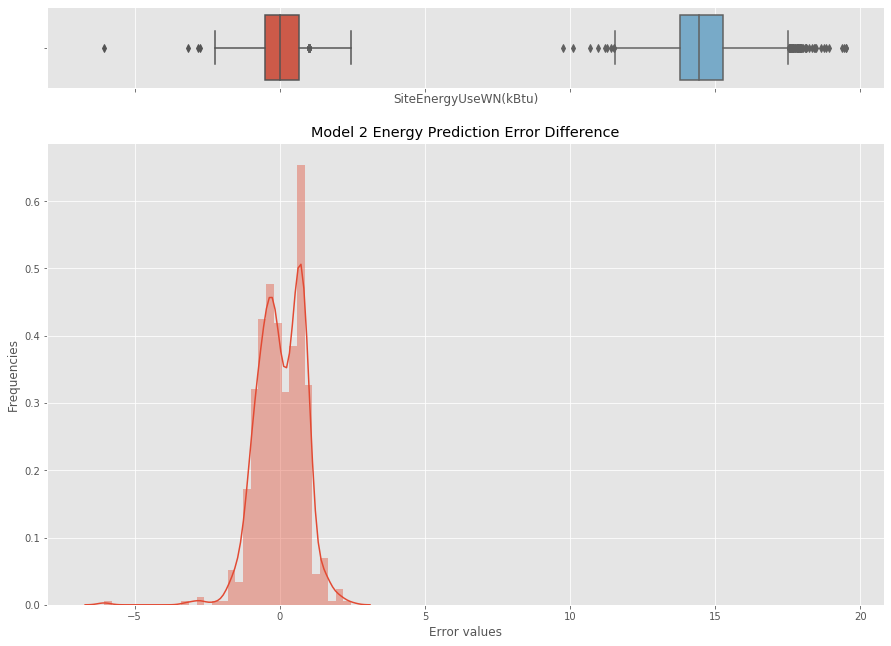

In [132]:
predictions_list = dataset_memory_models[0][1]["model 2"].predict(X_test_unleaked)
prediction = []
for sublist in predictions_list:
    for item in sublist:
        prediction.append(item)
df_diff = pd.DataFrame(prediction - y_test_GHG)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(prediction))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax0 = sns.boxplot(log_energy_data_2016, ax=ax_box, palette="Blues")
ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="Model 2 Energy Prediction Error Difference")


In [131]:
bestmodels = []
for dataset in Memory_DF:
    bestmodels.append(dataset.sort_values('test_mse').head(5))

bestmodels

AttributeError: 'str' object has no attribute 'sort_values'

In [127]:
data  = go.Figure(data = [
            go.Bar(
              y = bestmodels[0].description,
              x = bestmodels[0]['test_mse'],
              orientation='h',
              name = 'MSE'
            ),
            go.Bar(
              y = bestmodels[0].description,
              x = bestmodels[0]['test_mape'],
              orientation='h',
              name = 'MAPE'
            )
])
layout = go.Layout(
        title = "MSE and MAPE Scores",
)
fig  = go.Figure(data=data, layout=layout)
fig.update_layout(barmode='stack')

pyoff.iplot(fig)

In [128]:
Memory_models

{'model 0': <tensorflow.python.keras.engine.sequential.Sequential at 0x217743850>,
 'model 1': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e7b02f50>,
 'model 2': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f56b5ad0>,
 'model 3': <tensorflow.python.keras.engine.sequential.Sequential at 0x2176ec350>,
 'model 4': <tensorflow.python.keras.engine.sequential.Sequential at 0x216f78ed0>,
 'model 5': <tensorflow.python.keras.engine.sequential.Sequential at 0x205b80750>,
 'model 6': <tensorflow.python.keras.engine.sequential.Sequential at 0x22c24d110>,
 'model 7': <tensorflow.python.keras.engine.sequential.Sequential at 0x215523990>,
 'model 8': <tensorflow.python.keras.engine.sequential.Sequential at 0x214897410>,
 'model 9': <tensorflow.python.keras.engine.sequential.Sequential at 0x219336b10>,
 'model 10': <tensorflow.python.keras.engine.sequential.Sequential at 0x21da32610>,
 'model 11': <tensorflow.python.keras.engine.sequential.Sequential at 0x2201ece50>}

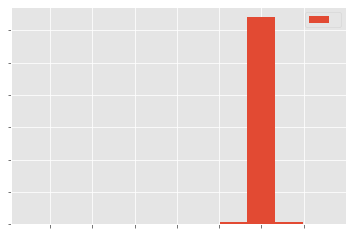

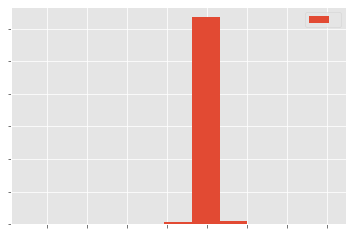

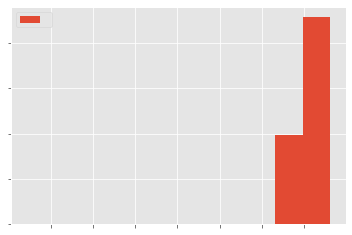

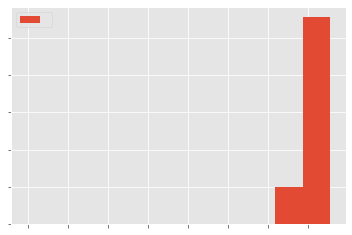

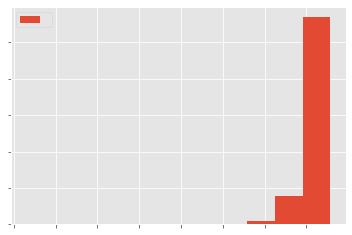

In [295]:
binNumb = int(np.ceil(1 + np.log2(len(X_test))))

for indice in best_model_df.index:
    predict_test = Memory_models['model %d' % indice].predict(X_test)
    new_predict = []
    for array in predict_test:
        for element in array:
            new_predict.append(element)
    df_diff = pd.DataFrame(new_predict - y_test_energy)
    df_diff.plot.hist(bins = binNumb)

### Evaluation

Clean presentation of results for MSE etc etc 
See if TensorBoard c'ant already do it

## RDF

(Random Deep Forest) 

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.base import clone


### K Fold

In [49]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [50]:
n_folds = 5
kf = KFold(n_folds)

### Random CV Search

In [51]:
from sklearn.model_selection import RandomizedSearchCV

In [52]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [53]:
RCV_models = []

In [54]:
data_sets[0][0]

array([[-0.04393669,  1.69226051,  1.46461953, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04393669, -0.12622845, -0.23097562, ...,  1.        ,
         0.        ,  0.        ],
       [-0.04393669,  0.05562045, -0.4304951 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.04393669, -0.12622845, -0.36656743, ...,  0.        ,
         0.        ,  1.        ],
       [-0.04393669, -0.30807734, -0.34626838, ...,  0.        ,
         0.        ,  1.        ],
       [-0.04393669, -0.12622845,  0.11879424, ...,  0.        ,
         0.        ,  1.        ]])

In [55]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf2 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 50, cv = kf, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
for dataset in data_sets:
    rf_random.fit(dataset[0], dataset[1])
    RCV_models.append([rf_random.best_params_, rf_random.best_estimator_, rf_random])
    

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   38.6s finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 219 out of 250 | elapsed:   14.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   16.6s finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   33.5s finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   15.6s finished


1.7684917330741883  minutes.


In [56]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf2 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 50, cv = kf, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dataset = data_sets[1]
rf_random.fit(dataset[0], dataset[1])
RCV_models.append([rf_random.best_params_, rf_random.best_estimator_, rf_random])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   35.2s finished


0.5897297660509745  minutes.


### Grid CV Search

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
# Create the parameter grid based on the results of random search 
param_grid_False = {
    'bootstrap': [False],
    'max_depth': [10, 30, 50, 80, 90, 100, 110, 150, 200],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [5, 10, 20, 30, 40, 50, 80, 100, 150]
}

In [58]:
# Create a based model
rf_RFR = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_RFR,
                           param_grid=param_grid_False,
                           cv=kf,
                           n_jobs=-1,
                           verbose=-1)

In [59]:
# Fit the grid search to the data
GCV_models = []
for dataset in data_sets:
    grid_search.fit(dataset[0], dataset[1])
    GCV_models.append(
        [grid_search.best_params_, grid_search.best_estimator_, grid_search])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 961 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1321 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 1825 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 2473 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 4201 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5281 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6505 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 7873 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 9385 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-

11.28887571891149  minutes.


In [61]:
GCV_models = []
dataset = data_sets[1]
grid_search.fit(dataset[0], dataset[1])
GCV_models.append(
    [grid_search.best_params_, grid_search.best_estimator_, grid_search])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 3288 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 4224 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 5304 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6528 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 7896 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 9408 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed:  2.4min finished


2.4348655184110006  minutes.


In [60]:
param_grid_True = {
    'bootstrap': [True],
    'max_depth': [10, 30, 50, 80, 90, 100, 110, 150, 200],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [5, 10, 20, 30, 40, 50, 80, 100, 150]
}

# Create a based model
rf_RFR = RandomForestRegressor()
# Instantiate the grid search model
grid_search_boot = GridSearchCV(estimator=rf_RFR,
                           param_grid=param_grid_True,
                           cv=kf,
                           n_jobs=-1,
                           verbose=2)

In [61]:
# Fit the grid search to the data
GCV_boot_models = []
for dataset in data_sets:
    grid_search_boot.fit(dataset[0], dataset[1])
    GCV_boot_models.append(
        [grid_search_boot.best_params_, grid_search_boot.best_estimator_, grid_search_boot])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 847 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1130 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 1495 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 1940 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 2467 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 3074 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 3763 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4532 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5383 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6314 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 7327 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 8420 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 9595 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 10850 tasks      | elapsed:  3

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1038 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1321 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 1686 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 2131 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 2658 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 4723 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5574 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6505 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7518 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 8611 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 9786 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed:

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1097 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1946 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 3041 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 4376 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5915 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6530 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 7219 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 7988 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8839 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 9770 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 10783 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed:  2.9min finished


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1059 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1342 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1707 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 2679 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 3286 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 3975 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 4744 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5595 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6526 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7539 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 8632 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 9807 tasks     

10.968676014741261  minutes.


In [ ]:
# Fit the grid search to the data
GCV_boot_models = []
dataset = data_sets[1]
grid_search_boot.fit(dataset[0], dataset[1])
GCV_boot_models.append(
    [grid_search_boot.best_params_, grid_search_boot.best_estimator_, grid_search_boot])

In [62]:
score = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']
score_boot = grid_search_boot.cv_results_['mean_test_score']
scores_std_boot = grid_search_boot.cv_results_['std_test_score']

In [ ]:
fig = go.Figure()
x = np.linspace(0, 2186,  num = 2187)

fig.add_trace(go.Scatter(x=x, y = score+scores_std, name = '+STD score', line=dict(color='royalblue', width=1, dash='dot')))
fig.add_trace(go.Scatter(x=x, y = score, name = 'Mean score', line = dict(color='firebrick', width=1.3)))
fig.add_trace(go.Scatter(x=x, y = score-scores_std, name = '-STD score', line=dict(color='royalblue', width=1, dash='dot')))

fig.update_traces(mode='lines')

fig.update_layout(title='Grid Search scores\' mean',
                   xaxis_title='Data Index',
                   yaxis_title='Score')

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(y = score_boot+scores_std_boot, name = '+STD_score', line=dict(color='royalblue', width=1, dash='dot')))
fig.add_trace(go.Scatter(y = score_boot, name = 'Mean_score', line=dict(color='firebrick', width=1)))
fig.add_trace(go.Scatter(y = score_boot-scores_std_boot, name = '-STD_score', line=dict(color='royalblue', width=1, dash='dot')))

fig.show()

### Deep Forest

Averaging best models over large iterations

In [63]:
def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = pd.DataFrame(importances, index = [X_test.columns[:]], columns = ['values'])
    return importances_df

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def best_test_model(X_train, X_test, y_train, y_test, params,itera, iterations = 100):
    print("training : ", params)
    recordTable= []
    recordMapeTrain= []
    recordMapeTest= []
    recordMseTrain= []
    recordMseTest = []
    recordModel = []
    
    max_count = iterations
    f = IntProgress(min=0, max=max_count)
    display(f)
    
    for i in range(1, iterations):
        random.seed(42)
        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)

        predict_train = rf.predict(X_train)
        predict_test = rf.predict(X_test)

        diff = np.abs(y_train - predict_train)
        perc = np.multiply(diff, 1/y_train)
        mape_train = np.mean(perc)*100
        mse_train = np.sqrt(np.mean(np.square(np.subtract(predict_train, y_train))))       

        diff = np.abs(y_test - predict_test)
        perc = np.multiply(diff, 1/y_test)
        mape_test = np.mean(perc)*100
        mse_test = np.sqrt(np.mean(np.square(np.subtract(predict_test, y_test))))
        
        recordMapeTrain.append(mape_train)
        recordMapeTest.append(mape_test)
        recordMseTrain.append(mse_train)
        recordMseTest.append(mse_test)
        recordModel.append(rf)
        
        f.value += 1 # signal to increment the progress bar
        
        dataset_num = itera % 4
        modelName = "Error"
        if(itera >= 0): modelName = "RCV dataset %d" % dataset_num
        if(itera >= 4): modelName = "GCV dataset %d" % dataset_num
        if(itera >= 8): modelName = "GCV_boot dataset %d" % dataset_num
      
        
    max_test_index = np.where(recordMseTest == find_nearest(recordMseTest, 0))[0]
    bestModel = {
        "modelName" : modelName,
        "model" : recordModel[max_test_index[0]],
        "predict_test": predict_test,
        "MapeTrain" : recordMapeTrain[max_test_index[0]],
        "MapeTest" : recordMapeTest[max_test_index[0]],
        "MseTrain" : recordMseTrain[max_test_index[0]],
        "MseTest" : recordMseTest[max_test_index[0]],
    }
    
    print("i is : ", itera)
    print("model is : ", modelName)
    print("Mean train MSE score of this model : ", np.mean(recordMseTrain), " with a best MSE of ", recordMseTrain[max_test_index[0]] ,'\n')
    print("Mean test MSE score of this model : ", np.mean(recordMseTest), " with a best MSE of ", recordMseTest[max_test_index[0]] ,"and MAPE of ",recordMapeTest[max_test_index[0]], '\n')
    return bestModel

In [64]:

All_model = [RCV_models, GCV_models, GCV_boot_models]
modelList = []
i = 0
for modellist in All_model:
    for dataset in data_sets:
        modelList.append(best_test_model(dataset[0], dataset[2], dataset[1], dataset[3], modellist[i%4][0], i, 50))
        i+=1
    

training :  {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


IntProgress(value=0, max=50)

i is :  0
model is :  RCV dataset 0
Mean train MSE score of this model :  0.3683926431598396  with a best MSE of  0.368213266285586 

Mean test MSE score of this model :  0.703460794497323  with a best MSE of  0.6909431428327975 and MAPE of  -191.34896048484512 

training :  {'n_estimators': 111, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


IntProgress(value=0, max=50)

i is :  1
model is :  RCV dataset 1
Mean train MSE score of this model :  0.6283244946725146  with a best MSE of  0.6298270527764193 

Mean test MSE score of this model :  0.7874985506907243  with a best MSE of  0.7718832101665346 and MAPE of  -663.4561836203592 

training :  {'n_estimators': 111, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


IntProgress(value=0, max=50)

i is :  2
model is :  RCV dataset 2
Mean train MSE score of this model :  0.136599416666683  with a best MSE of  0.13601847922774785 

Mean test MSE score of this model :  0.2473831891418854  with a best MSE of  0.24411146303576559 and MAPE of  -15.573617371117777 

training :  {'n_estimators': 111, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


IntProgress(value=0, max=50)

i is :  3
model is :  RCV dataset 3
Mean train MSE score of this model :  0.505863721016074  with a best MSE of  0.5028177509227523 

Mean test MSE score of this model :  0.6630965162726374  with a best MSE of  0.6588086847786807 and MAPE of  2.343439208442459 

training :  {'bootstrap': False, 'max_depth': 100, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 40}


IntProgress(value=0, max=50)

i is :  4
model is :  GCV dataset 0
Mean train MSE score of this model :  0.5346408881064089  with a best MSE of  0.5307112222844205 

Mean test MSE score of this model :  0.7032631488876177  with a best MSE of  0.68477811006291 and MAPE of  -309.62906962254135 

training :  {'bootstrap': False, 'max_depth': 80, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20}


IntProgress(value=0, max=50)

i is :  5
model is :  GCV dataset 1
Mean train MSE score of this model :  0.7061395671886178  with a best MSE of  0.7165495023931485 

Mean test MSE score of this model :  0.7960131770389302  with a best MSE of  0.7786862838463525 and MAPE of  -633.8621315219272 

training :  {'bootstrap': False, 'max_depth': 150, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 150}


IntProgress(value=0, max=50)

i is :  6
model is :  GCV dataset 2
Mean train MSE score of this model :  0.1623488309884927  with a best MSE of  0.16164540542500244 

Mean test MSE score of this model :  0.2618047786184857  with a best MSE of  0.2584635316013453 and MAPE of  -19.595320930688718 

training :  {'bootstrap': False, 'max_depth': 80, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 50}


IntProgress(value=0, max=50)

i is :  7
model is :  GCV dataset 3
Mean train MSE score of this model :  0.5585759555507549  with a best MSE of  0.553545468130459 

Mean test MSE score of this model :  0.6764128421683377  with a best MSE of  0.6693615320589934 and MAPE of  -8.098504302480116 

training :  {'bootstrap': True, 'max_depth': 110, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 30}


IntProgress(value=0, max=50)

i is :  8
model is :  GCV_boot dataset 0
Mean train MSE score of this model :  0.5931994967317398  with a best MSE of  0.5763806611899897 

Mean test MSE score of this model :  0.715472685292022  with a best MSE of  0.6922163035193021 and MAPE of  -830.2322396902943 

training :  {'bootstrap': True, 'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 50}


IntProgress(value=0, max=50)

i is :  9
model is :  GCV_boot dataset 1
Mean train MSE score of this model :  0.735525906551112  with a best MSE of  0.7355224416772536 

Mean test MSE score of this model :  0.7907779290383453  with a best MSE of  0.7754254350120149 and MAPE of  -503.1037796164199 

training :  {'bootstrap': True, 'max_depth': 200, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


IntProgress(value=0, max=50)

i is :  10
model is :  GCV_boot dataset 2
Mean train MSE score of this model :  0.2004155711491514  with a best MSE of  0.1957846694487093 

Mean test MSE score of this model :  0.2723701064310828  with a best MSE of  0.2674141263892717 and MAPE of  -19.78586079096743 

training :  {'bootstrap': True, 'max_depth': 80, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 80}


IntProgress(value=0, max=50)

i is :  11
model is :  GCV_boot dataset 3
Mean train MSE score of this model :  0.6134914362126865  with a best MSE of  0.6061466189179743 

Mean test MSE score of this model :  0.683967605672631  with a best MSE of  0.6783042555910034 and MAPE of  -38.24164105239118 



2.3738394021987914  minutes.


In [64]:
All_model = [RCV_models, GCV_models, GCV_boot_models]
modelList = []
i = 1
for modellist in All_model:
    dataset = data_sets[3]
    modelList.append(best_test_model(dataset[0], dataset[2], dataset[1], dataset[3], modellist[0][0], i, 50))
    i+=4
    

training :  {'n_estimators': 155, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


IntProgress(value=0, max=50)

i is :  1
model is :  RCV dataset 1
Mean train MSE score of this model :  0.4821295483692487  with a best MSE of  0.4817961770363858 

Mean test MSE score of this model :  0.6578740460375637  with a best MSE of  0.653926714329889 and MAPE of  10.151187733482992 

training :  {'bootstrap': False, 'max_depth': 30, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 100}


IntProgress(value=0, max=50)

i is :  5
model is :  GCV dataset 1
Mean train MSE score of this model :  0.5746784591633063  with a best MSE of  0.5730159818438878 

Mean test MSE score of this model :  0.6757869821610935  with a best MSE of  0.6720544867017136 and MAPE of  -35.08421827137245 

training :  {'bootstrap': True, 'max_depth': 110, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 30}


IntProgress(value=0, max=50)

i is :  9
model is :  GCV_boot dataset 1
Mean train MSE score of this model :  0.6221588049959484  with a best MSE of  0.6147937477429688 

Mean test MSE score of this model :  0.6861915827163861  with a best MSE of  0.6771209144178557 and MAPE of  -39.641218060350816 



0.5149592995643616  minutes.


In [74]:
modelList

[{'modelName': 'RCV dataset 0',
  'model': RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
             oob_score=False, random_state=None, verbose=0, warm_start=False),
  'predict_test': array([-7.41065169e-01,  1.96357958e-02, -1.67276929e+00,  1.70995472e-01,
         -5.65273222e-01,  1.55803604e-01,  1.54609315e-01,  1.10792903e-01,
          3.98421058e-01, -1.47139774e-01,  1.43656624e+00, -6.51499560e-01,
         -1.47694131e+00,  3.52391582e-01, -5.24391184e-01, -1.96545622e-03,
         -8.40406353e-02,  9.04426130e-01,  5.41832439e-01,  4.43532951e-01,
          7.31104814e-01, -4.47837447e-01, -3.41855230e-01,  1.07830998e-01,
         -4.68347387e-01,  8.31340432e-01,  1.12310754e+00,  6.41661958e-01,
    

### Evaluation

In [77]:
DfModelList = list(modelList.copy())

In [78]:
DfModelList

[{'modelName': 'RCV dataset 0',
  'model': RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
             oob_score=False, random_state=None, verbose=0, warm_start=False),
  'predict_test': array([-7.41065169e-01,  1.96357958e-02, -1.67276929e+00,  1.70995472e-01,
         -5.65273222e-01,  1.55803604e-01,  1.54609315e-01,  1.10792903e-01,
          3.98421058e-01, -1.47139774e-01,  1.43656624e+00, -6.51499560e-01,
         -1.47694131e+00,  3.52391582e-01, -5.24391184e-01, -1.96545622e-03,
         -8.40406353e-02,  9.04426130e-01,  5.41832439e-01,  4.43532951e-01,
          7.31104814e-01, -4.47837447e-01, -3.41855230e-01,  1.07830998e-01,
         -4.68347387e-01,  8.31340432e-01,  1.12310754e+00,  6.41661958e-01,
    

[-0.00070107] [0.01768101]


[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'Random-CV GHG Prediction Error Difference')]

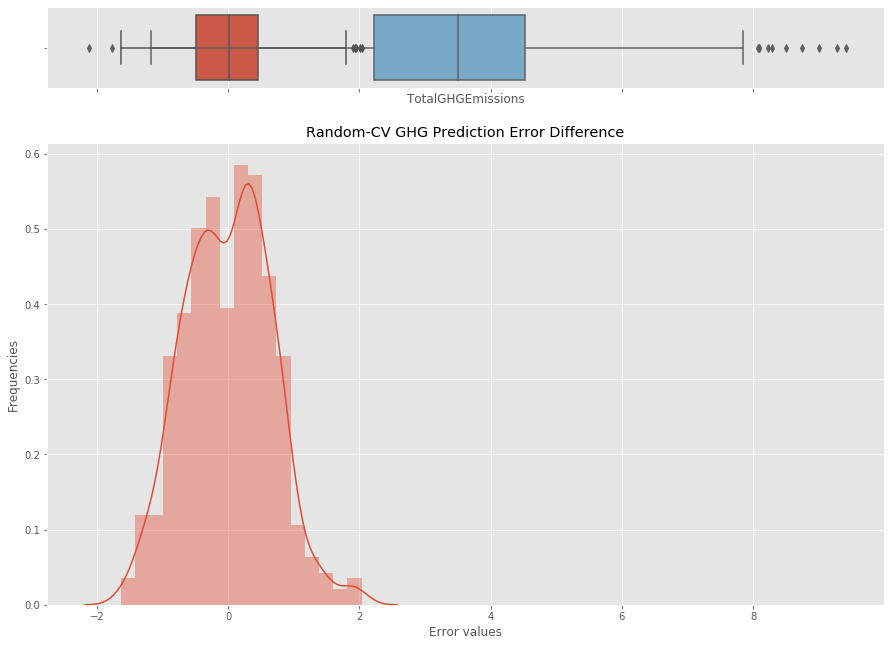

In [82]:
prediction = DfModelList[3]["model"].predict(X_test_unleaked)
#prediction = []
#for sublist in predictions_list:
#    for item in sublist:
#        prediction.append(item)
df_diff = pd.DataFrame(prediction - y_test_GHG)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(prediction))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax0 = sns.boxplot(log_ghg_data_2016, ax=ax_box, palette="Blues")
ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="Random-CV GHG Prediction Error Difference")

In [71]:
binNumb = int(np.ceil(1 + np.log2(len(DfModelList[0]['predict_test']))))
for model in DfModelList:
    df_diff = pd.DataFrame(model['predict_test'] - y_test_energy)
    df_diff.plot.hist(bins = binNumb)

NameError: name 'DfModelList' is not defined

In [72]:
model_df = pd.DataFrame.from_dict(DfModelList)
model_df = model_df.set_index(['modelName'])
model_df = model_df[['MapeTrain', 'MapeTest', 'MseTrain', 'MseTest']].abs()
model_df

NameError: name 'DfModelList' is not defined

In [73]:
model_df[1::2]['MseTest'].values

NameError: name 'model_df' is not defined

In [68]:
dfs = pd.DataFrame(index = ['RCV dataset Energy', 'RCV dataset GHG', 'GCV dataset Energy', 'GCV dataset GHG',
       'GCV_boot dataset Energy', 'GCV_boot dataset GHG'])
#model_df[::2]['MseTest']
dfs["MseTestLeaked"] = model_df[::2]['MseTest'].values
dfs["MseTestUnleaked"] = model_df[1::2]['MseTest'].values

dfs.iplot(kind="barh")

NameError: name 'model_df' is not defined


Unexpected error:  <class 'ValueError'>


ValueError: Number of features of the model must match the input. Model n_features is 46 and input n_features is 59 

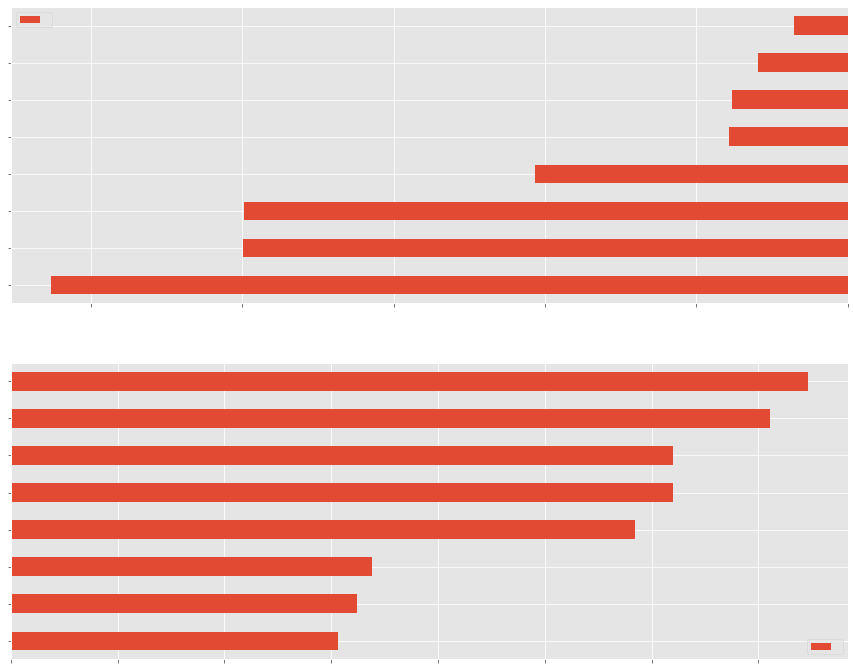

0.5272903521855672  minutes.


In [96]:
#Testing with fairml library 
#It combines 4 models of evaluation to score the features of the model. 

i = 1
for model in modelList:

    #  call audit model with model
    total, _ = audit_model(model['model'].predict, X)

    df_total = pd.DataFrame.from_dict(total.median(), orient='index')
    df_total.columns = ["Feature Importance"]
    df_total = df_total.sort_values(by="Feature Importance")
    
    fig, (ax1, ax2) = plt.subplots(nrows = 2)
    title = (" 8 Feature from Model %d" % i)
    df_total.head(8).plot.barh(ax=ax1, figsize = (15,12), title = ("Worst" +title))
    df_total.tail(8).plot.barh(ax=ax2, figsize = (15,12), title = ("Best" +title))
    print()
    i += 1

In [140]:
df_total = pd.DataFrame.from_dict(total.median(), orient='index')
df_total.columns = ["Feature Importance"]
df_total = df_total.sort_values(by="Feature Importance")

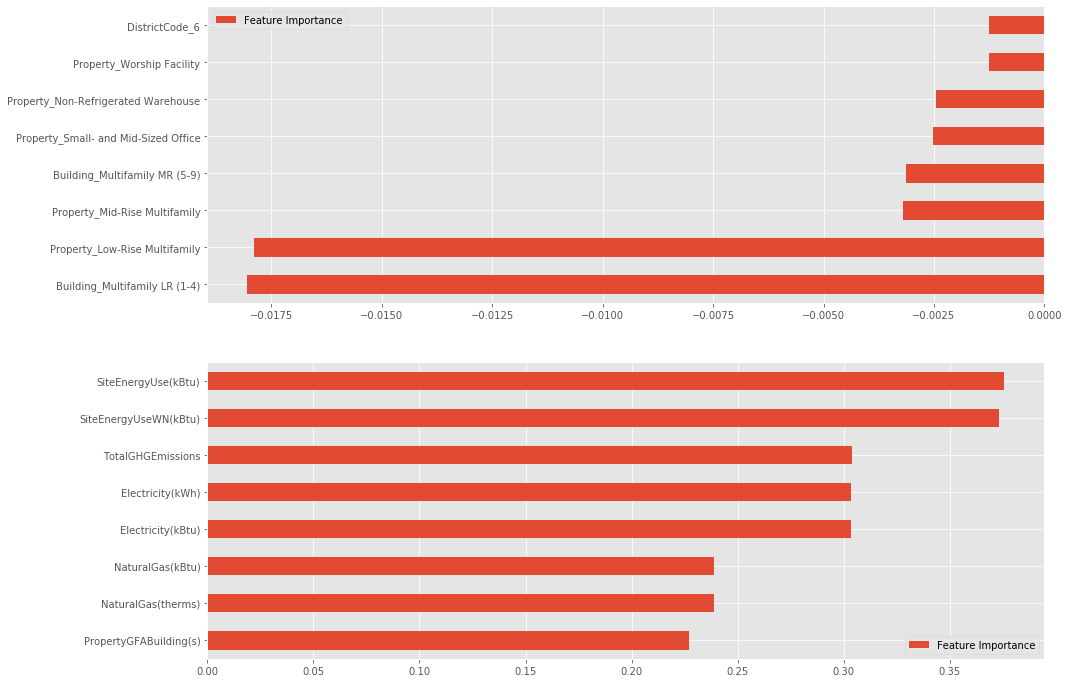

In [141]:
fig, (ax1, ax2) = plt.subplots(nrows = 2)

df_total.head(8).plot.barh(ax=ax1, figsize = (15,12))
df_total.tail(8).plot.barh(ax=ax2, figsize = (15,12))

##### Analysing Features' Importance

ValueError: Shape of passed values is (46, 1), indices imply (59, 1)

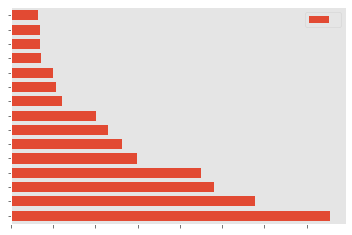

In [97]:
for model in modelList:
    ft_imp = pd.DataFrame(model['model'].feature_importances_ , index = [X.columns[:]], columns = ['values'])
    #ft_imp = ft_imp.rename(columns = { 0: 'Features'})
    ft_imp.sort_values(by= 'values', axis = 0, ascending=False).iloc[0:15].plot(kind = 'barh', width=0.7).grid()

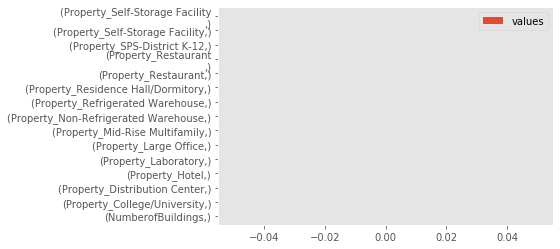

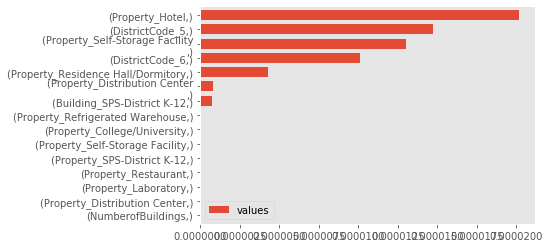

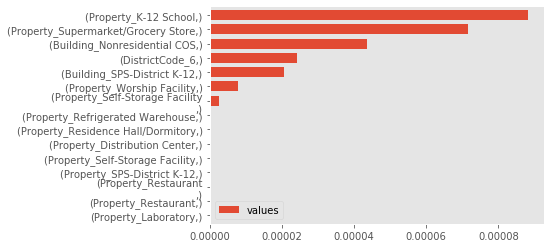

In [143]:
for model in modelList:
    ft_imp = pd.DataFrame(model['model'].feature_importances_ , index = [X.columns[:]], columns = ['values'])
    #ft_imp = ft_imp.rename(columns = { 0: 'Features'})
    ft_imp.sort_values(by= 'values', axis = 0, ascending=True).iloc[0:15].plot(kind = 'barh', width=0.7).grid()

##### Evaluating models

In [128]:
model_df[['MapeTrain', 'MapeTest', 'MseTrain', 'MseTest']]

MapeTrain   MapeTest  MseTrain   MseTest
modelName                                                   
GCV_boot dataset 0   1.812315   2.266850  0.050154  0.298014
GCV_boot dataset 1   7.307885  41.774699  0.217016  0.458233
GCV_boot dataset 2   0.213365   1.794899  0.002171  0.403384
GCV_boot dataset 3  12.553516  15.765050  0.212048  0.571024
GCV_boot dataset 0   8.023507   5.051775  0.197493  0.215403
GCV_boot dataset 1  28.915340  27.009771  0.483944  0.476866
GCV_boot dataset 2  12.374018   9.967250  0.434410  0.342438
GCV_boot dataset 3  15.375809  26.855887  0.562650  0.571622
GCV_boot dataset 0   4.526161  16.546083  0.360668  0.254467
GCV_boot dataset 1  30.474429  10.945828  0.586089  0.488189
GCV_boot dataset 2  34.449273  24.395506  0.416959  0.355191
GCV_boot dataset 3  35.636613  46.174776  0.641792  0.650734

In [144]:
modelList[0]['modelName'] = "Model 1"
modelList[1]['modelName'] = "Model 2"
modelList[2]['modelName'] = "Model 3"

In [126]:
model_df = pd.DataFrame.from_dict(DfModelList)
model_df = model_df.set_index(['modelName'])
model_df = model_df[['MapeTrain', 'MapeTest', 'MseTrain', 'MseTest']].abs()

Text(0.5, 1.0, 'Performance des 3 models finaux')

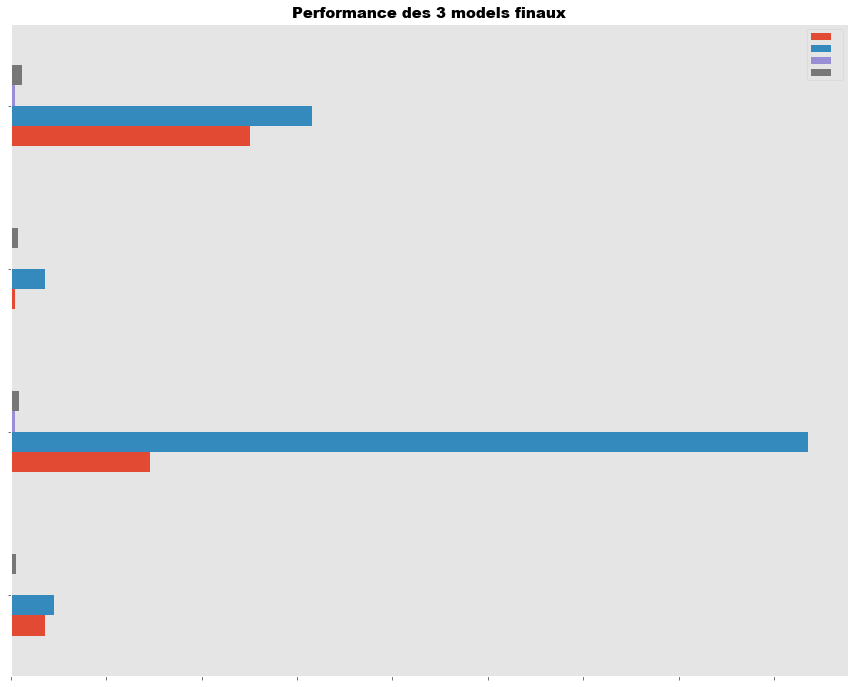

In [127]:
model_df[:4][['MapeTrain', 'MapeTest', 'MseTrain', 'MseTest']].plot(kind='barh', figsize=(15, 12)).grid()
plt.xlabel('Scores', fontsize=13)
plt.ylabel('Modeles', fontsize=13)
plt.title('Performance des 3 models finaux', fontname="Arial Black", size=15)

#####  Evaluation

Evaluation of Random CV Search

In [198]:
RDF_CV_accuracy_test = rf_random.score(X_test,y_test_energy)
print('\naccuracy_score on test dataset : ', RDF_CV_accuracy_test)


accuracy_score on test dataset :  0.803497190431764


In [199]:
base_accuracy = evaluate(rf_random, X_test, y_test_energy)

predictions :  [-3.16542546e-01 -3.61019294e-01 -2.75620119e-01 -1.20081729e-01
 -3.21177255e-01 -1.55289643e-01 -2.11614487e-01 -8.13825772e-02
 -2.67215457e-02 -2.61481639e-01  1.45903805e+00  2.61891991e-01
 -3.29952355e-01 -2.38984119e-01 -3.13906347e-01 -1.83019384e-01
 -1.83019384e-01 -3.07390946e-01  6.45172341e-02 -2.91906501e-01
  6.36616383e-02 -2.95196051e-01 -2.90081955e-01 -1.66080334e-01
 -1.40647686e-01  3.06686802e-01  6.34594040e-01 -1.99389451e-01
 -1.66080334e-01 -1.66834030e-01 -2.94580649e-01 -2.30138707e-01
 -2.75540156e-01 -1.68240771e-01 -2.50448830e-01 -3.33887796e-01
  1.56610123e+00 -1.14236022e-01 -2.58407646e-01 -1.40587361e-01
 -3.02756421e-01 -3.01096553e-01 -1.29345321e-01 -1.06313943e-01
 -2.26451164e-01 -2.84870421e-01  1.78726106e+00 -2.19240249e-01
 -4.69232664e-02 -3.50525240e-01 -2.47676823e-01 -3.31273812e-01
 -3.31998638e-01 -2.46019511e-01  2.88642394e-01 -2.31446011e-01
  4.42092881e-01  2.62711998e+00  5.81107792e-01 -2.24426616e-01
 -2.984054

In [200]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test_energy)

predictions :  [-3.16542546e-01 -3.61019294e-01 -2.75620119e-01 -1.20081729e-01
 -3.21177255e-01 -1.55289643e-01 -2.11614487e-01 -8.13825772e-02
 -2.67215457e-02 -2.61481639e-01  1.45903805e+00  2.61891991e-01
 -3.29952355e-01 -2.38984119e-01 -3.13906347e-01 -1.83019384e-01
 -1.83019384e-01 -3.07390946e-01  6.45172341e-02 -2.91906501e-01
  6.36616383e-02 -2.95196051e-01 -2.90081955e-01 -1.66080334e-01
 -1.40647686e-01  3.06686802e-01  6.34594040e-01 -1.99389451e-01
 -1.66080334e-01 -1.66834030e-01 -2.94580649e-01 -2.30138707e-01
 -2.75540156e-01 -1.68240771e-01 -2.50448830e-01 -3.33887796e-01
  1.56610123e+00 -1.14236022e-01 -2.58407646e-01 -1.40587361e-01
 -3.02756421e-01 -3.01096553e-01 -1.29345321e-01 -1.06313943e-01
 -2.26451164e-01 -2.84870421e-01  1.78726106e+00 -2.19240249e-01
 -4.69232664e-02 -3.50525240e-01 -2.47676823e-01 -3.31273812e-01
 -3.31998638e-01 -2.46019511e-01  2.88642394e-01 -2.31446011e-01
  4.42092881e-01  2.62711998e+00  5.81107792e-01 -2.24426616e-01
 -2.984054